# Uncertainty analysis

Here we will demonstrate a full uncertainty analysis of the inversion. We use a stochastic approach, where we 1) choose the important input parameters to the inversion, 2) define each of there uncertainty distributions, 3) run a series of inversions which sample these inputs from their uncertainty distributions, and 4) use the ensemble of inverted topography models to define the mean result and the uncertainty.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import copy
import logging
import pathlib
import pickle
import string

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    plotting,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Load results from notebook `Combining it all`

In [2]:
# load pickle files
params = []
with pathlib.Path("../tmp/combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    grav_df,
    constraint_points,
    starting_topography_kwargs,
    grids,
    inversion_results,
    kwargs,
    regional_grav_kwargs,
    _,
) = params

In [3]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

northing       easting  upward  upper_surface_grav  \
count   4941.000000   4941.000000  4941.0         4941.000000   
mean   15000.000000  20000.000000  1001.0           -0.229678   
std     8804.299419  11691.635129     0.0            7.103507   
min        0.000000      0.000000  1001.0          -17.227928   
25%     7500.000000  10000.000000  1001.0           -5.587227   
50%    15000.000000  20000.000000  1001.0           -1.239580   
75%    22500.000000  30000.000000  1001.0            3.490030   
max    30000.000000  40000.000000  1001.0           19.754954   

       lower_surface_grav  observed_grav  gravity_anomaly        uncert  \
count         4941.000000    4941.000000      4941.000000  4.941000e+03   
mean             0.004286      -0.225392        -0.225332  1.000000e-01   
std              0.720692       7.247722         7.245591  1.064189e-10   
min             -1.034071     -16.940400       -17.040892  1.000000e-01   
25%             -0.610336      -5.906763        -5.910496  1.000000e-01   
50%             -0.155380      -0.822890        -0.813296  1.000000e-01   
75%              0.542849       3.738912         3.726649  1.000000e-01   
max              1.602413      19.932831        19.959187  1.000000e-01   

       starting_gravity     true_res       misfit          reg          res  
count       4941.000000  4941.000000  4941.000000  4941.000000  4941.000000  
mean           1.025253    -1.254871    -1.250585    -0.826228    -0.424357  
std            6.860052     4.621594     4.852437     1.372797     4.483062  
min           -8.040797   -19.592049   -19.972713    -3.252846   -18.401579  
25%           -4.472542    -3.008015    -3.123793    -2.048561    -2.141997  
50%           -0.749905    -1.483188    -1.843795    -0.733214    -0.346209  
75%            5.319529     0.577570     0.952694     0.418425     1.567813  
max           23.360744    13.969991    14.301613     1.237943    14.384714

In [4]:
constraint_points.describe()

easting      northing  true_upward      upward     uncert  \
count     15.000000     15.000000    15.000000   15.000000  15.000000   
mean   18971.649226  16518.655913   489.096872  487.025168   9.781937   
std    10839.669022   8540.046257    79.152932   81.118110   1.583059   
min     3505.581182   1697.178371   406.379413  405.305719   8.127588   
25%    11575.107009  10553.975772   429.926990  424.663596   8.598540   
50%    19995.535031  16357.717739   454.924262  458.214230   9.098485   
75%    27651.208305  24233.535276   520.183444  514.207570  10.403669   
max    38163.601456  27603.626012   666.725645  668.402196  13.334513   

          weight  inverted_topography  
count  15.000000            15.000000  
mean    0.011132           490.371197  
std     0.003039            85.481490  
min     0.005624           396.314410  
25%     0.009240           429.575884  
50%     0.012080           455.378457  
75%     0.013525           527.970868  
max     0.015138           673.101002

In [5]:
true_topography = grids.true
lower_topography = grids.lower
starting_topography = grids.starting
final_topography = grids.inverted

In [6]:
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [7]:
kwargs

{'max_iterations': 200,
 'l2_norm_tolerance': 0.3,
 'delta_l2_norm_tolerance': 1.008}

In [8]:
regional_grav_kwargs["constraints_df"] = constraint_points
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 50,
  'damping_limits': (1e-10, 1),
  'progressbar': False,
  'fname': '../tmp/regional_sep'},
 'depth': 'default',
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624   
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138   
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833   
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347   
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184   
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080   
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789   
 7    3737.943068   7448.480613   582.902996  593.944123  11

In [9]:
starting_topography_kwargs

{'method': 'splines',
 'region': (0, 40000, 0, 30000),
 'spacing': 1000,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789
 7    3737.943068   7448.480613   582.902996  593.944123  11.658060  0.007358
 8   11200.681244  16357.717739   511.624141  504.423182  10.232483  0.009551
 9   19995.535031  26455.594497   450.505648  439.104058   9.010113  0.012318
 10  26810.739853   4728.744481   430.317216  424.9

# Extract parameters

In [10]:
parameters

{'Density contrast(s)': '[2735] kg/m3',
 'Reference level': '492.79238528548717 m',
 'Max iterations': 200,
 'L2 norm tolerance': '0.3',
 'Delta L2 norm tolerance': '1.008',
 'Deriv type': 'annulus',
 'Solver type': 'scipy least squares',
 'Solver damping': 0.02239318117126179,
 'Upper confining layer': 'Not enabled',
 'Lower confining layer': 'Not enabled',
 'Regularization weighting grid': 'Not enabled',
 'Time elapsed': '5 seconds',
 'Avg. iteration time': '1.84 seconds',
 'Final misfit RMSE / L2-norm': '0.0698 /0.2642 mGal',
 'Termination reason': ['l2-norm tolerance'],
 'Iteration times': [2.1698128759999236,
  1.558914330999869,
  1.8062508599996363]}

In [11]:
density_contrast = float(parameters["Density contrast(s)"][1:-7])
zref = float(parameters["Reference level"][:-2])
spacing = utils.get_spacing(grav_df)
region = vd.get_region((grav_df.easting, grav_df.northing))
solver_damping = parameters["Solver damping"]

print(f"Density contrast: {density_contrast} kg/m3")
print(f"Reference level: {zref} m")
print(f"Spacing: {spacing} m")
print(f"Region: {region}")
print(f"Solver damping: {solver_damping}")

Density contrast: 2735.0 kg/m3
Reference level: 492.79238528548717 m
Spacing: 500.0 m
Region: (np.float64(0.0), np.float64(40000.0), np.float64(0.0), np.float64(30000.0))
Solver damping: 0.02239318117126179


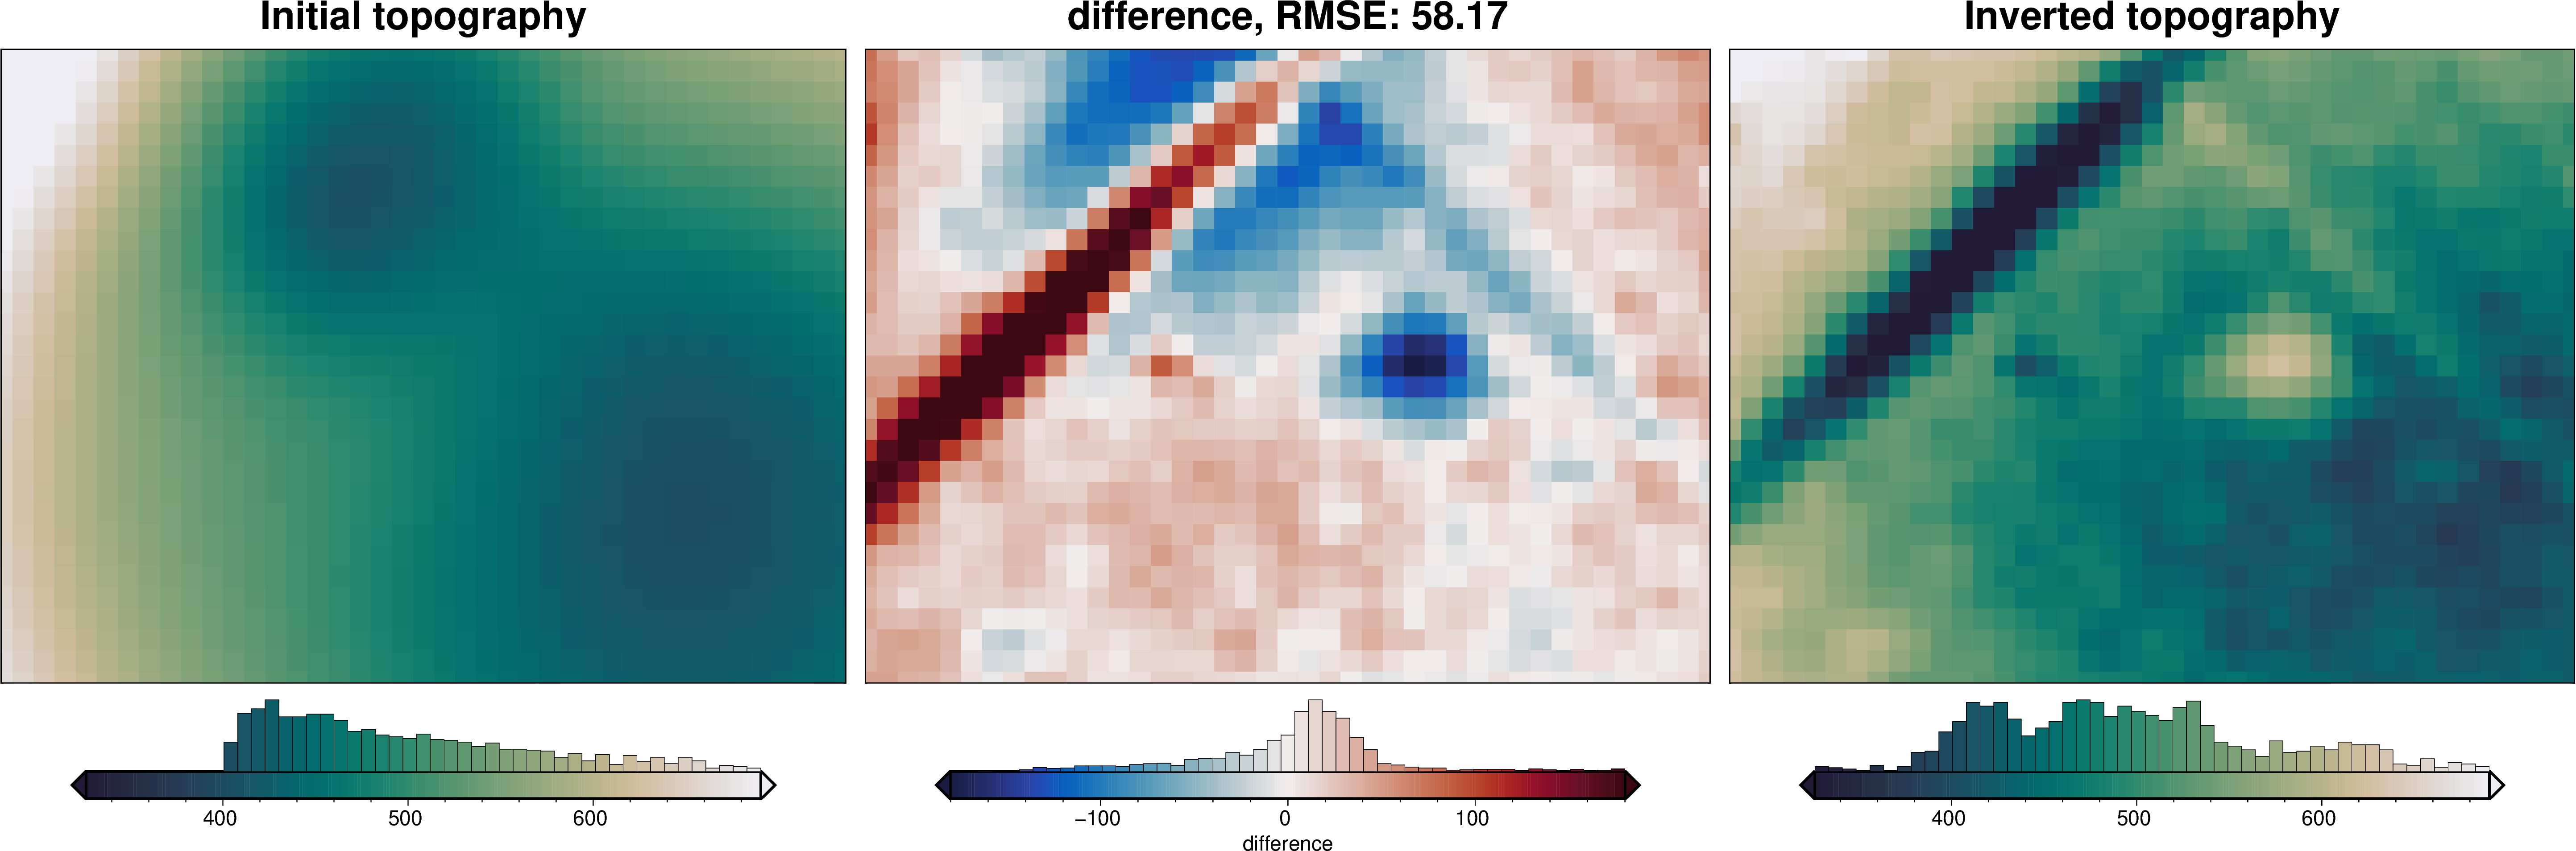

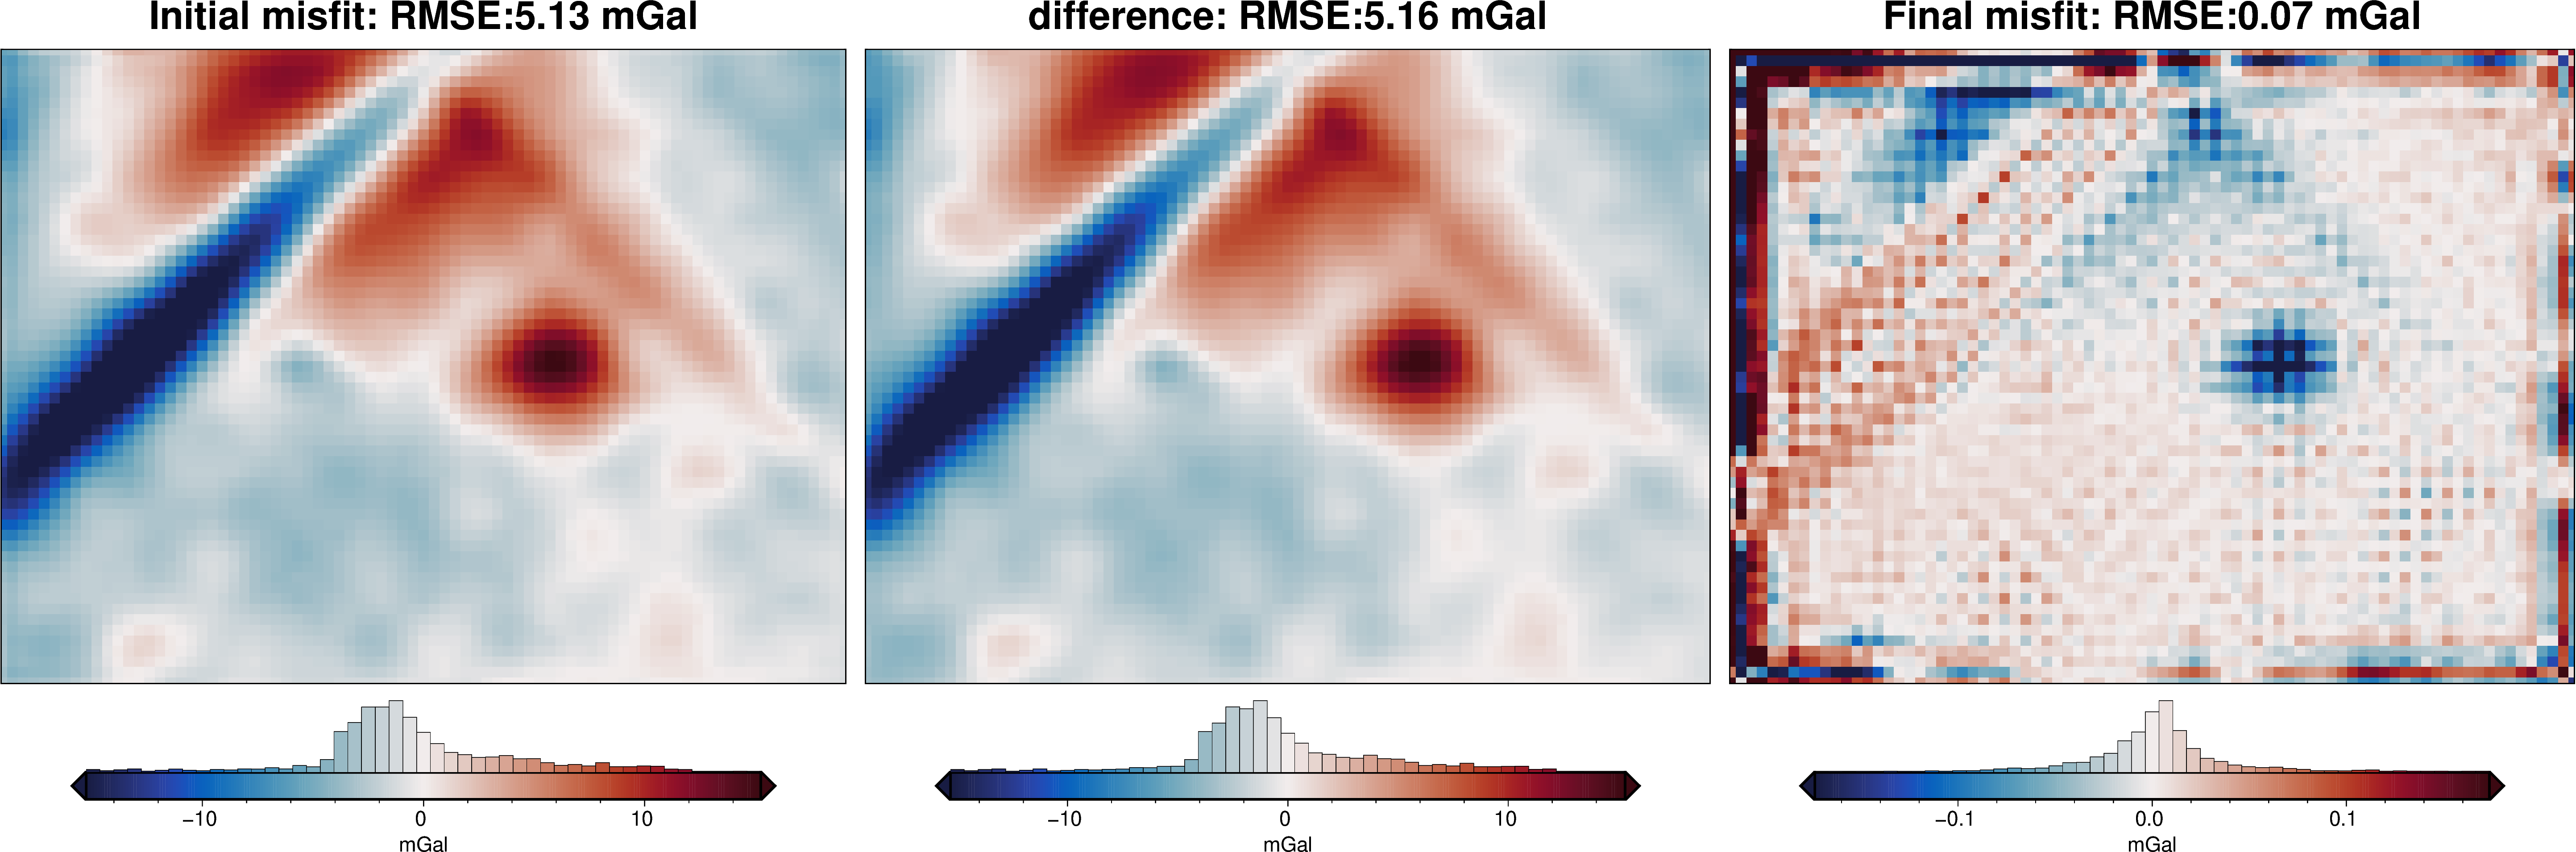

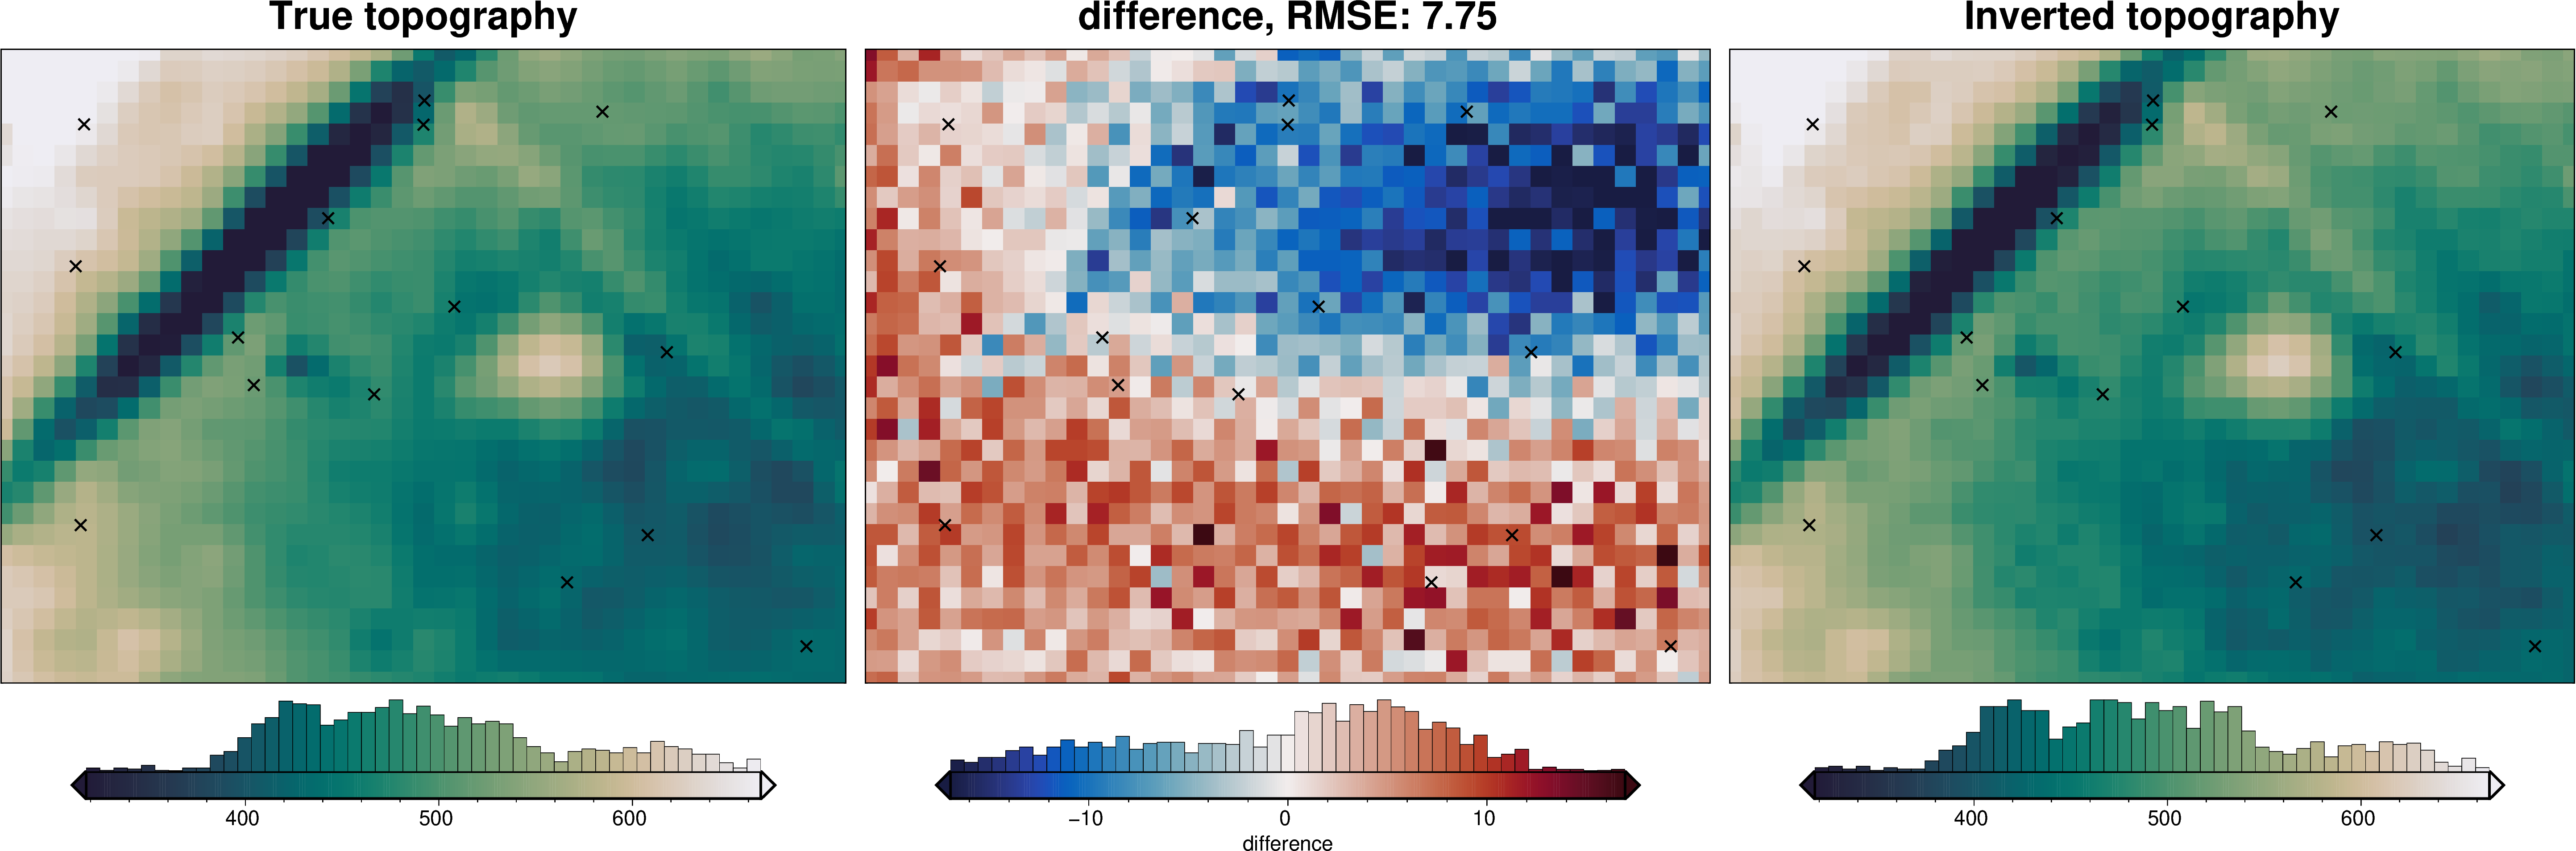

In [12]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=False,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

# Absolute value of inversion error

plot [WARNING]: .4c, not a valid number and may not be decoded properly.


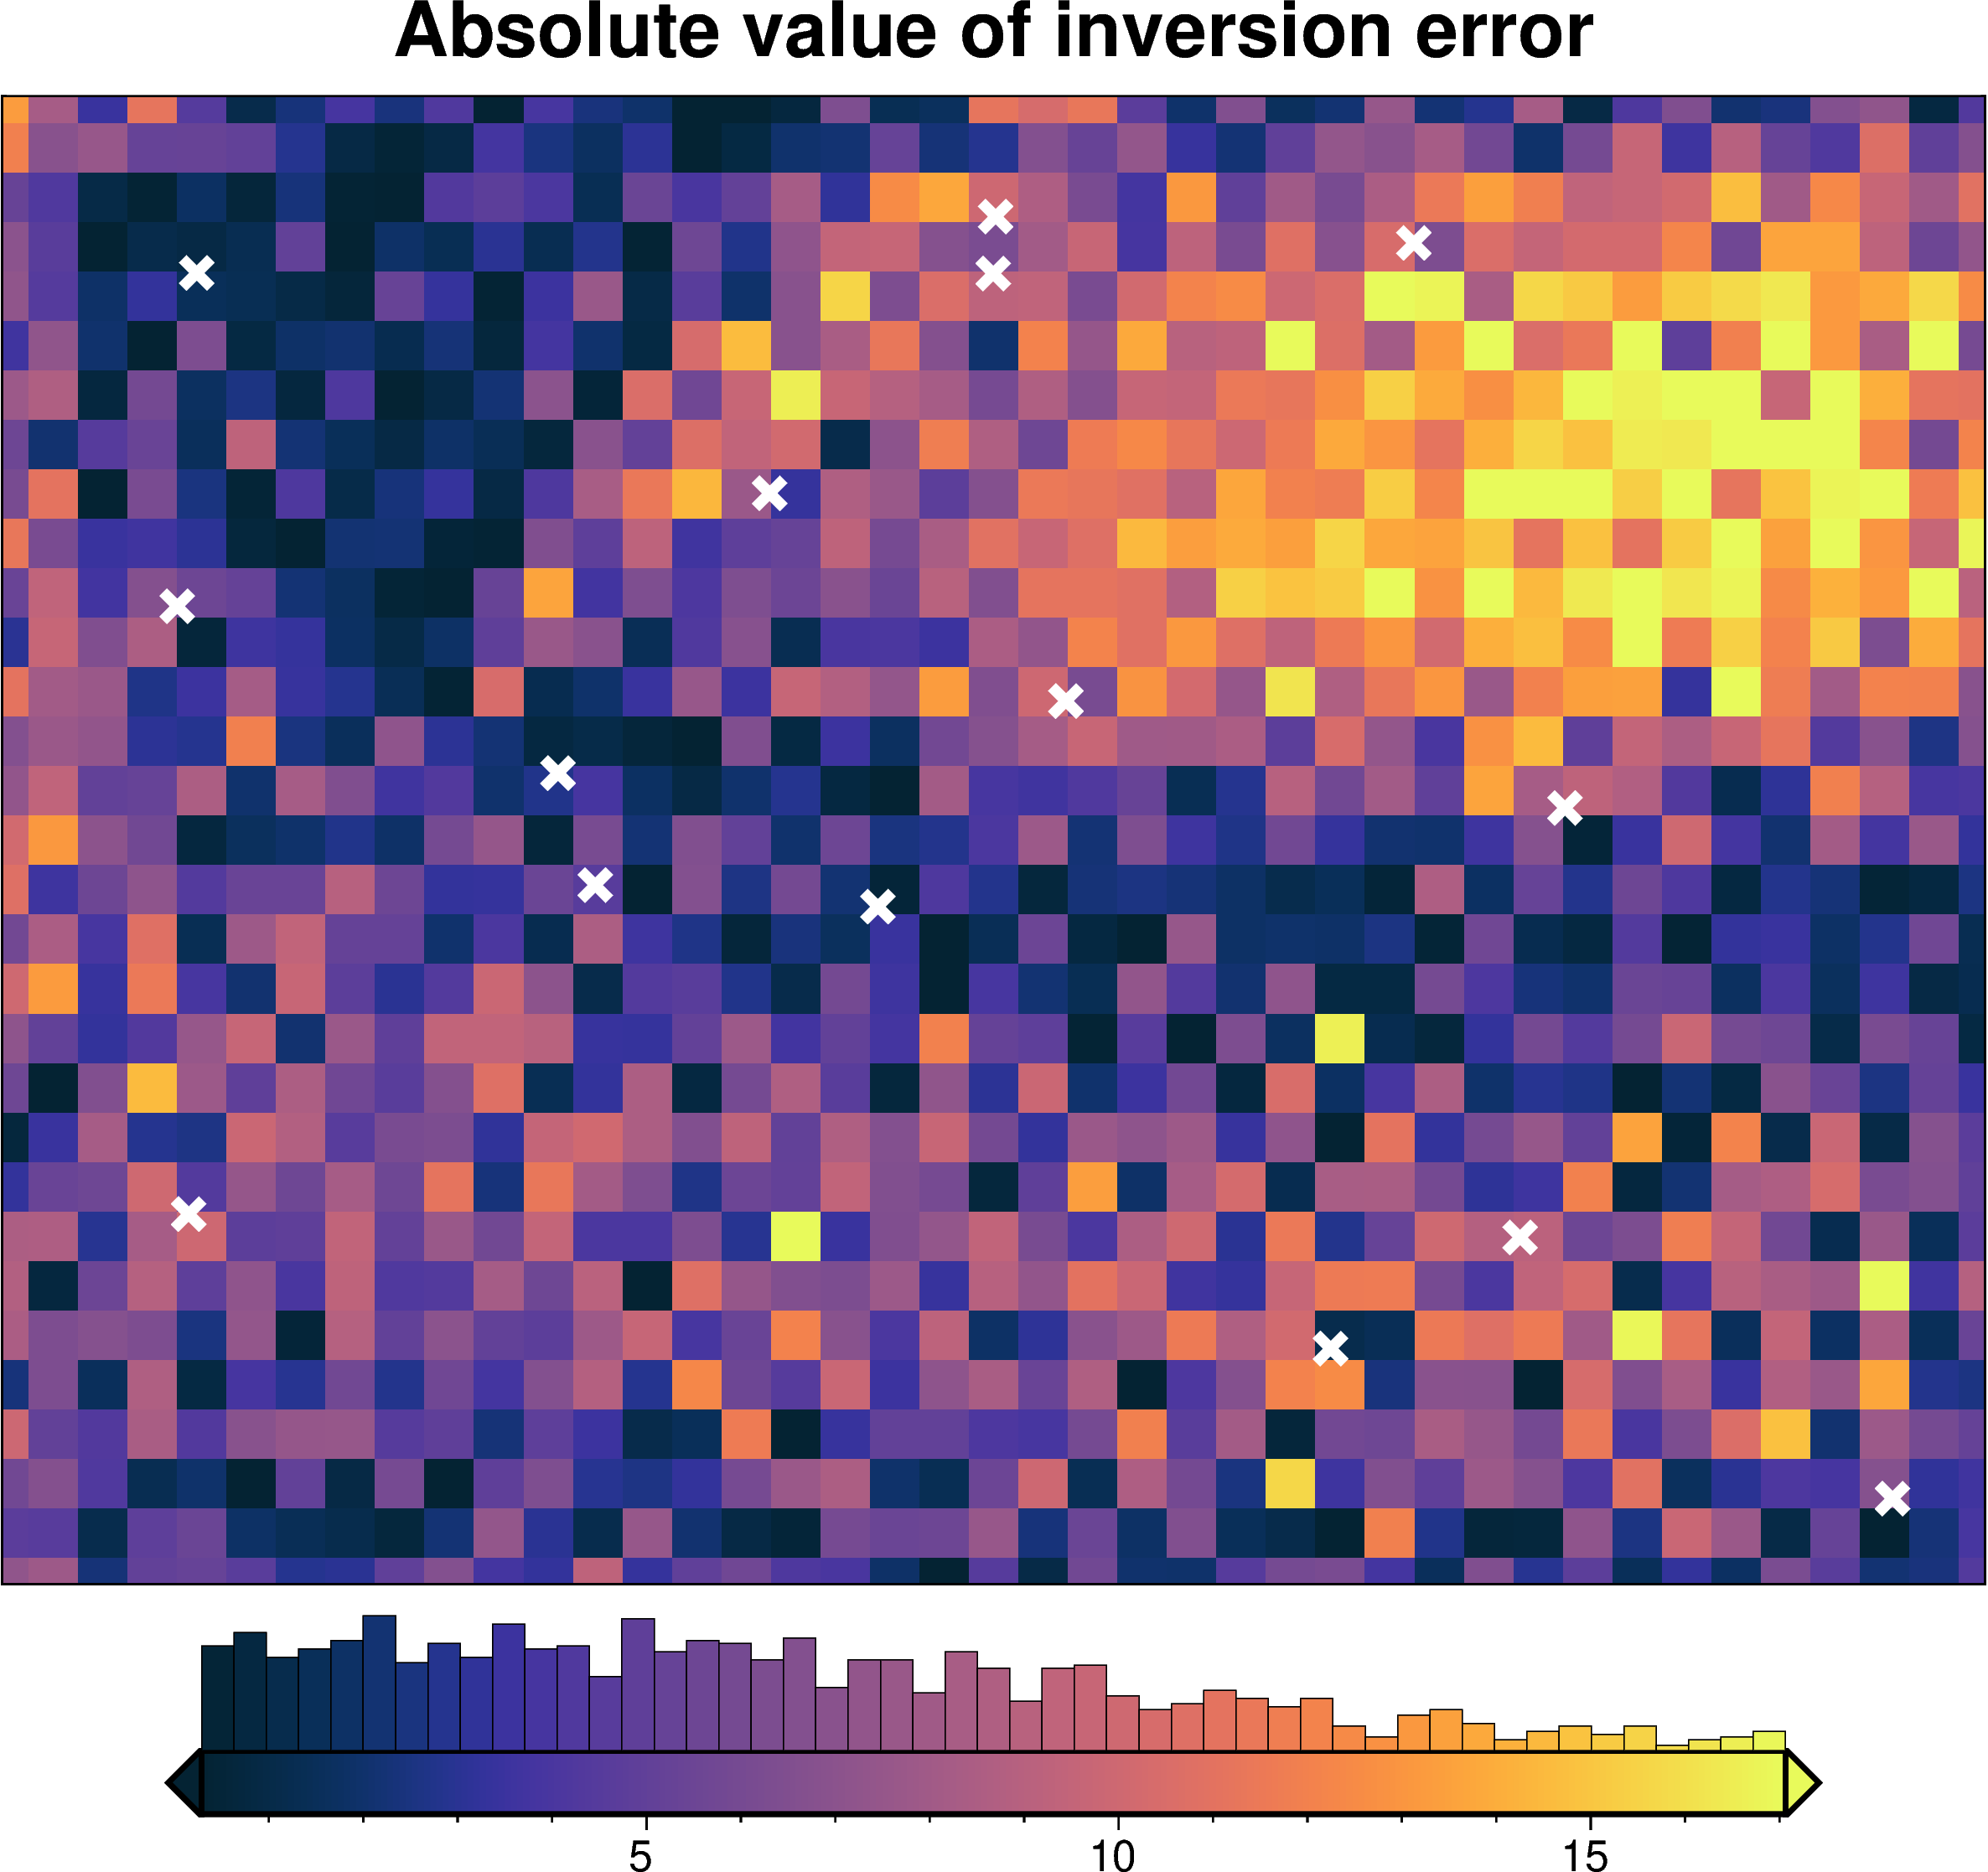

In [13]:
inversion_error = np.abs(true_topography - final_topography)
fig = maps.plot_grd(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.4c,",
    points_pen="3p",
    points_fill="white",
)
fig.show()

# Redo starting gravity and regional separation
use the optimal determined density contrast and zref values

In [14]:
# set the reference level from the prisms to 0
density_grid = xr.where(
    starting_topography >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# regional separation
temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)

# temporarily set some kwargs
# temp_reg_kwargs["cv_kwargs"]["plot"]=True
temp_reg_kwargs["cv_kwargs"]["progressbar"] = True

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **temp_reg_kwargs,
)

grav_df["staring_res"] = grav_df.res
grav_df["starting_reg"] = grav_df.reg

grav_df.describe()

INFO:invert4geom:using 12 startup trials


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 41
INFO:invert4geom:	parameter: {'damping': 0.04881091466863527}
INFO:invert4geom:	scores: [-0.3044137588089442]


northing       easting  upward  upper_surface_grav  \
count   4941.000000   4941.000000  4941.0         4941.000000   
mean   15000.000000  20000.000000  1001.0           -0.229678   
std     8804.299419  11691.635129     0.0            7.103507   
min        0.000000      0.000000  1001.0          -17.227928   
25%     7500.000000  10000.000000  1001.0           -5.587227   
50%    15000.000000  20000.000000  1001.0           -1.239580   
75%    22500.000000  30000.000000  1001.0            3.490030   
max    30000.000000  40000.000000  1001.0           19.754954   

       lower_surface_grav  observed_grav  gravity_anomaly        uncert  \
count         4941.000000    4941.000000      4941.000000  4.941000e+03   
mean             0.004286      -0.225392        -0.225332  1.000000e-01   
std              0.720692       7.247722         7.245591  1.064189e-10   
min             -1.034071     -16.940400       -17.040892  1.000000e-01   
25%             -0.610336      -5.906763        -5.910496  1.000000e-01   
50%             -0.155380      -0.822890        -0.813296  1.000000e-01   
75%              0.542849       3.738912         3.726649  1.000000e-01   
max              1.602413      19.932831        19.959187  1.000000e-01   

       starting_gravity     true_res       misfit          reg          res  \
count       4941.000000  4941.000000  4941.000000  4941.000000  4941.000000   
mean           0.517690    -1.254871    -0.743022    -0.134885    -0.608137   
std            7.538787     4.621594     5.076524     1.376126     4.572632   
min           -9.430753   -19.592049   -20.057107    -2.560355   -18.518955   
25%           -5.500220    -3.008015    -2.800362    -1.230061    -2.338344   
50%           -1.442872    -1.483188    -1.207388    -0.191240    -0.616647   
75%            5.248543     0.577570     1.437138     1.026287     1.260866   
max           25.047338    13.969991    15.352249     2.279162    14.666685   

       staring_res  starting_reg  
count  4941.000000   4941.000000  
mean     -0.608137     -0.134885  
std       4.572632      1.376126  
min     -18.518955     -2.560355  
25%      -2.338344     -1.230061  
50%      -0.616647     -0.191240  
75%       1.260866      1.026287  
max      14.666685      2.279162

In [15]:
# plotting functions for uncertainty results
def uncert_plots(
    results,
    inversion_region,
    spacing,
    true_topography,
    constraint_points=None,
    weight_by=None,
):
    if (weight_by == "constraints") & (constraint_points is None):
        msg = "must provide constraint_points if weighting by constraints"
        raise ValueError(msg)

    stats_ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by=weight_by,
        region=inversion_region,
    )

    try:
        mean = stats_ds.weighted_mean
        stdev = stats_ds.weighted_stdev
    except AttributeError:
        mean = stats_ds.z_mean
        stdev = stats_ds.z_stdev

    _ = polar_utils.grd_compare(
        true_topography,
        mean,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points,
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - mean),
        stdev,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        cmap="thermal",
        robust=True,
        hist=True,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
        points_fill="white",
    )
    return stats_ds

# Uncertainty analysis

In [16]:
# get mean spacing between nearest constraints
mean_spacing = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing),
        k_nearest=1,
    )
)
mean_spacing

np.float64(5599.156508868462)

In [17]:
# use optimal eq source parameters for regional separation in uncertainty analysis
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]

reg_eq_depth = 4.5 * mean_spacing

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)
reg_eq_damping, reg_eq_depth

(0.04881091466863527, np.float64(25196.204289908077))

In [18]:
# add best damping parameter to kwargs
kwargs["solver_damping"] = solver_damping

# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    regional_grav_kwargs=new_regional_grav_kwargs,
    **kwargs,
)

## Solver damping component
To estimate the uncertainty of the choice of solver damping value, we will load the damping cross validation and calculate the standard deviation of the trials (excluding outliers)

In [19]:
# load study
with pathlib.Path("../tmp/combining_it_all_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df.sort_values("value", inplace=True)

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = .1
print(f"using stdev: {stdev}")

calculated stdev: 0.6606916434963407
using stdev: 0.6606916434963407


best: 0.02239318117126179 
std: 0.6606916434963407 
+1std: 0.10251972610850342 
-1std: 0.004891298309149119


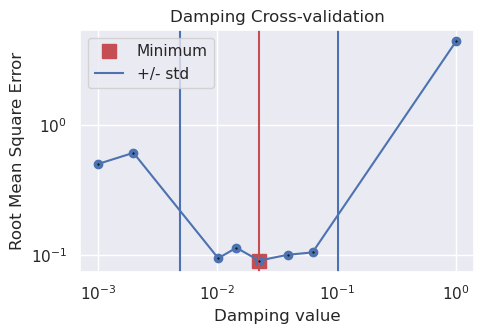

In [20]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.055707812123413136, min: 0.0018338961875135225, max: 0.2734367225272699
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_damping'



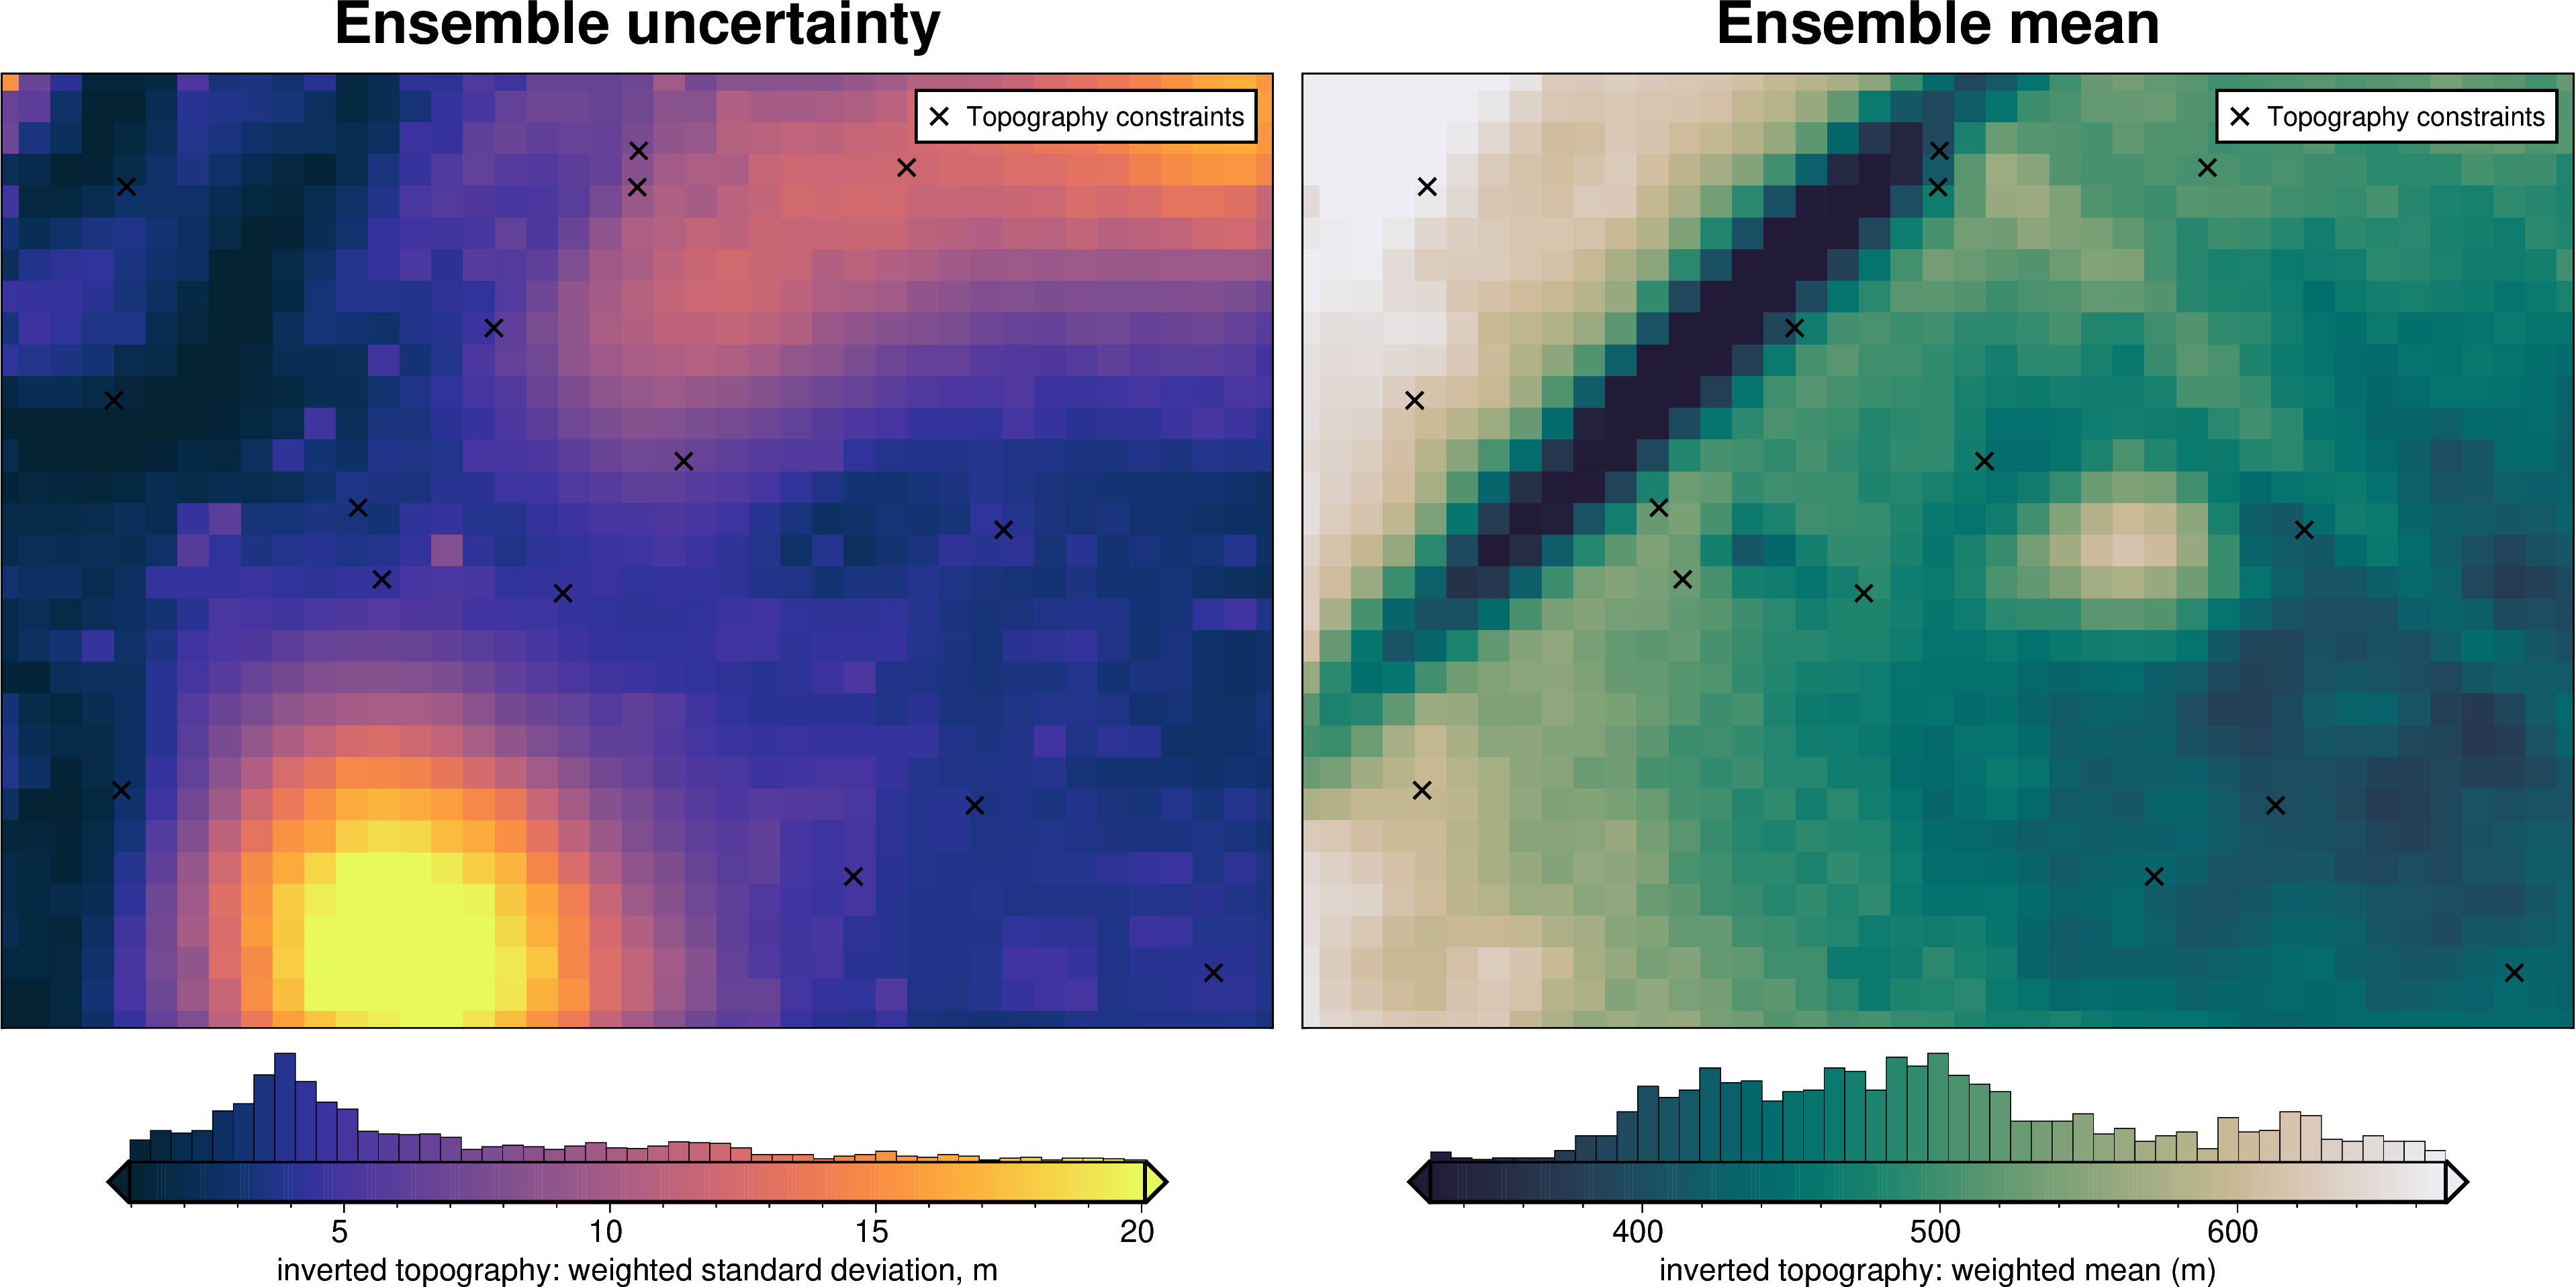

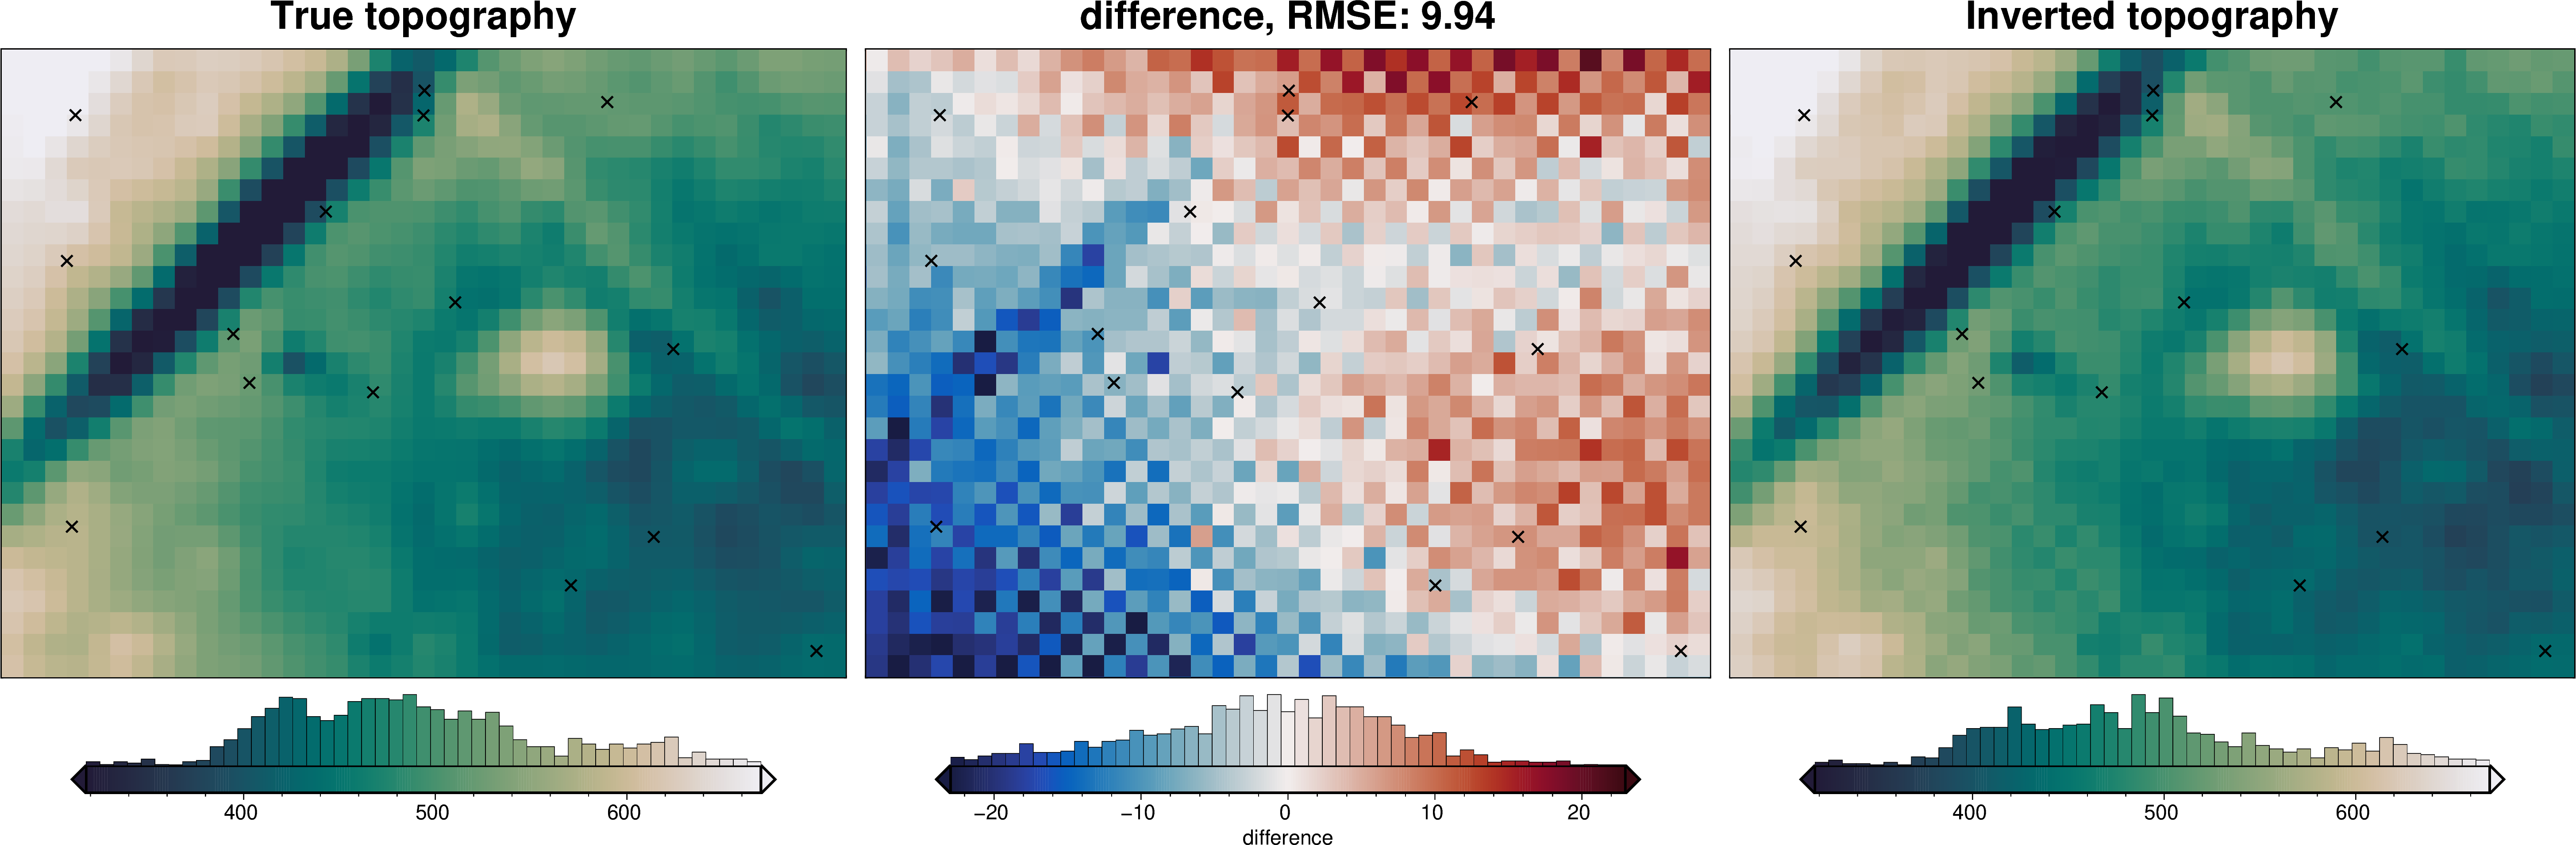

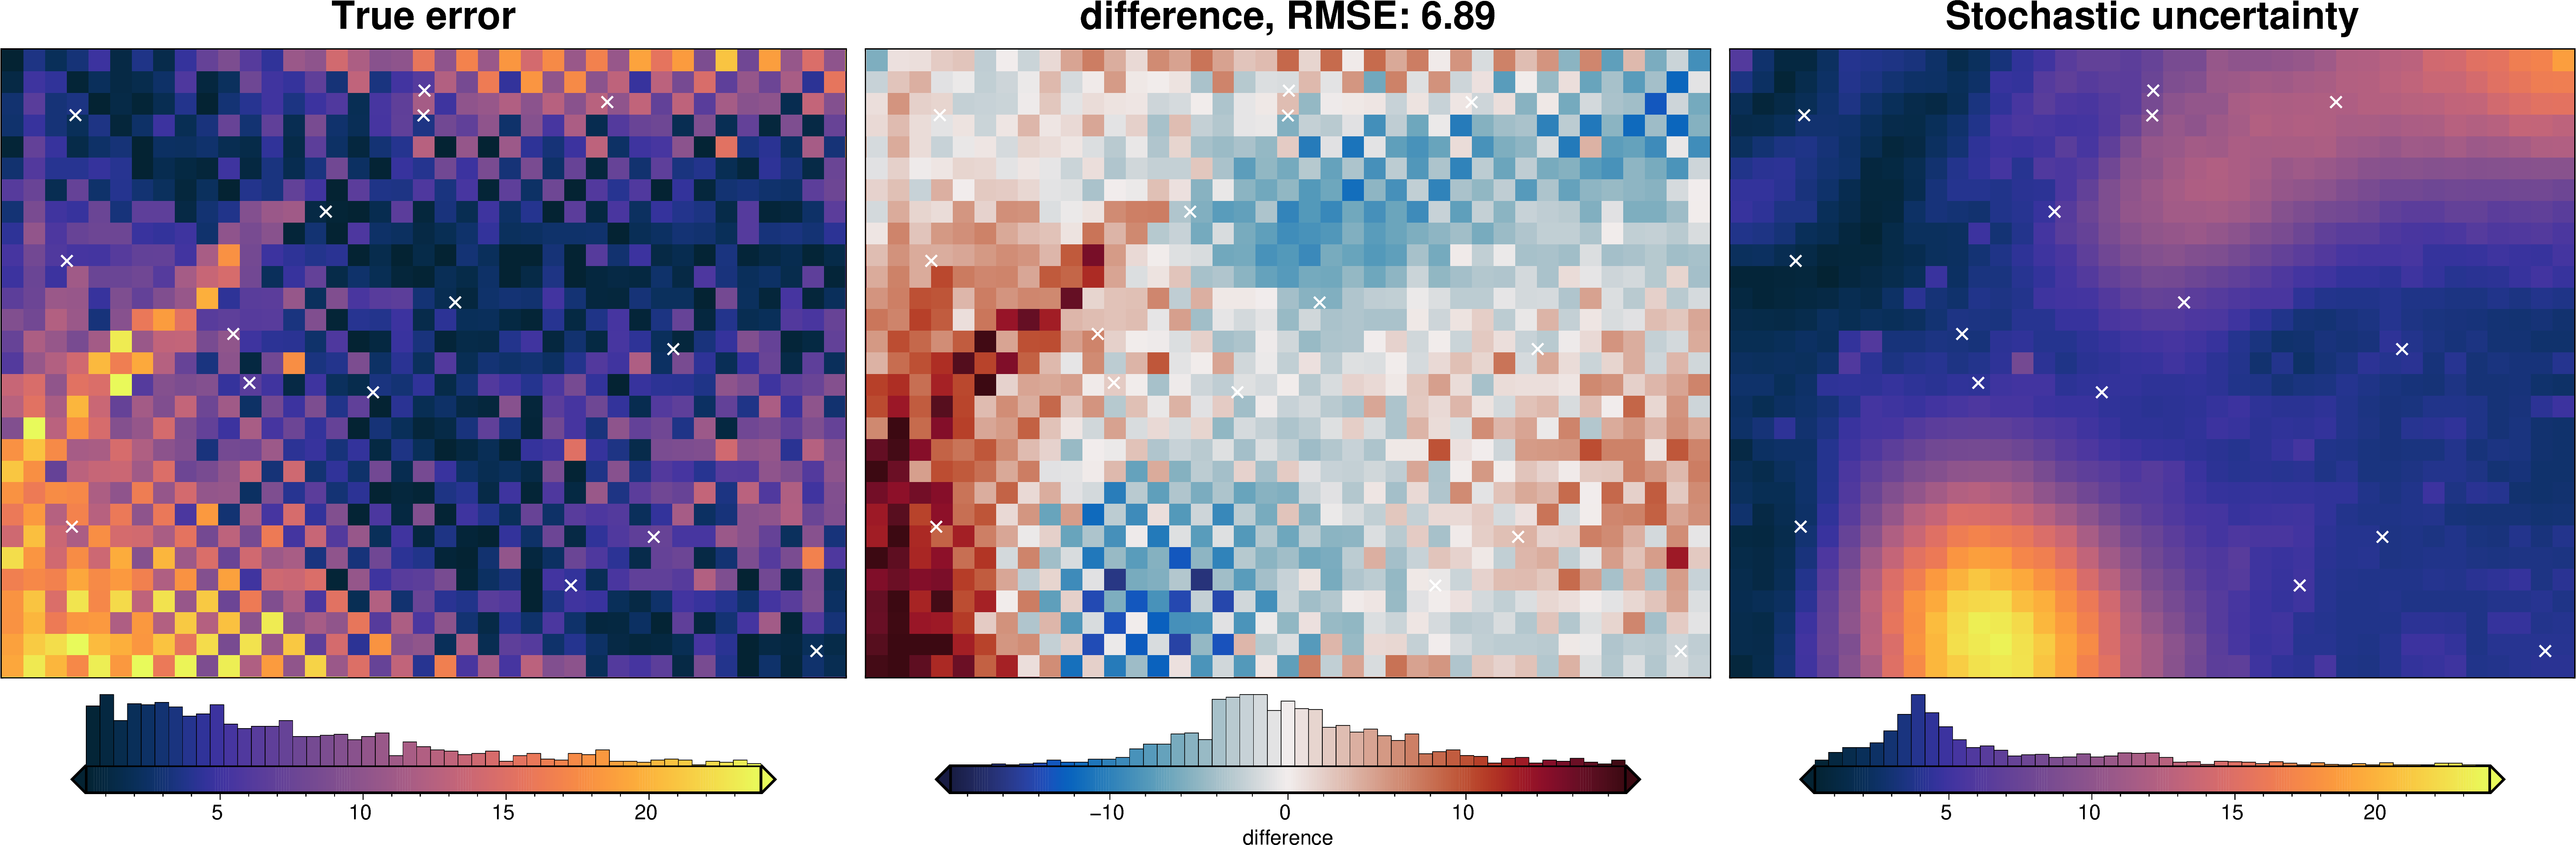

In [22]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../tmp/uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_damping_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Z-ref and density components
To estimate the uncertainty of the choice of Z-ref and density value, we will sample the values from random distributions.

best: 492.79238528548717 
std: 50 
+1std: 542.7923852854872 
-1std: 442.79238528548717
best: 2735.0 
std: 100 
+1std: 2835.0 
-1std: 2635.0


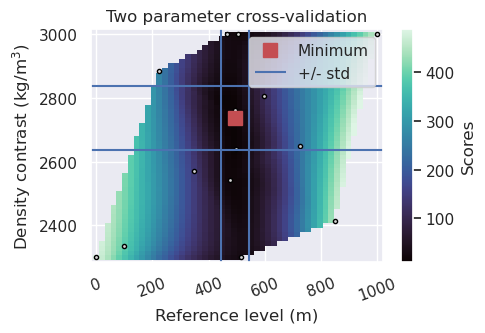

In [23]:
# choose standard deviations for the density contrast and zref
density_stdev = 100
zref_stdev = 50

# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_density_and_zref_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

plotting.plot_2_parameter_cv_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

ax = plt.gca()

# plot zref stdev
upper = zref + zref_stdev
lower = zref - zref_stdev
y_lims = ax.get_ylim()
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])
x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
print("best:", zref, "\nstd:", zref_stdev, "\n+1std:", upper, "\n-1std:", lower)

# plot density contrast stdev
upper = density_contrast + density_stdev
lower = density_contrast - density_stdev
x_lims = ax.get_xlim()
ax.hlines(upper, xmin=x_lims[0], xmax=x_lims[1])
ax.hlines(lower, xmin=x_lims[0], xmax=x_lims[1])
y_lims = ax.get_ylim()
ax.set_ylim(
    min(y_lims[0], lower),
    max(y_lims[1], upper),
)
ax.legend()
print(
    "best:",
    density_contrast,
    "\nstd:",
    density_stdev,
    "\n+1std:",
    upper,
    "\n-1std:",
    lower,
)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2735.0, min: 2570.514637304853, max: 2899.485362695147
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_density'



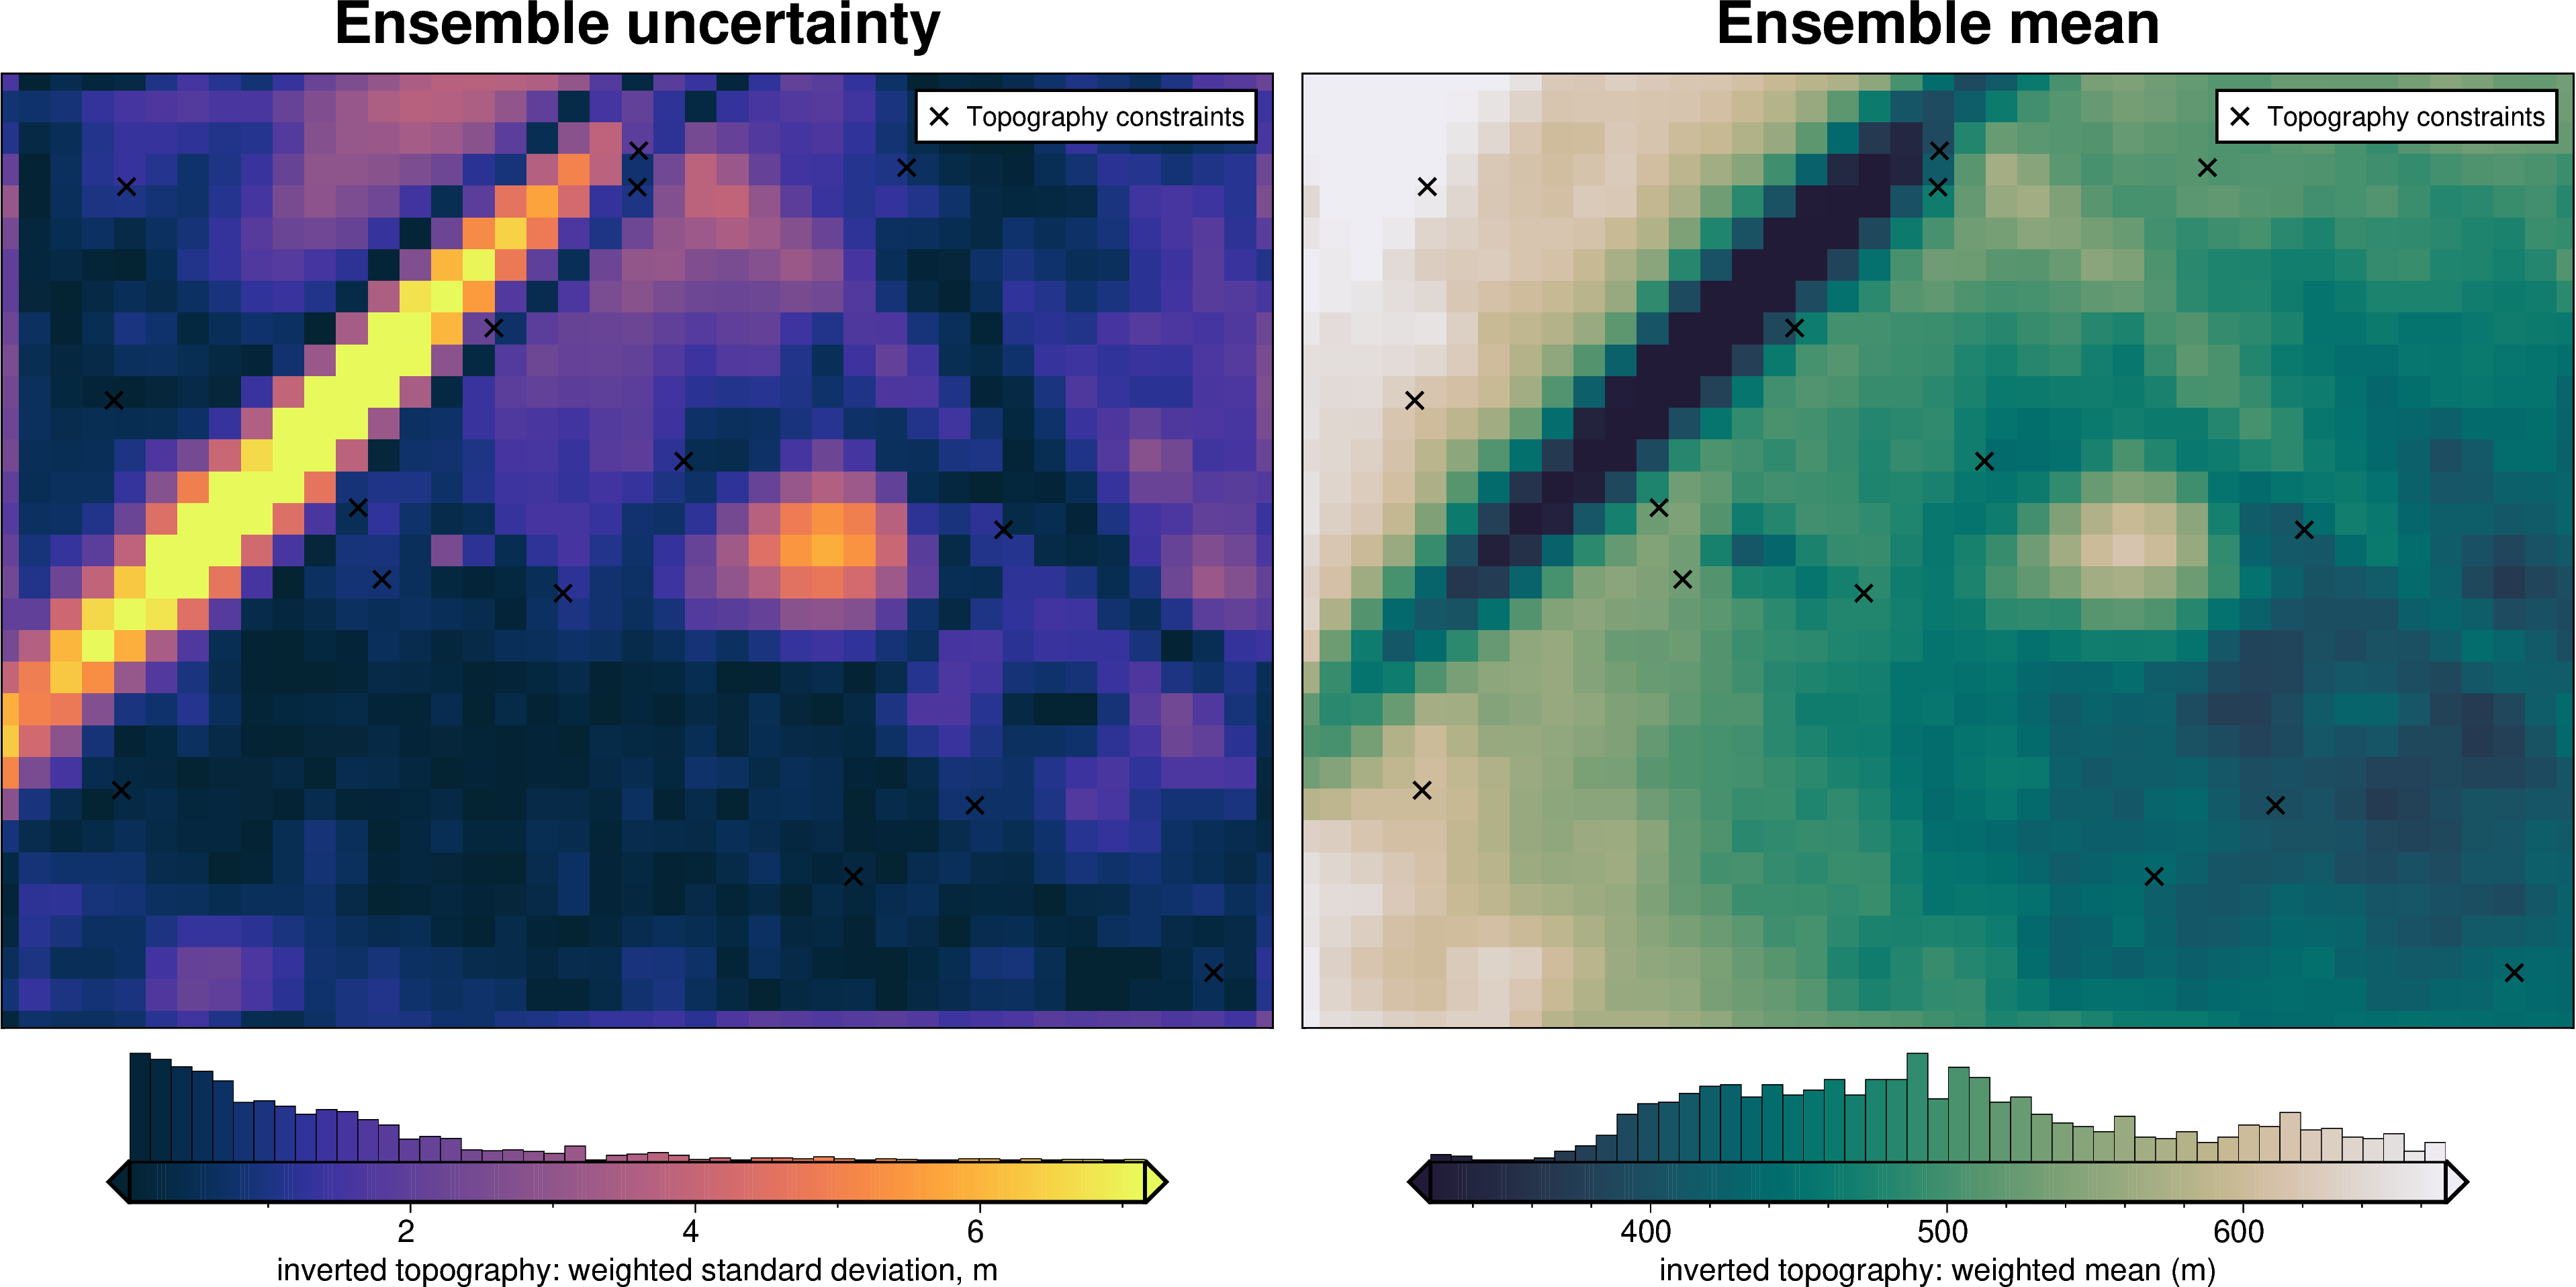

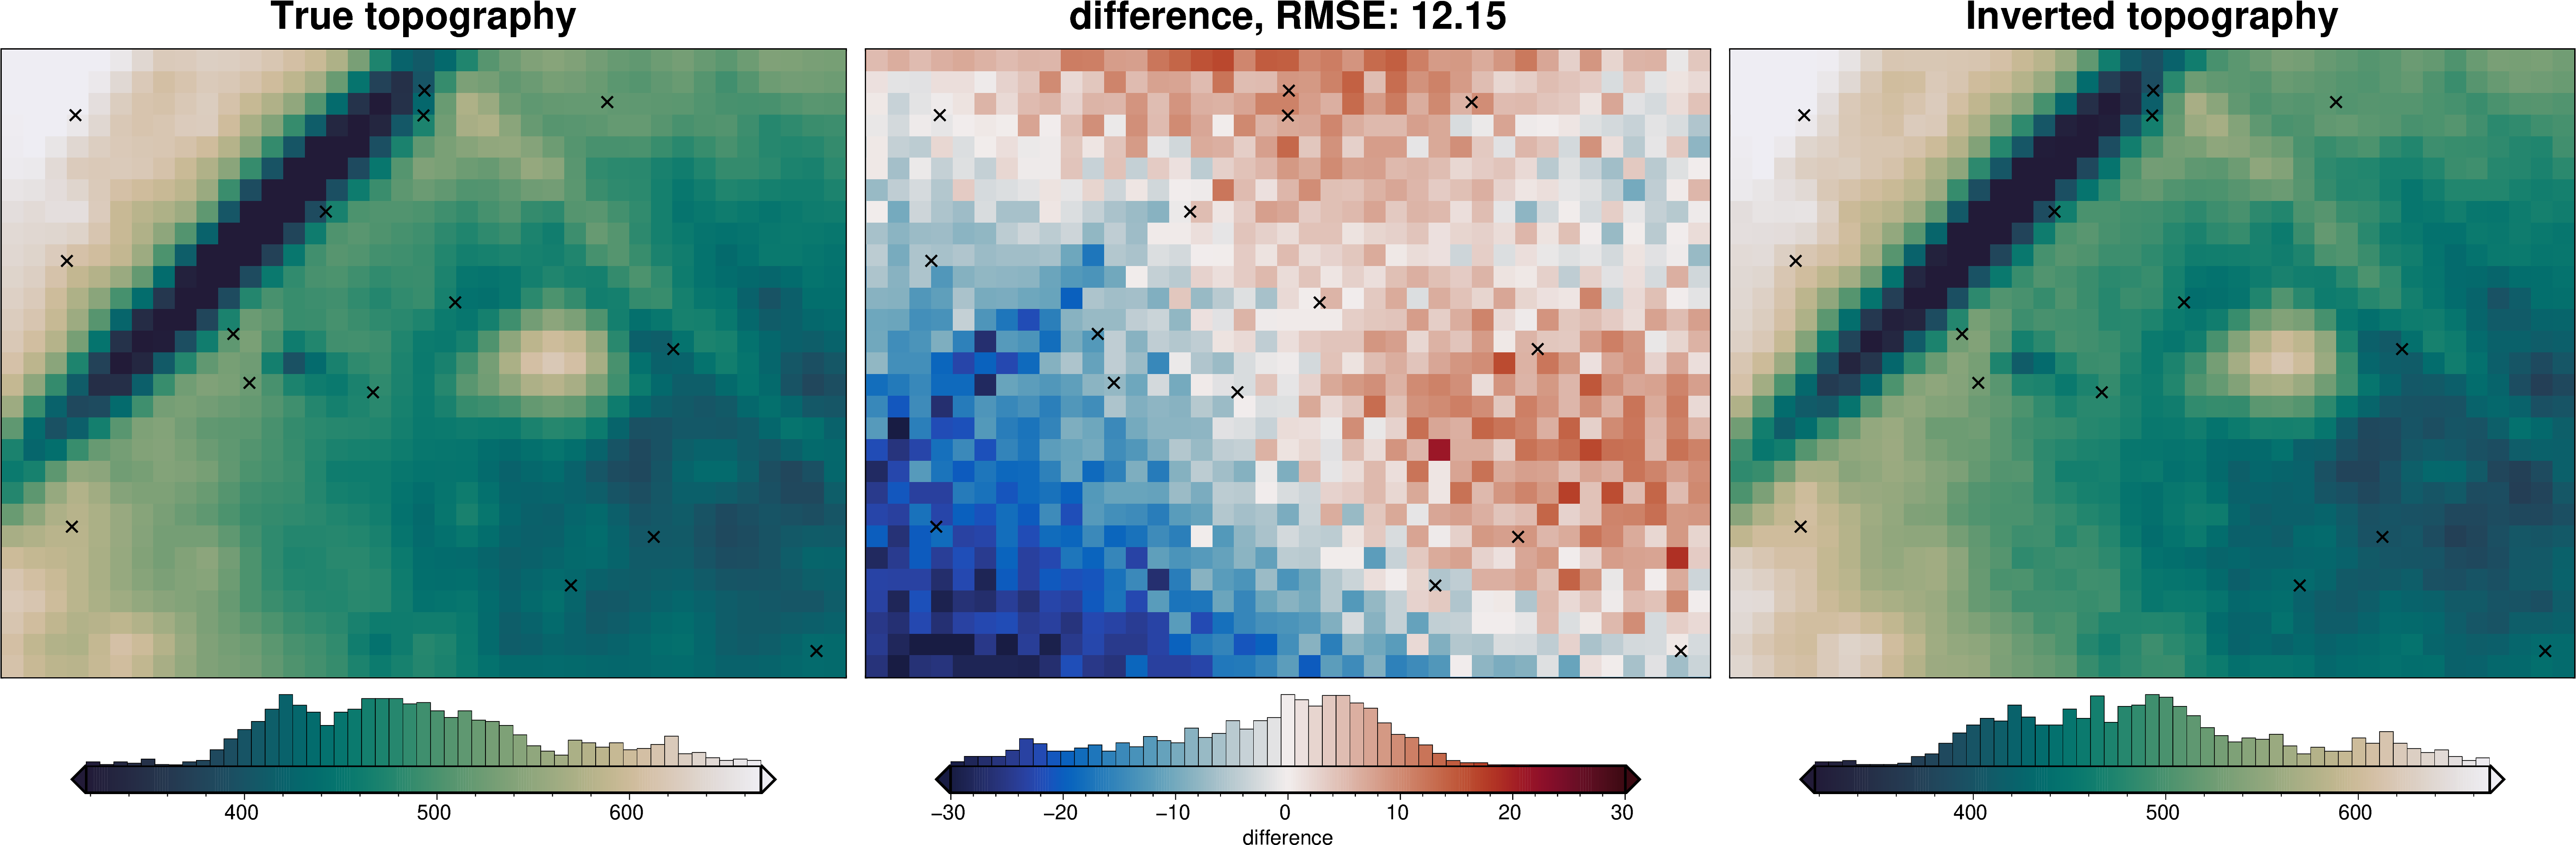

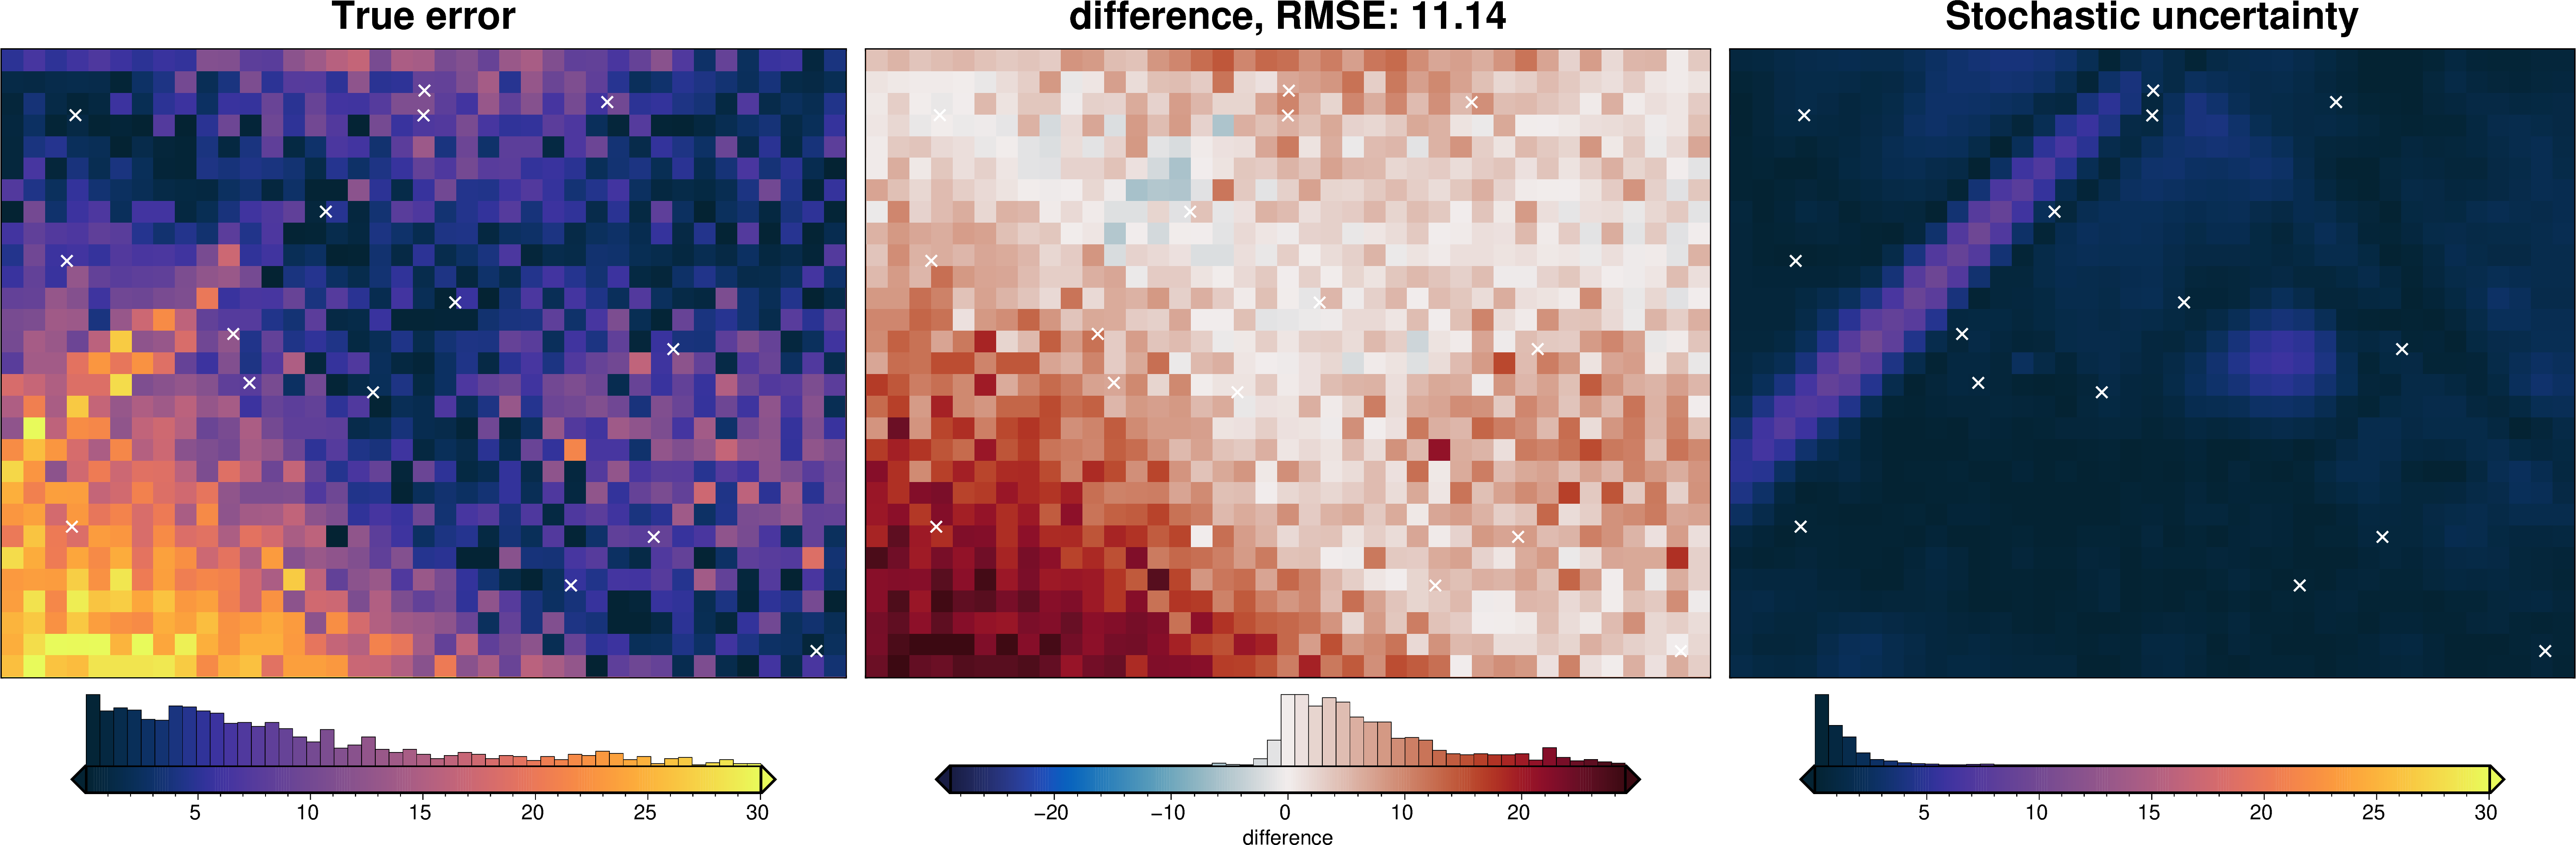

In [24]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": density_stdev,
    },
}
fname = "../tmp/uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_density_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

INFO:invert4geom:Sampled 'zref' parameter values; mean: 492.7923852854871, min: 410.54970393791353, max: 575.0350666330608
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_zref' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_zref'



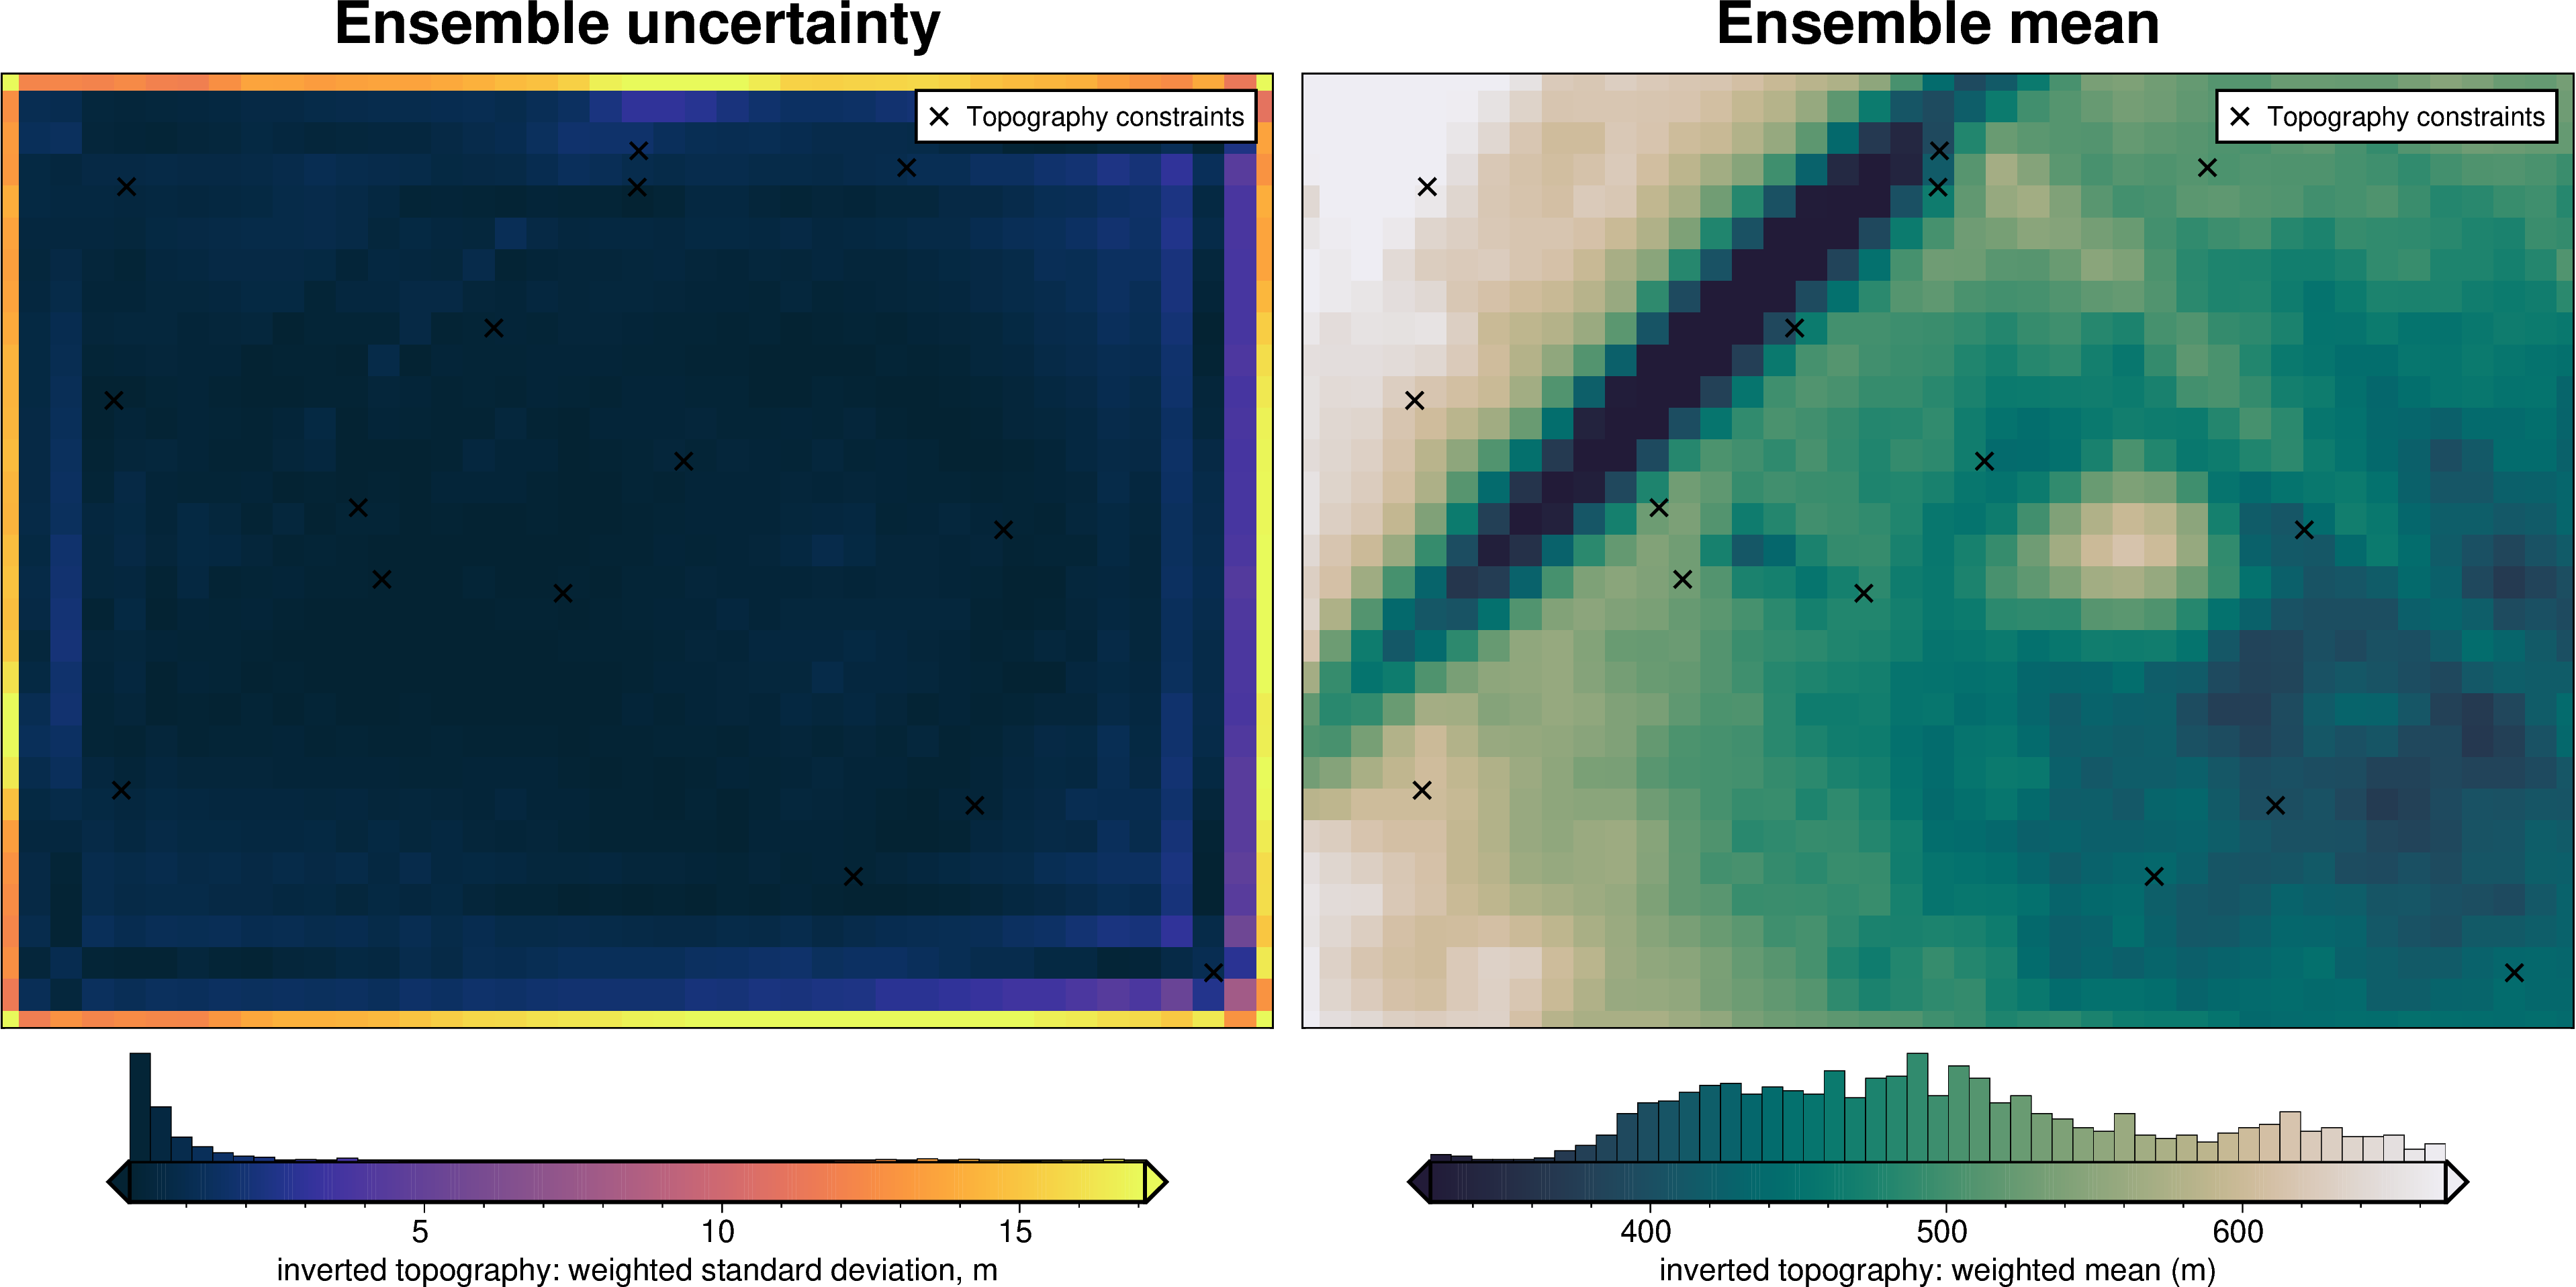

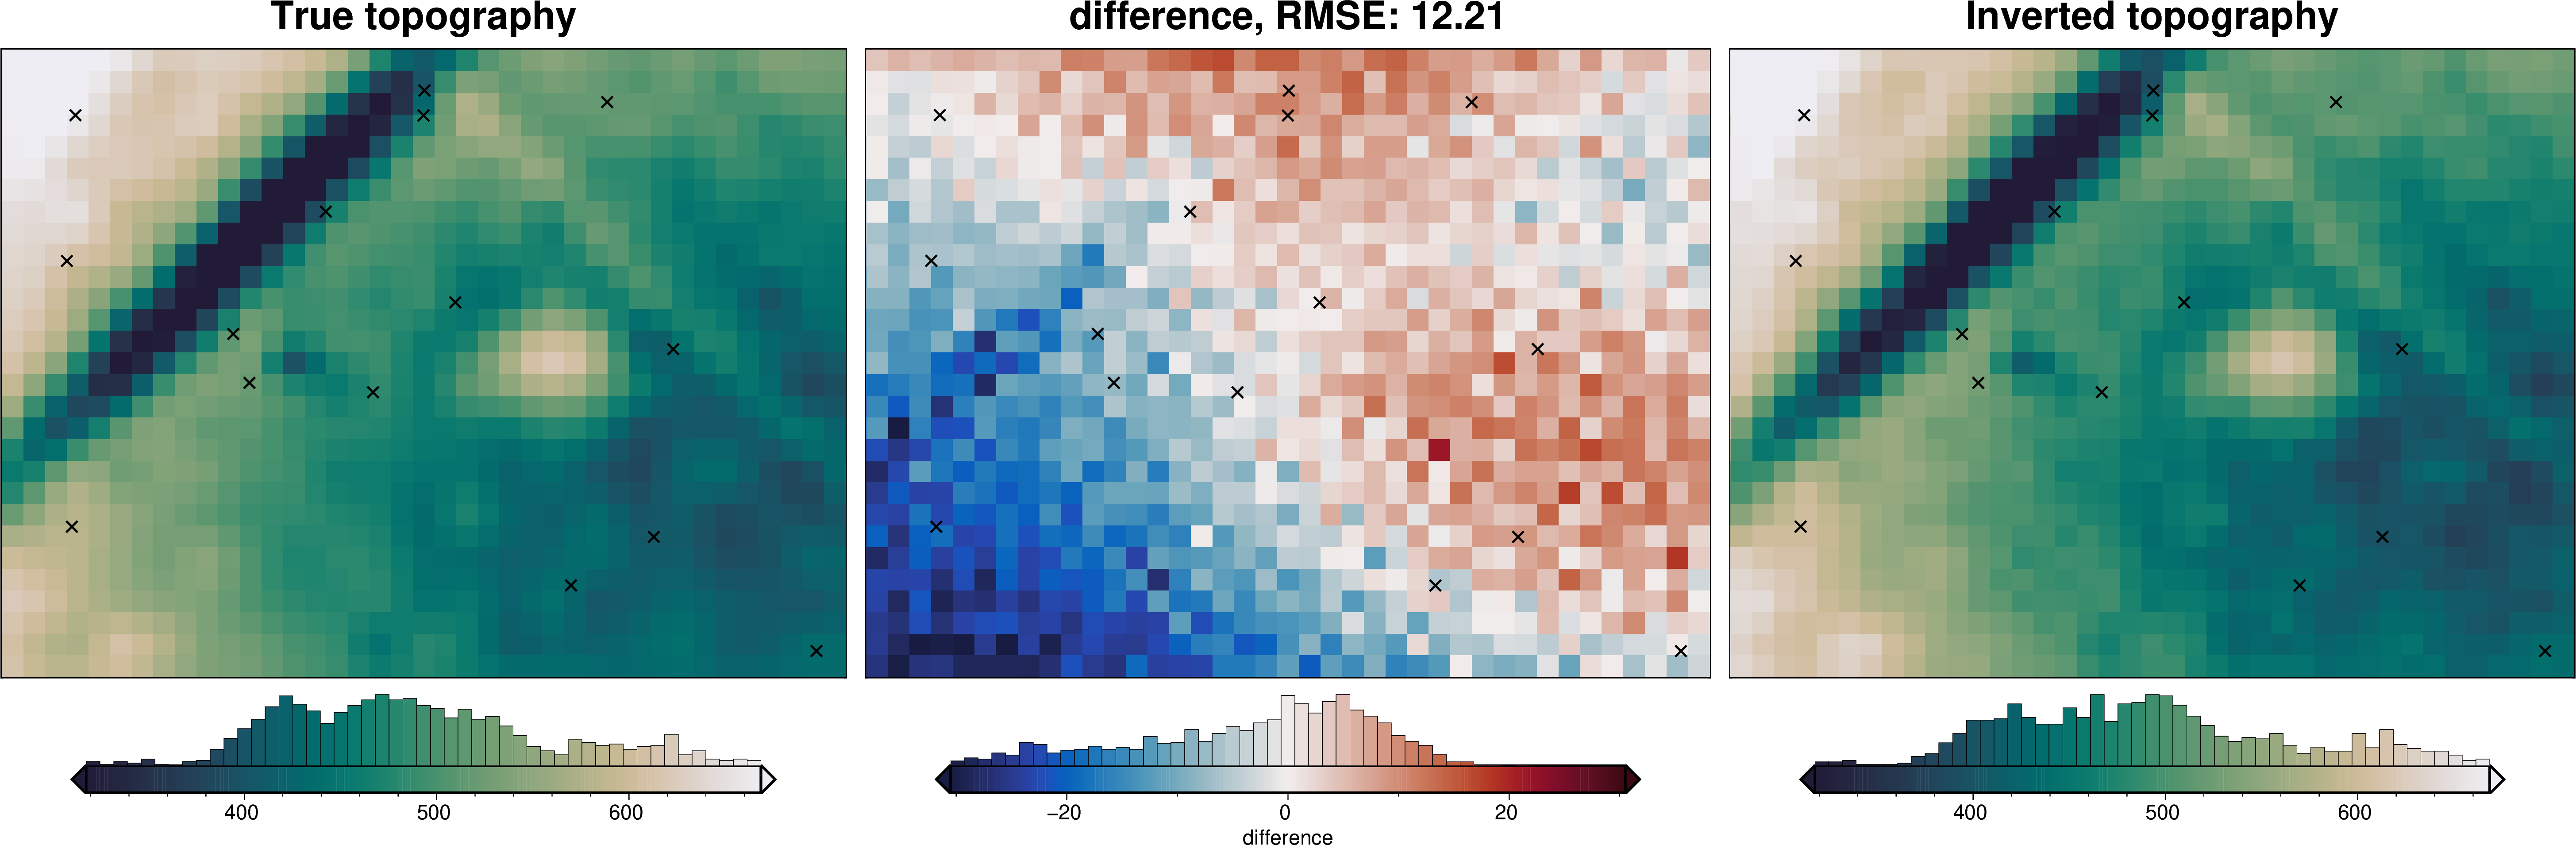

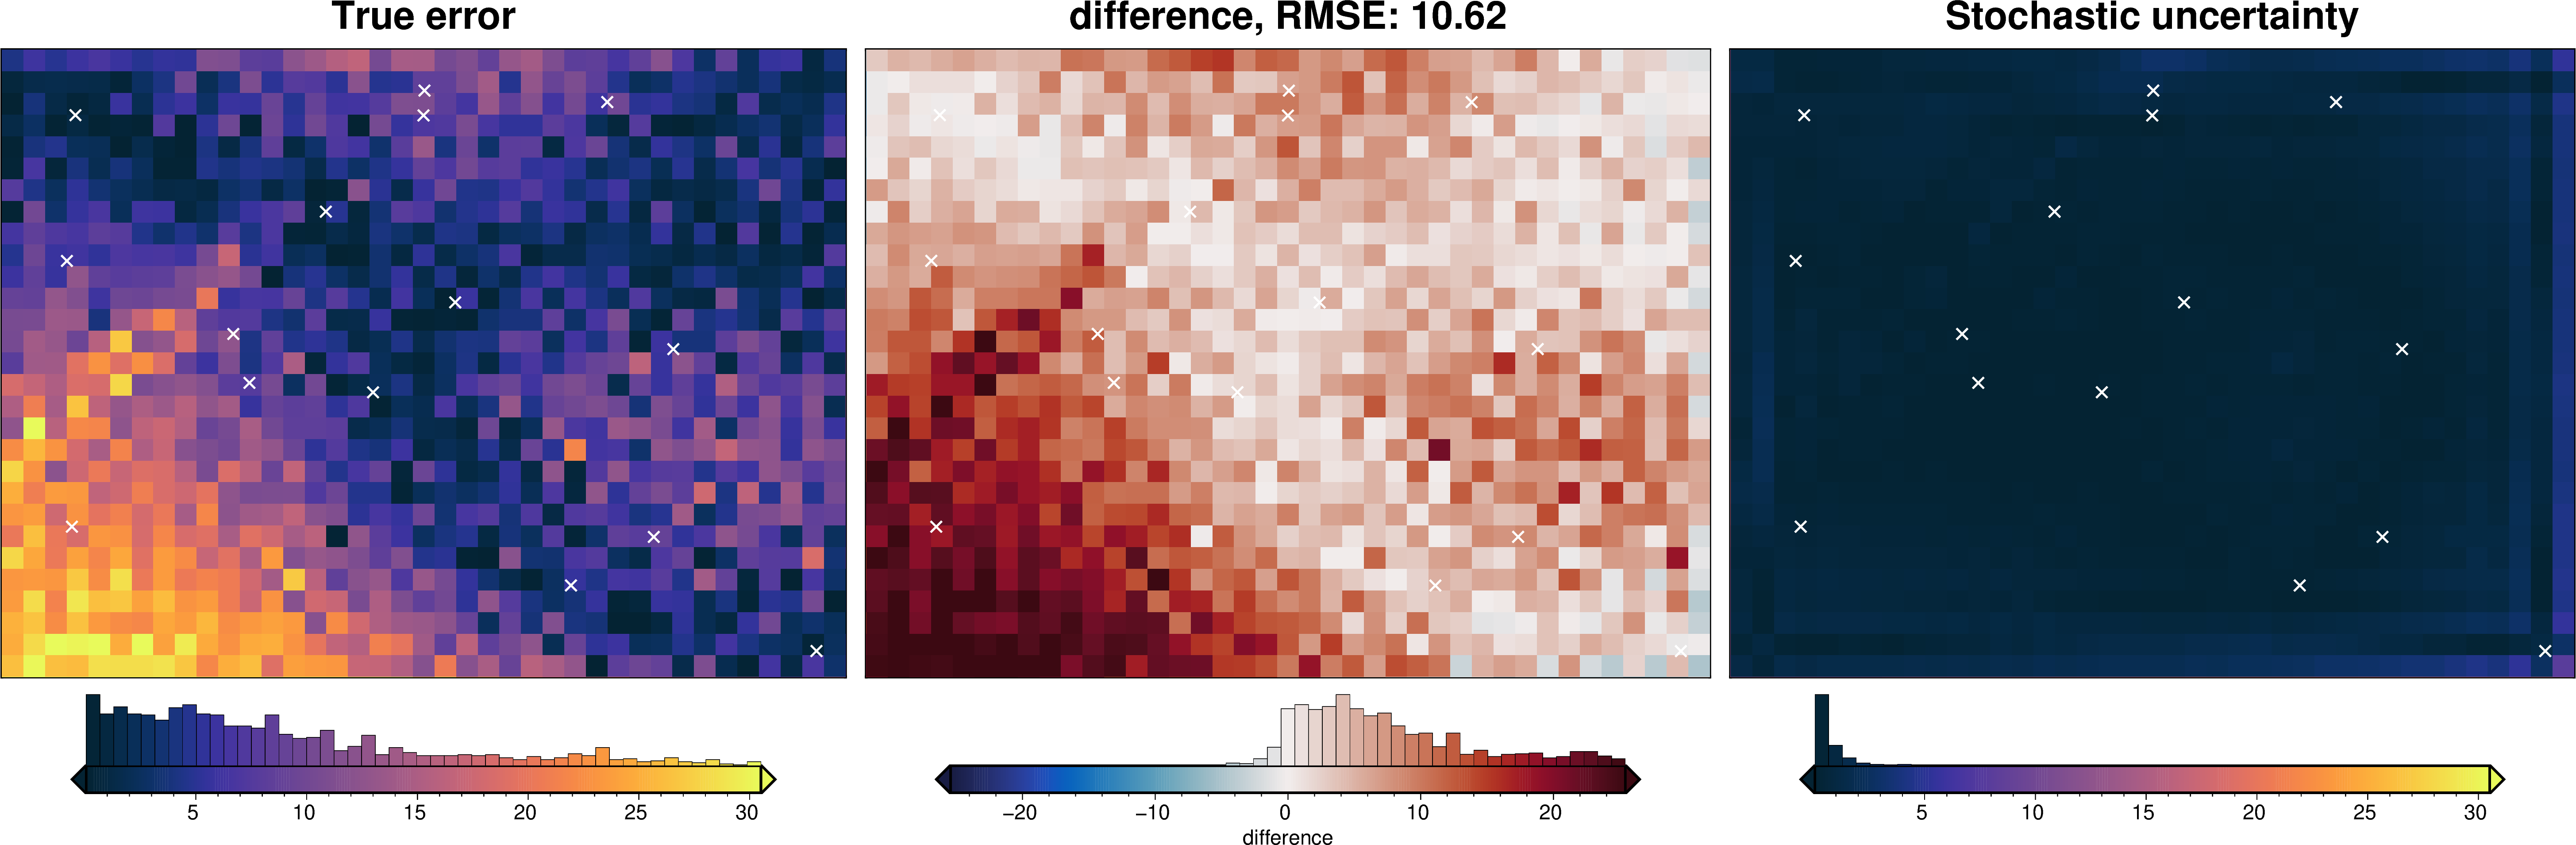

In [25]:
zref_dict = {
    "zref": {
        "distribution": "normal",
        "loc": zref,
        "scale": zref_stdev,
    },
}
fname = "../tmp/uncertainty_zref"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_zref_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=zref_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_zref_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Constraints component

INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_constraints'



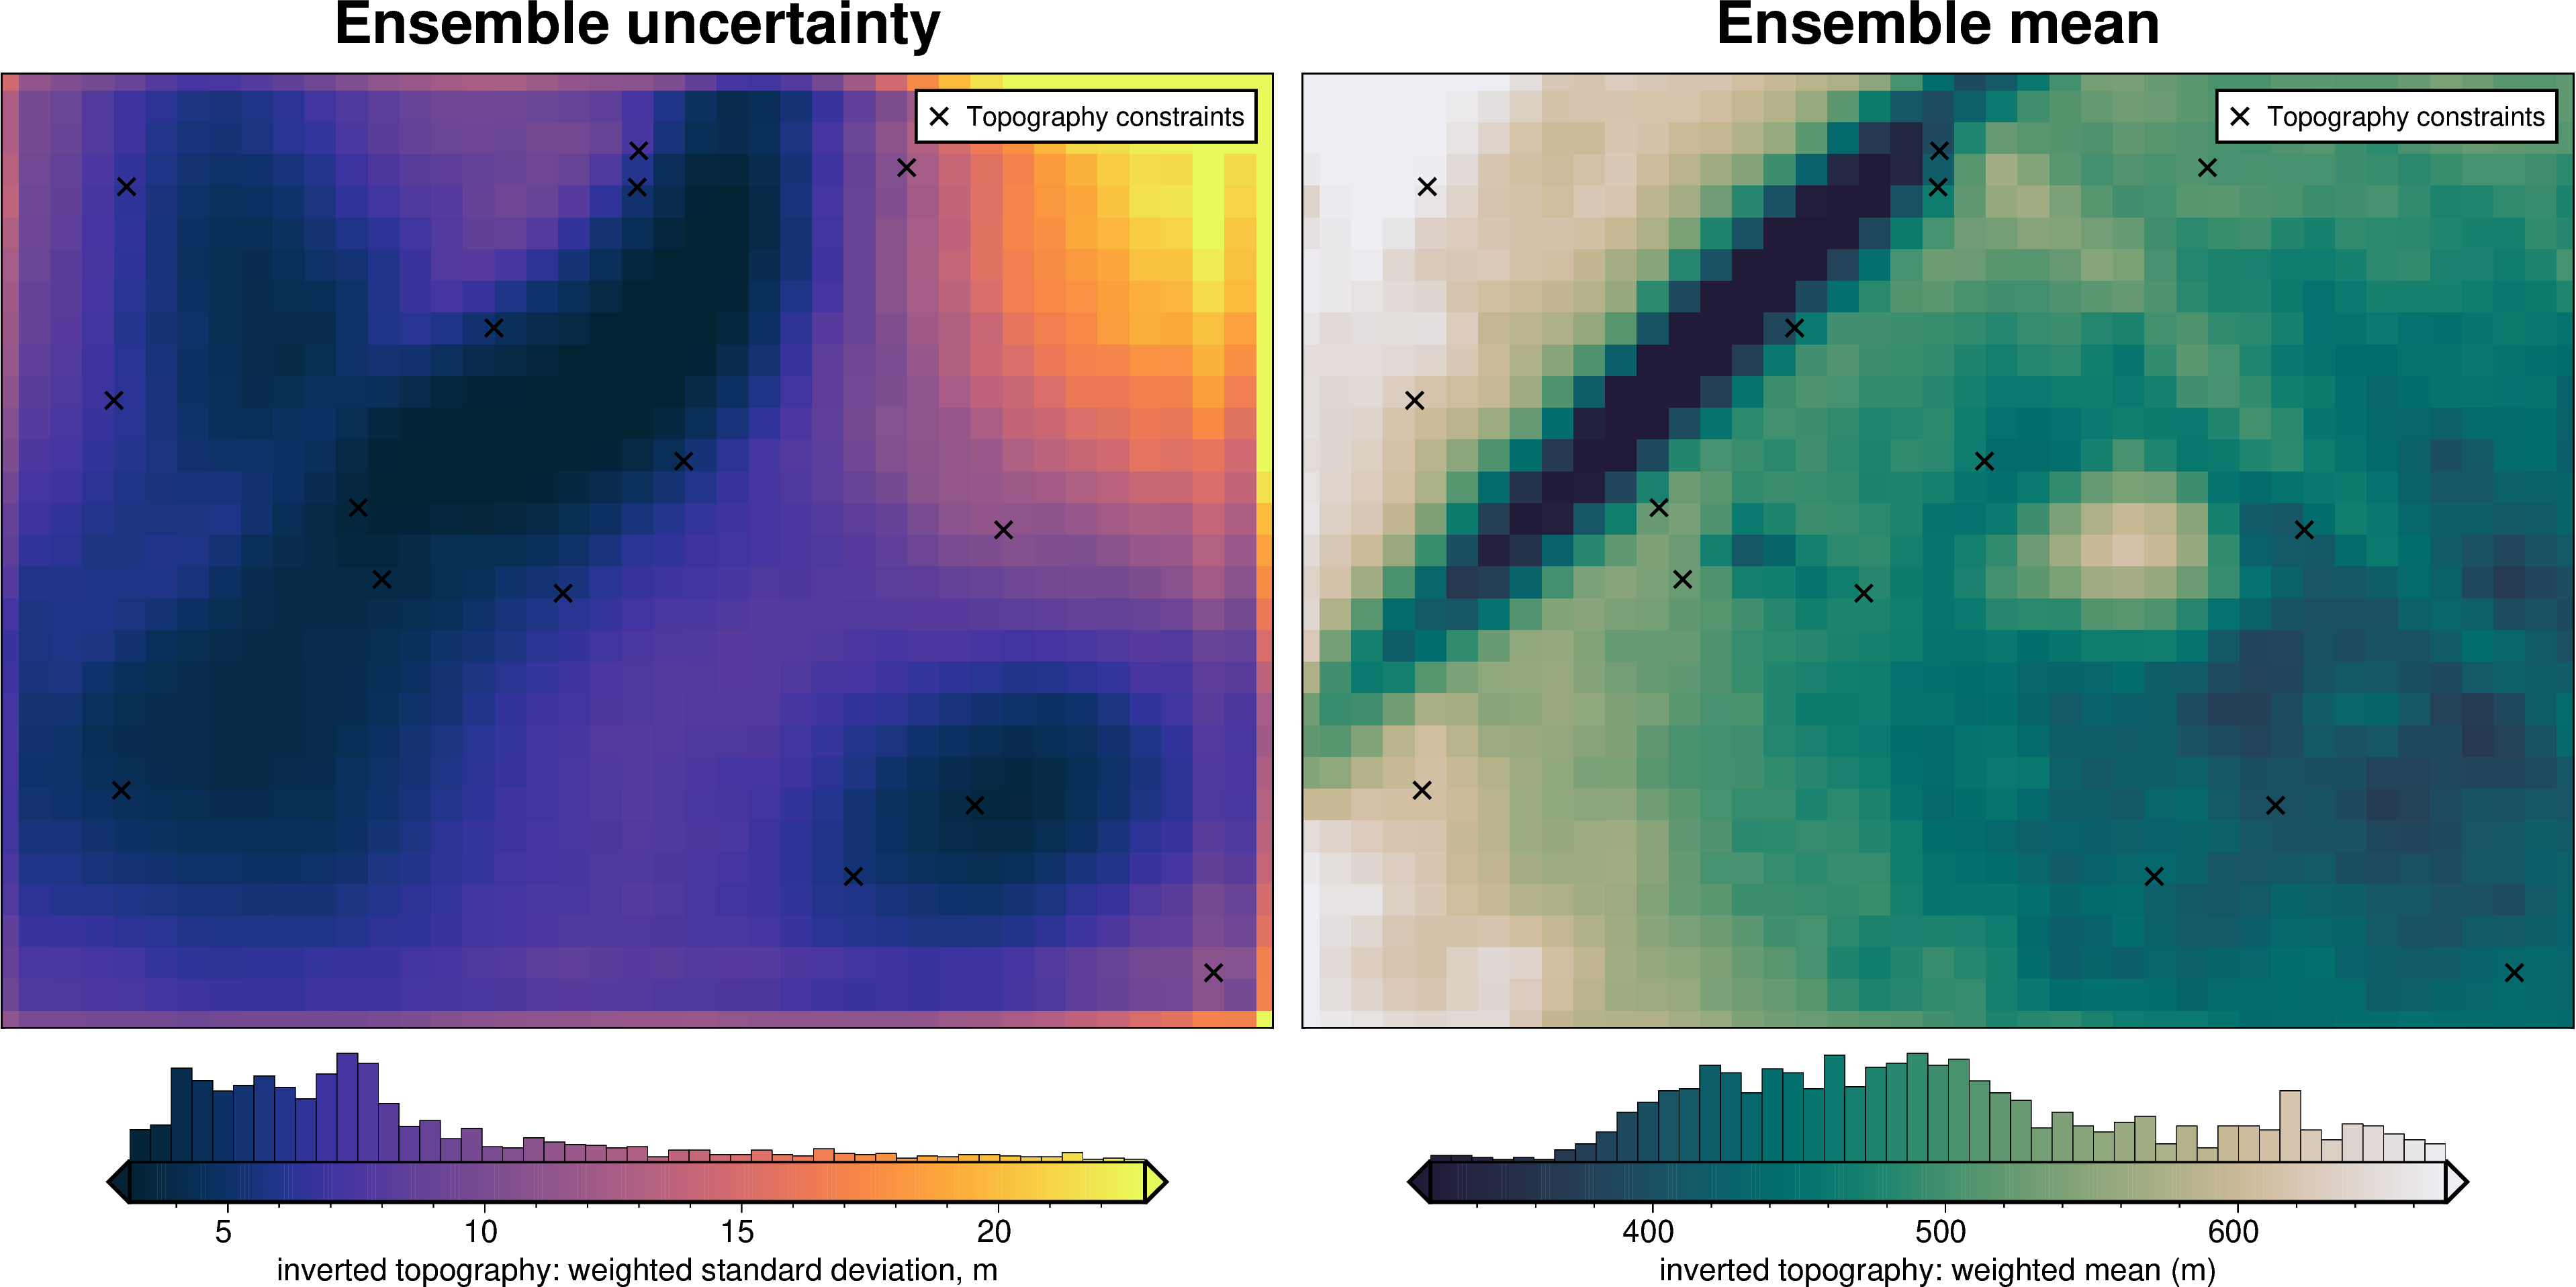

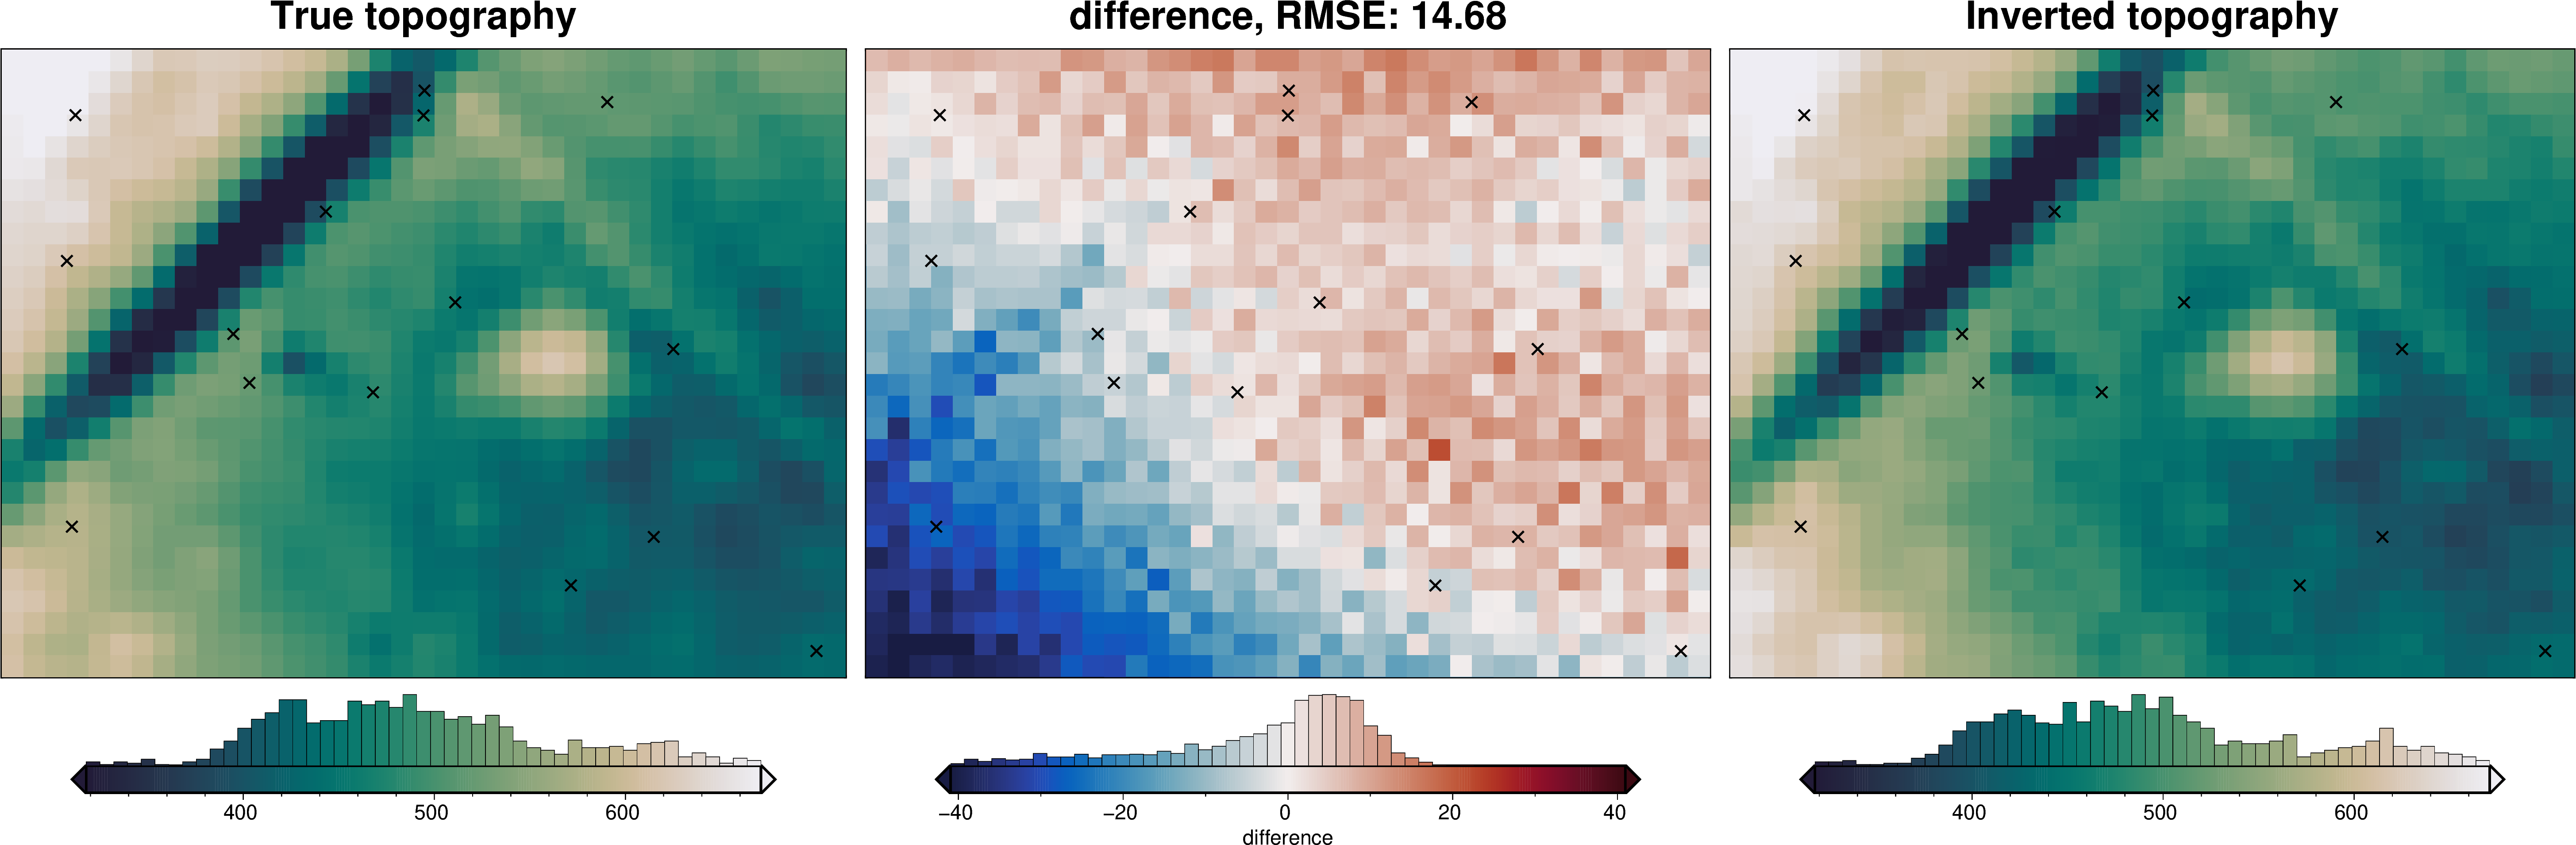

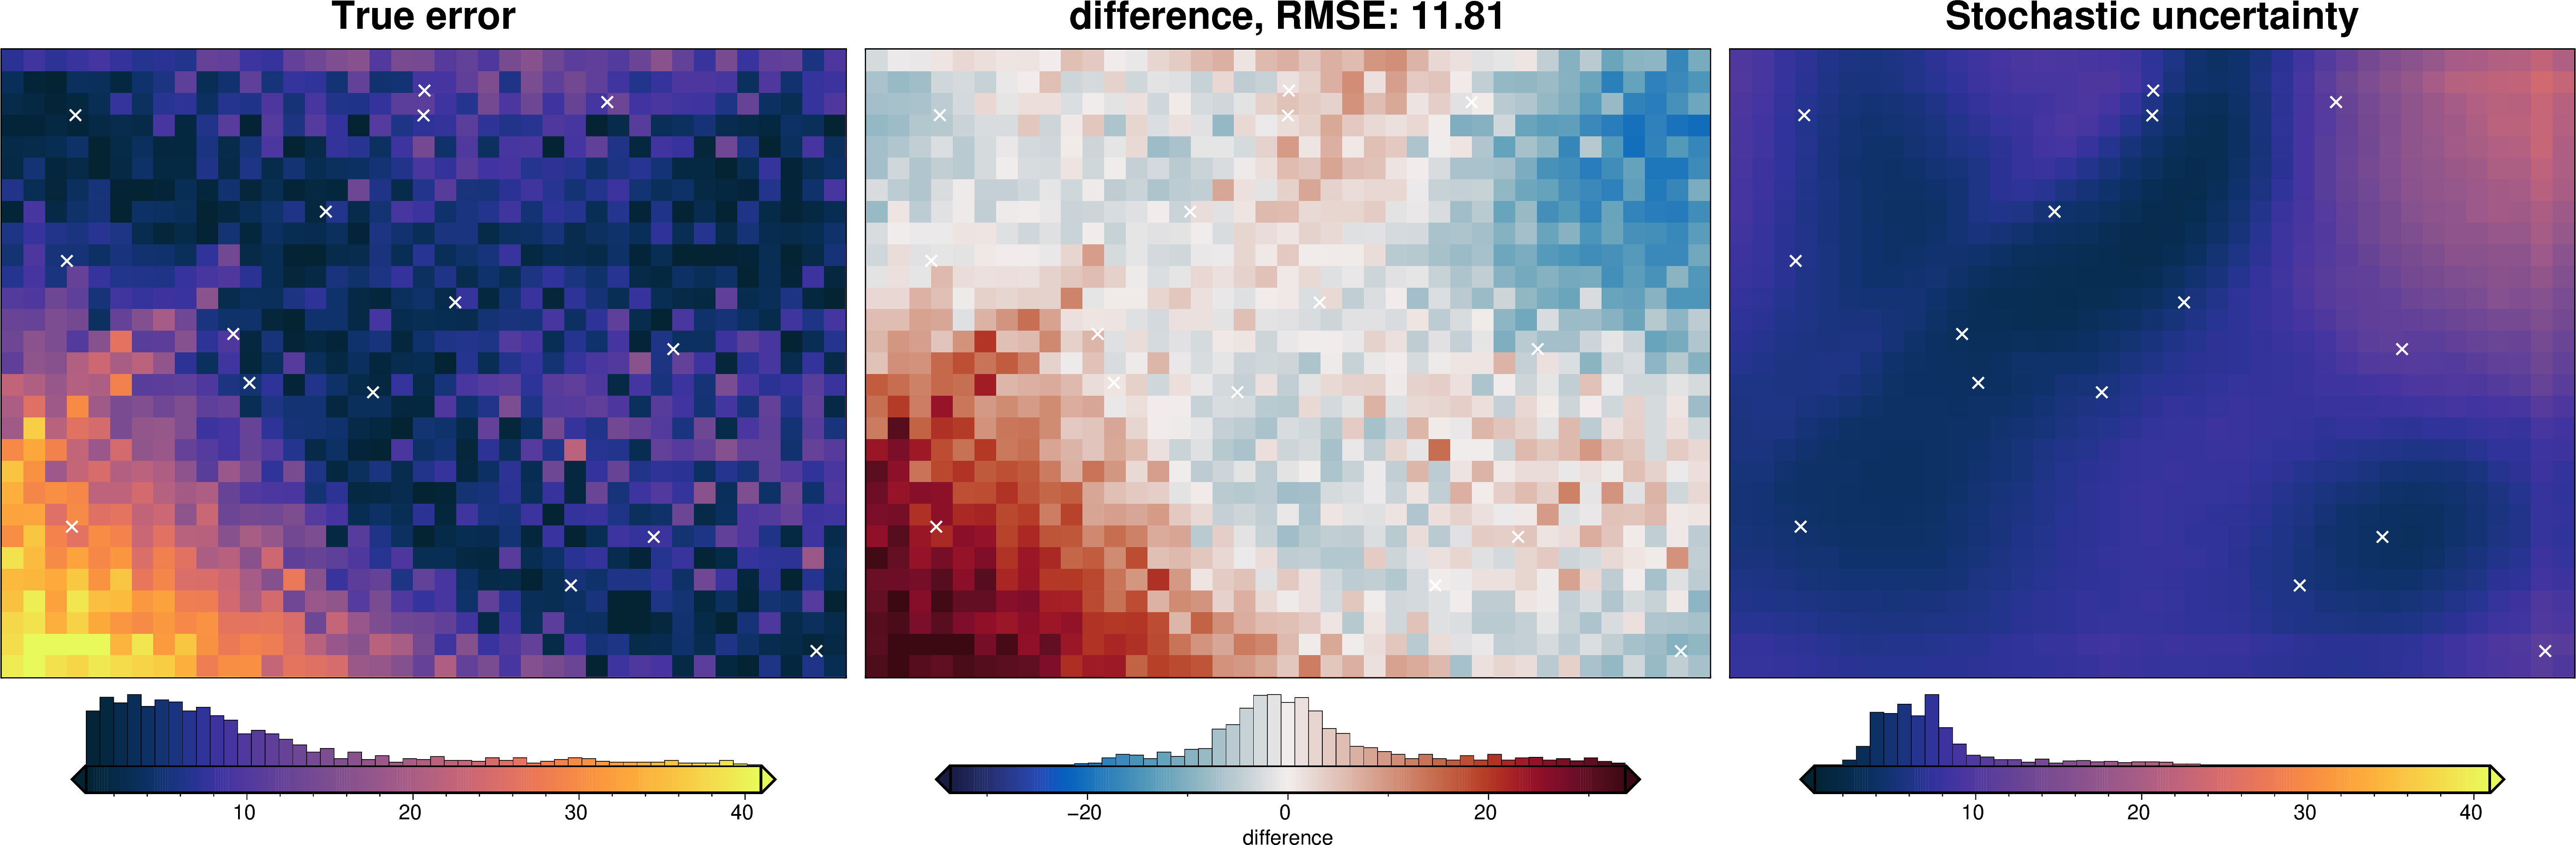

In [26]:
fname = "../tmp/uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    runs=10,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_constraints_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Gravity component

In [27]:
grav_df.describe()

northing       easting  upward  upper_surface_grav  \
count   4941.000000   4941.000000  4941.0         4941.000000   
mean   15000.000000  20000.000000  1001.0           -0.229678   
std     8804.299419  11691.635129     0.0            7.103507   
min        0.000000      0.000000  1001.0          -17.227928   
25%     7500.000000  10000.000000  1001.0           -5.587227   
50%    15000.000000  20000.000000  1001.0           -1.239580   
75%    22500.000000  30000.000000  1001.0            3.490030   
max    30000.000000  40000.000000  1001.0           19.754954   

       lower_surface_grav  observed_grav  gravity_anomaly        uncert  \
count         4941.000000    4941.000000      4941.000000  4.941000e+03   
mean             0.004286      -0.225392        -0.225332  1.000000e-01   
std              0.720692       7.247722         7.245591  1.064189e-10   
min             -1.034071     -16.940400       -17.040892  1.000000e-01   
25%             -0.610336      -5.906763        -5.910496  1.000000e-01   
50%             -0.155380      -0.822890        -0.813296  1.000000e-01   
75%              0.542849       3.738912         3.726649  1.000000e-01   
max              1.602413      19.932831        19.959187  1.000000e-01   

       starting_gravity     true_res       misfit          reg          res  \
count       4941.000000  4941.000000  4941.000000  4941.000000  4941.000000   
mean           0.517690    -1.254871    -0.743022    -0.134885    -0.608137   
std            7.538787     4.621594     5.076524     1.376126     4.572632   
min           -9.430753   -19.592049   -20.057107    -2.560355   -18.518955   
25%           -5.500220    -3.008015    -2.800362    -1.230061    -2.338344   
50%           -1.442872    -1.483188    -1.207388    -0.191240    -0.616647   
75%            5.248543     0.577570     1.437138     1.026287     1.260866   
max           25.047338    13.969991    15.352249     2.279162    14.666685   

       staring_res  starting_reg  
count  4941.000000   4941.000000  
mean     -0.608137     -0.134885  
std       4.572632      1.376126  
min     -18.518955     -2.560355  
25%      -2.338344     -1.230061  
50%      -0.616647     -0.191240  
75%       1.260866      1.026287  
max      14.666685      2.279162

In [28]:
grav_df.res

0      -0.543986
1      -1.134643
2      -0.868003
3      -0.751438
4      -0.661081
          ...   
4936   -5.933460
4937   -6.187334
4938   -6.292103
4939   -6.222844
4940   -5.557404
Name: res, Length: 4941, dtype: float64

INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_grav'



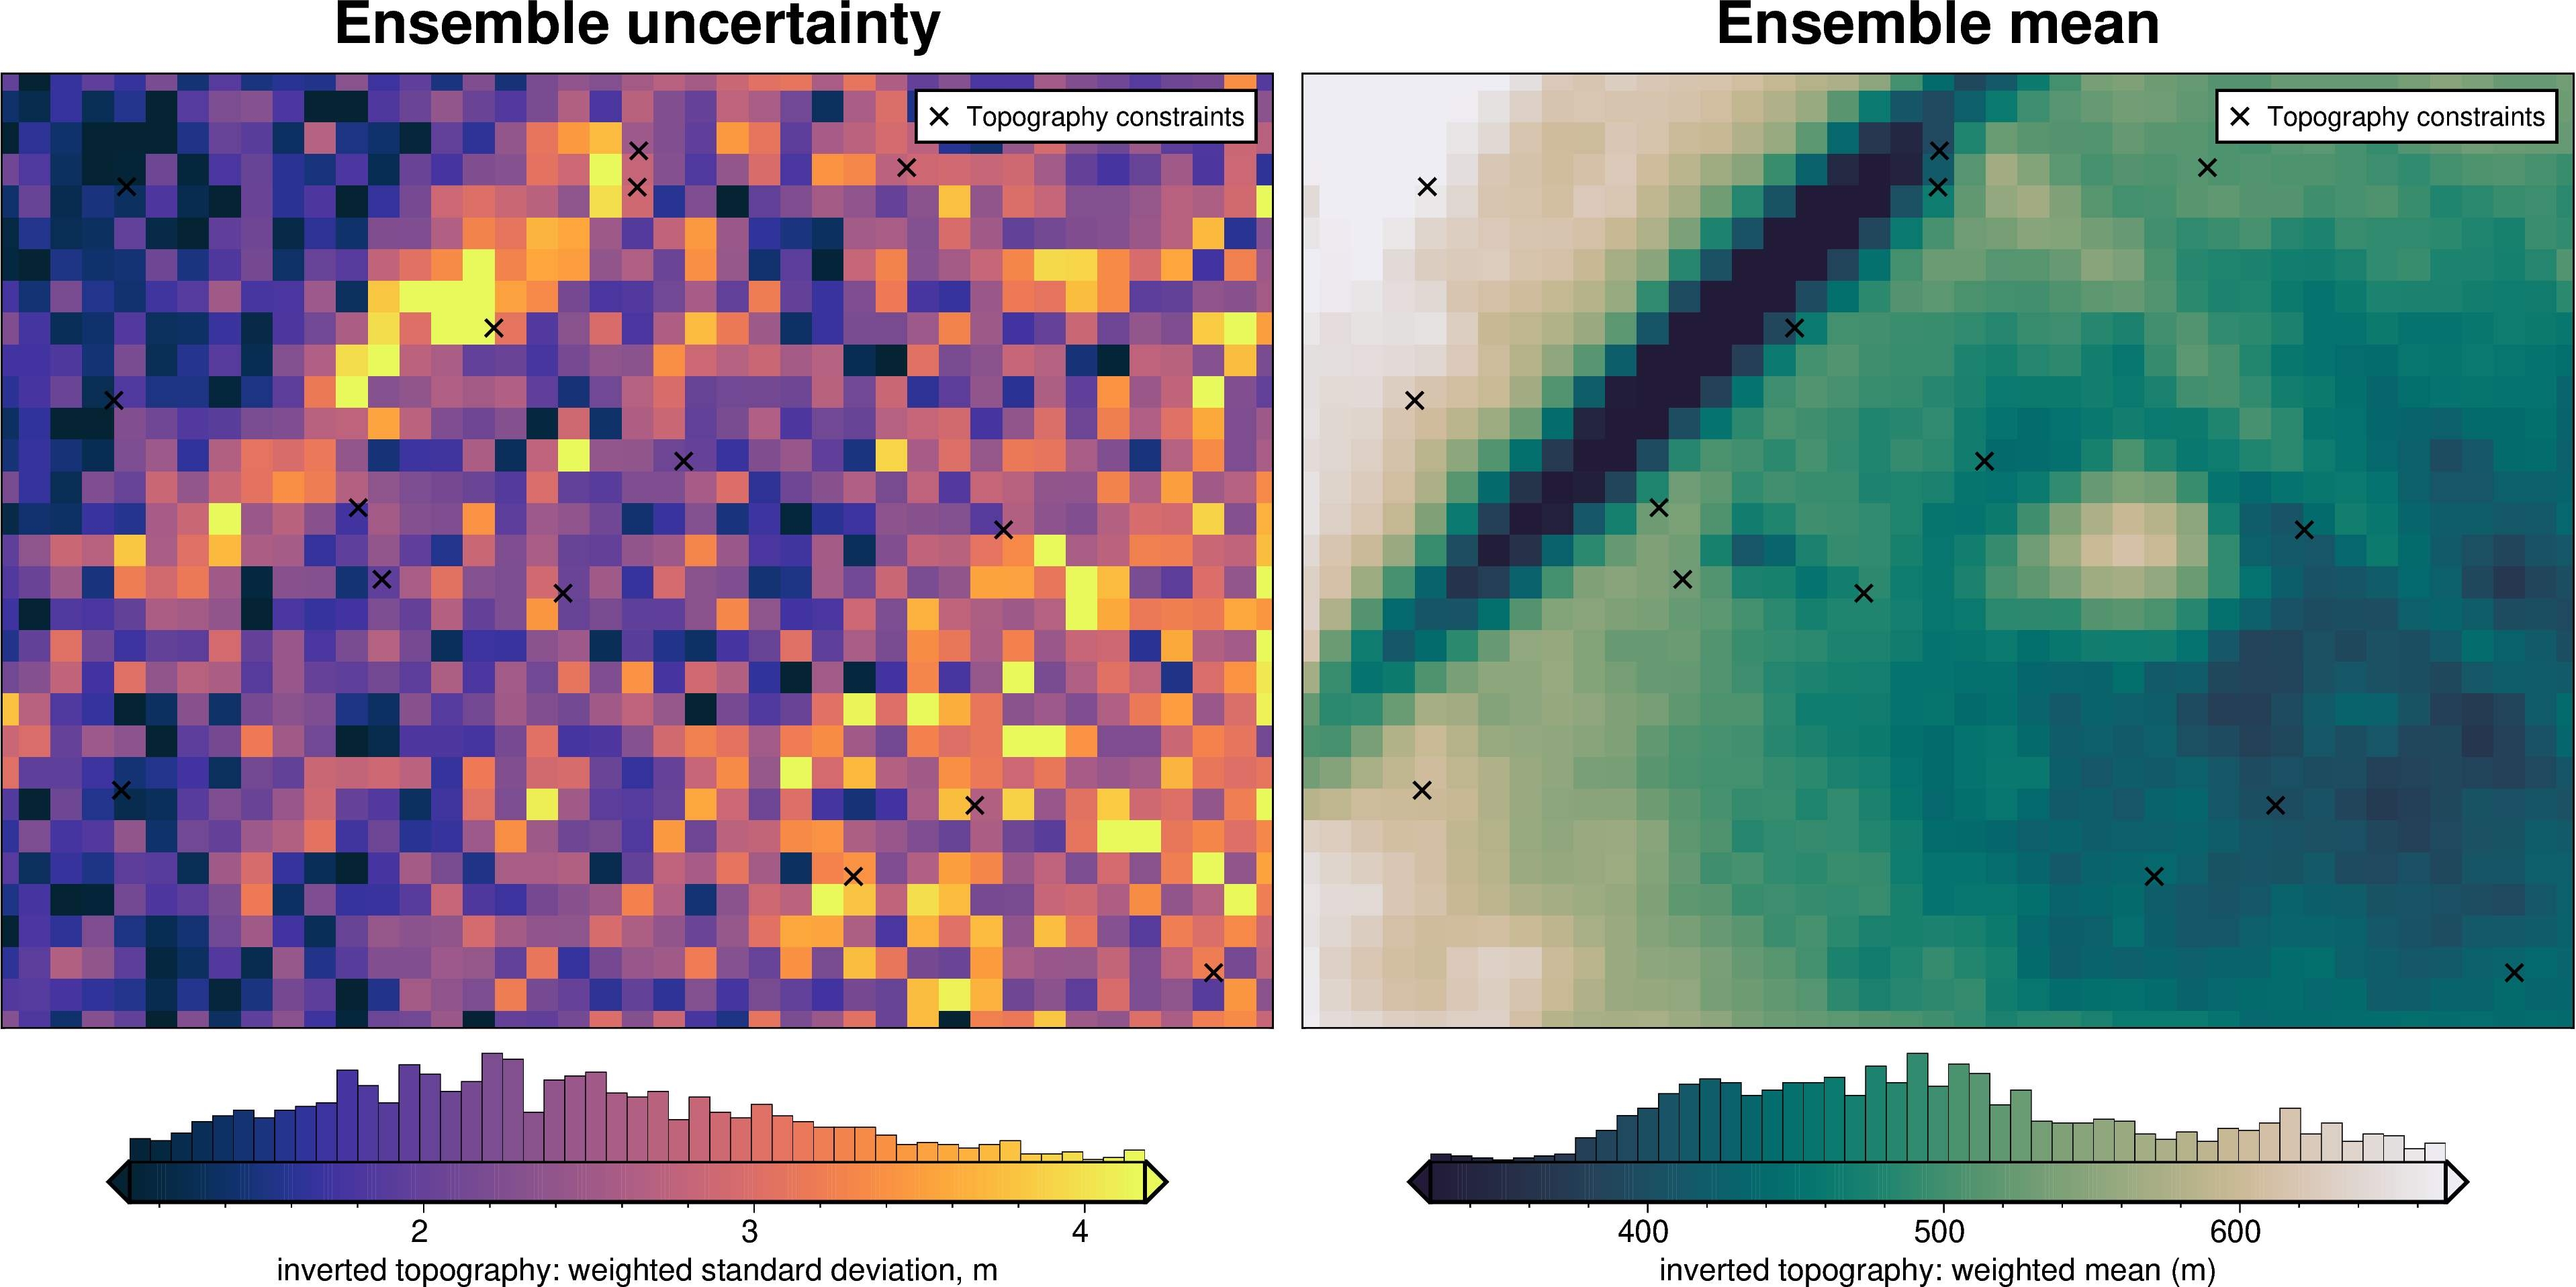

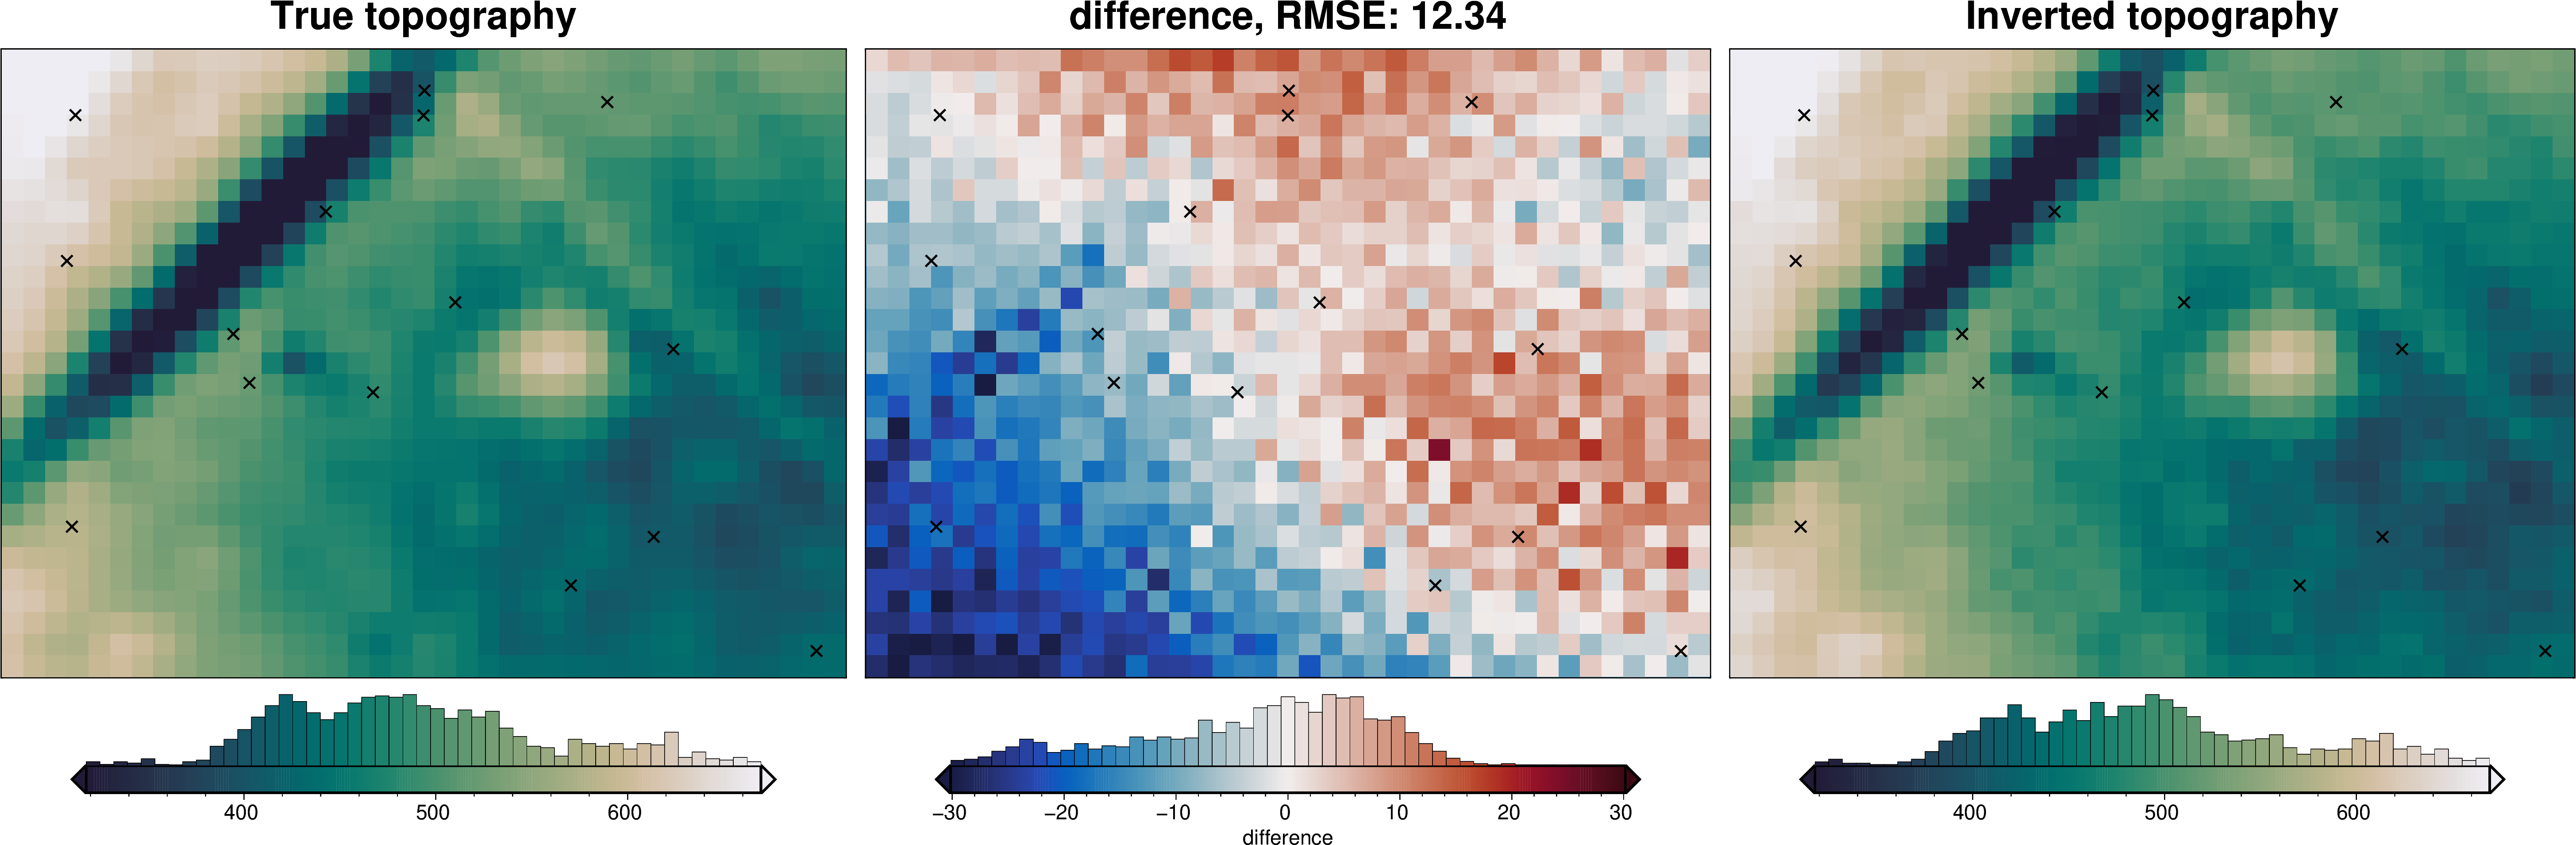

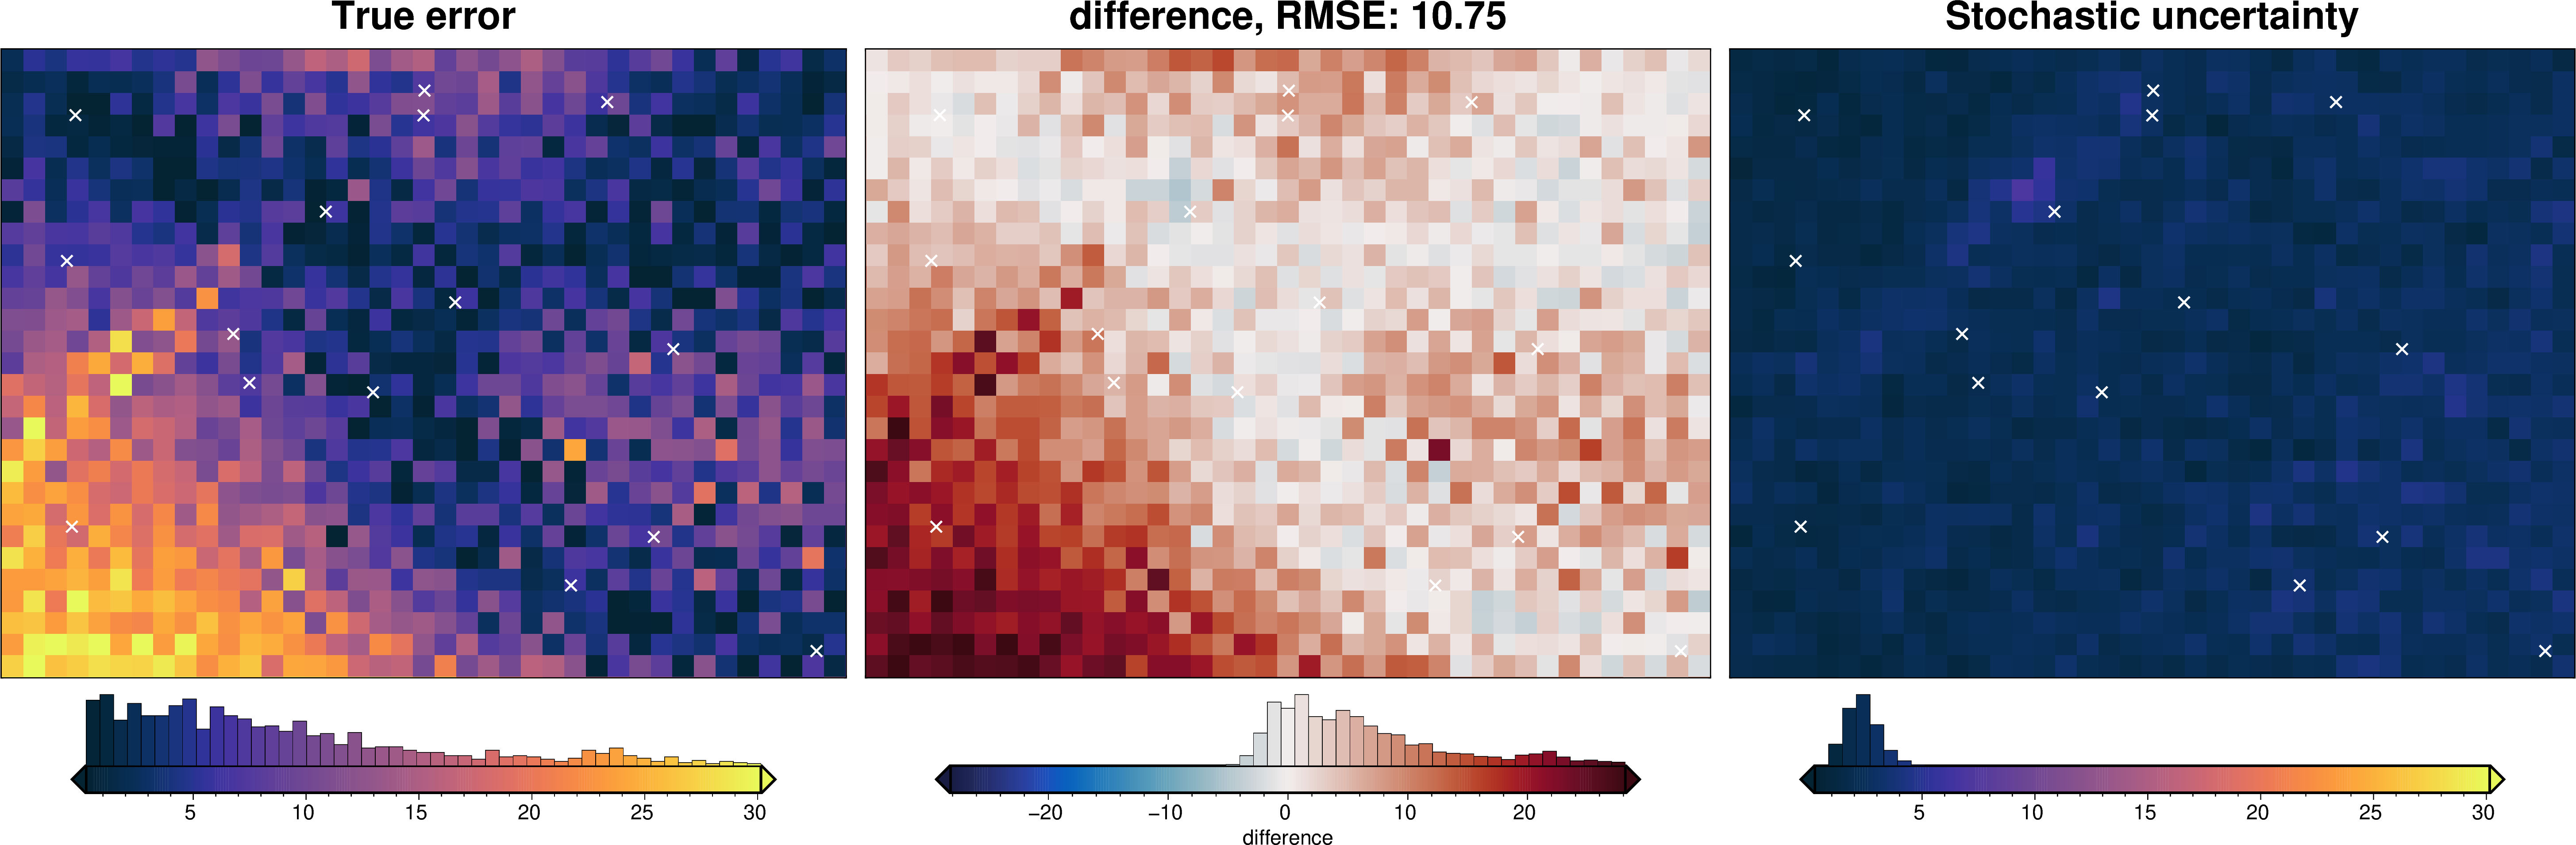

In [29]:
fname = "../tmp/uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_gravity=True,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_grav_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Regional gravity component

In [30]:
reg_eq_depth, reg_eq_damping

(np.float64(25196.204289908077), 0.04881091466863527)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.204289908077, min: 18706.0921550931, max: 31686.316424723052
INFO:invert4geom:Sampled 'damping' parameter values; mean: 10095310.008659463, min: 2.4277263483714883e-12, max: 981373124.0289752


starting regional ensemble:   0%|          | 0/100 [00:00<?, ?it/s]

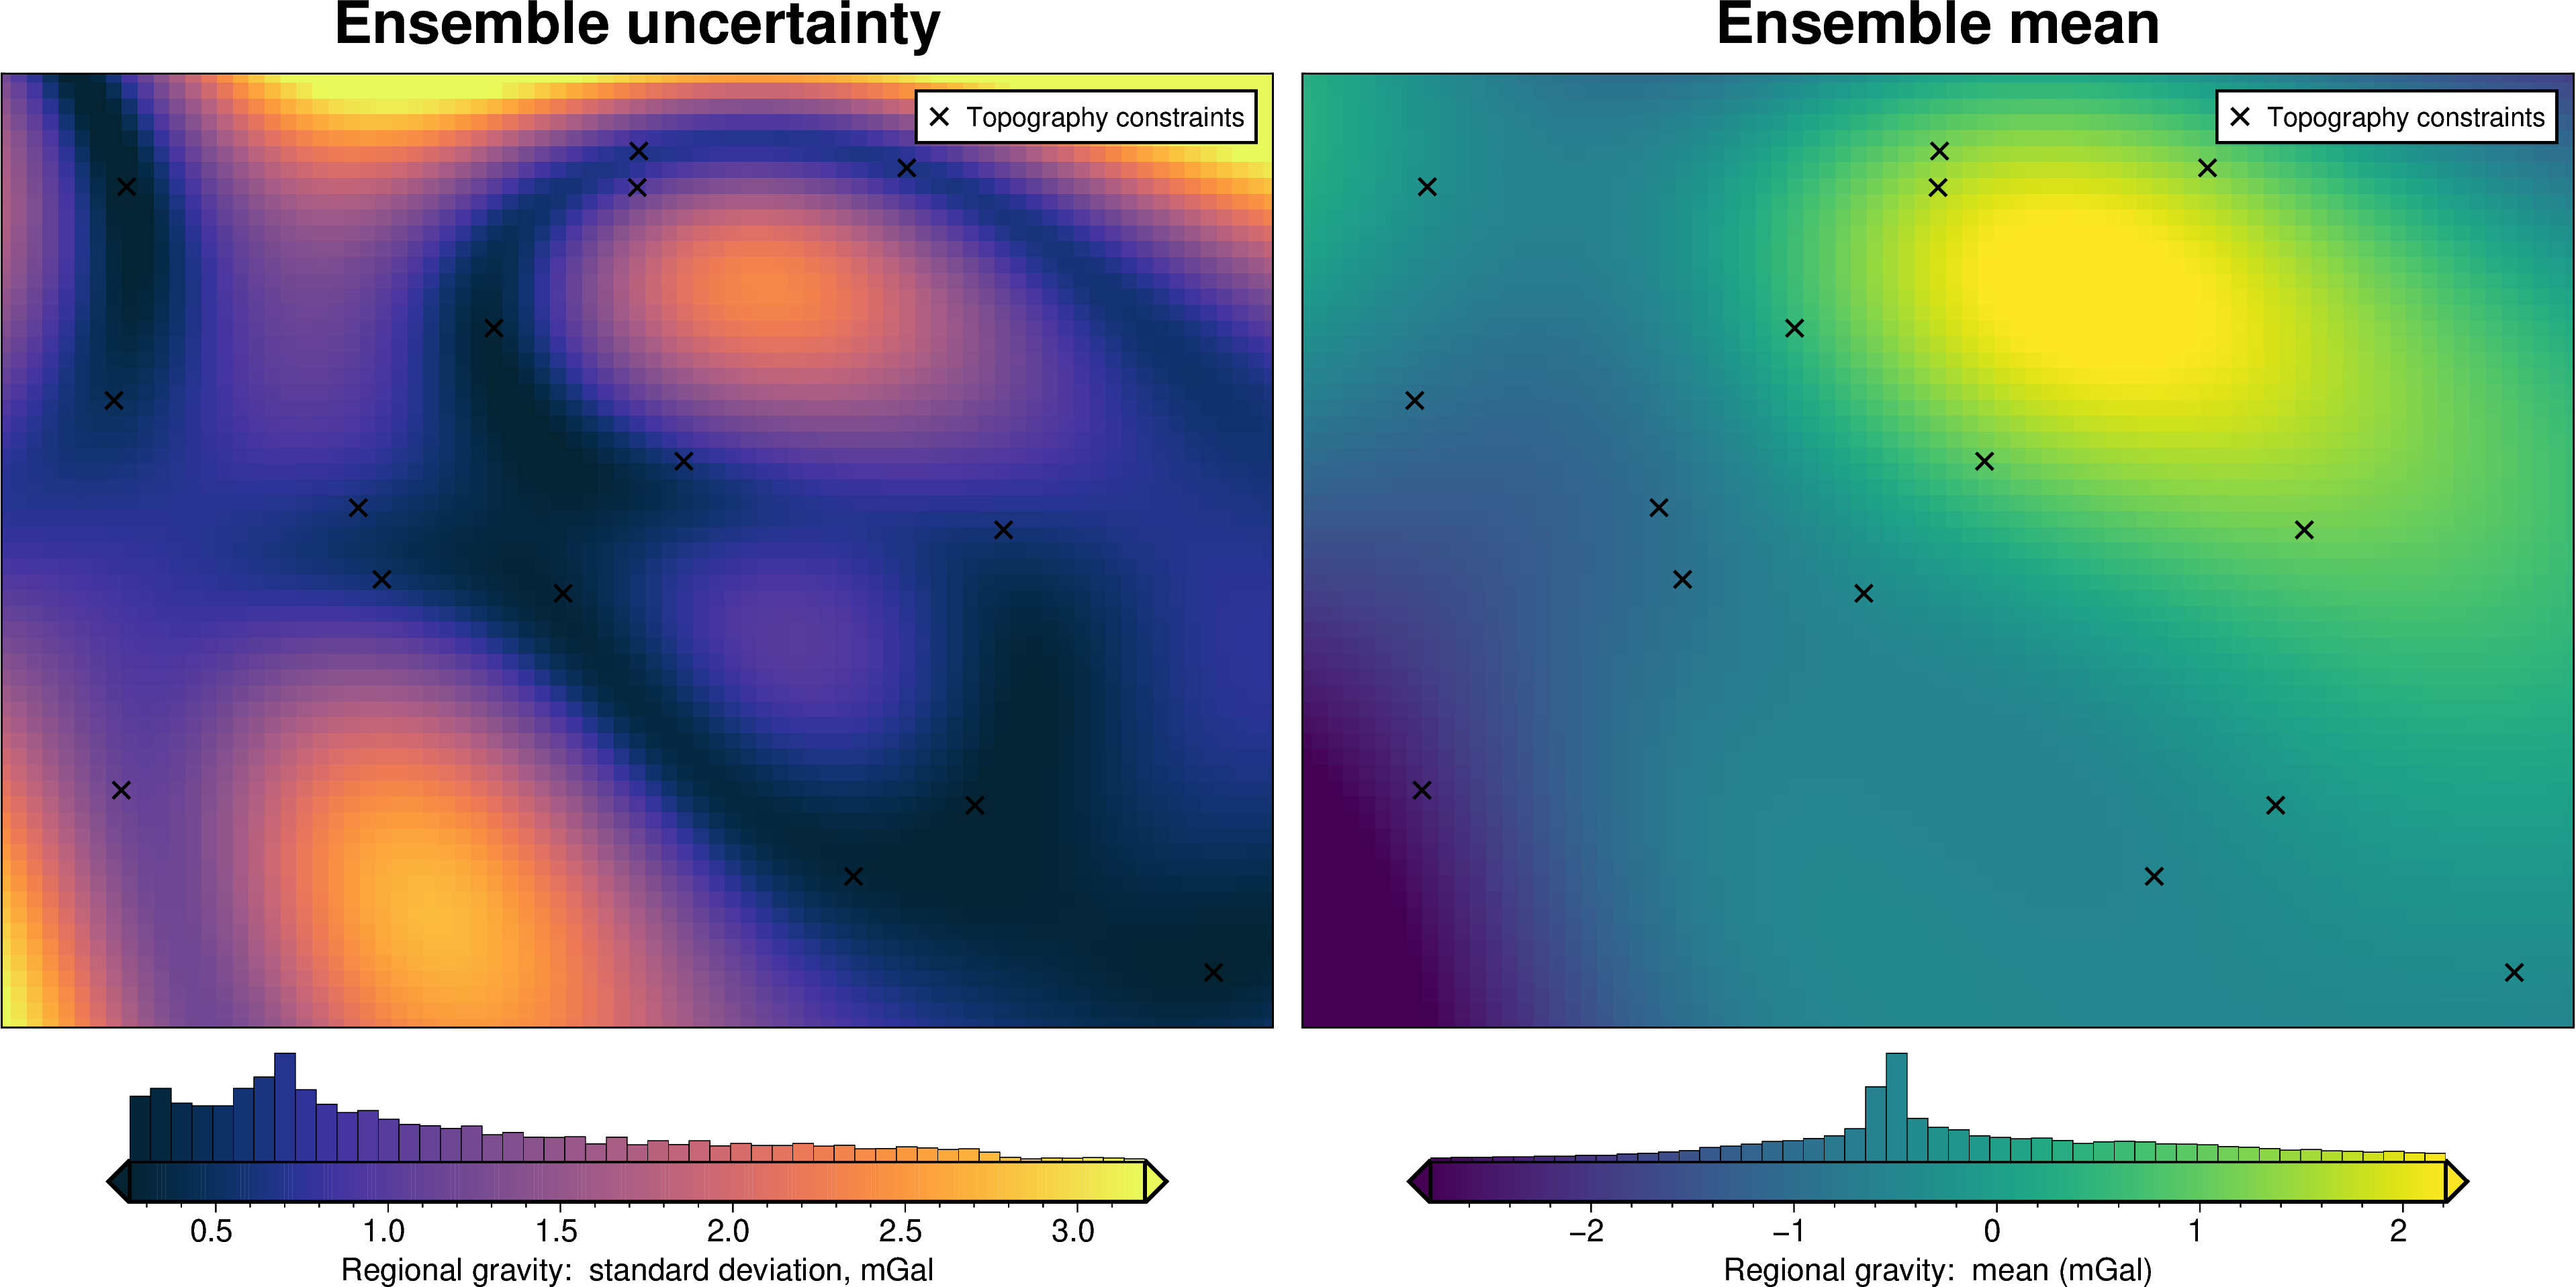

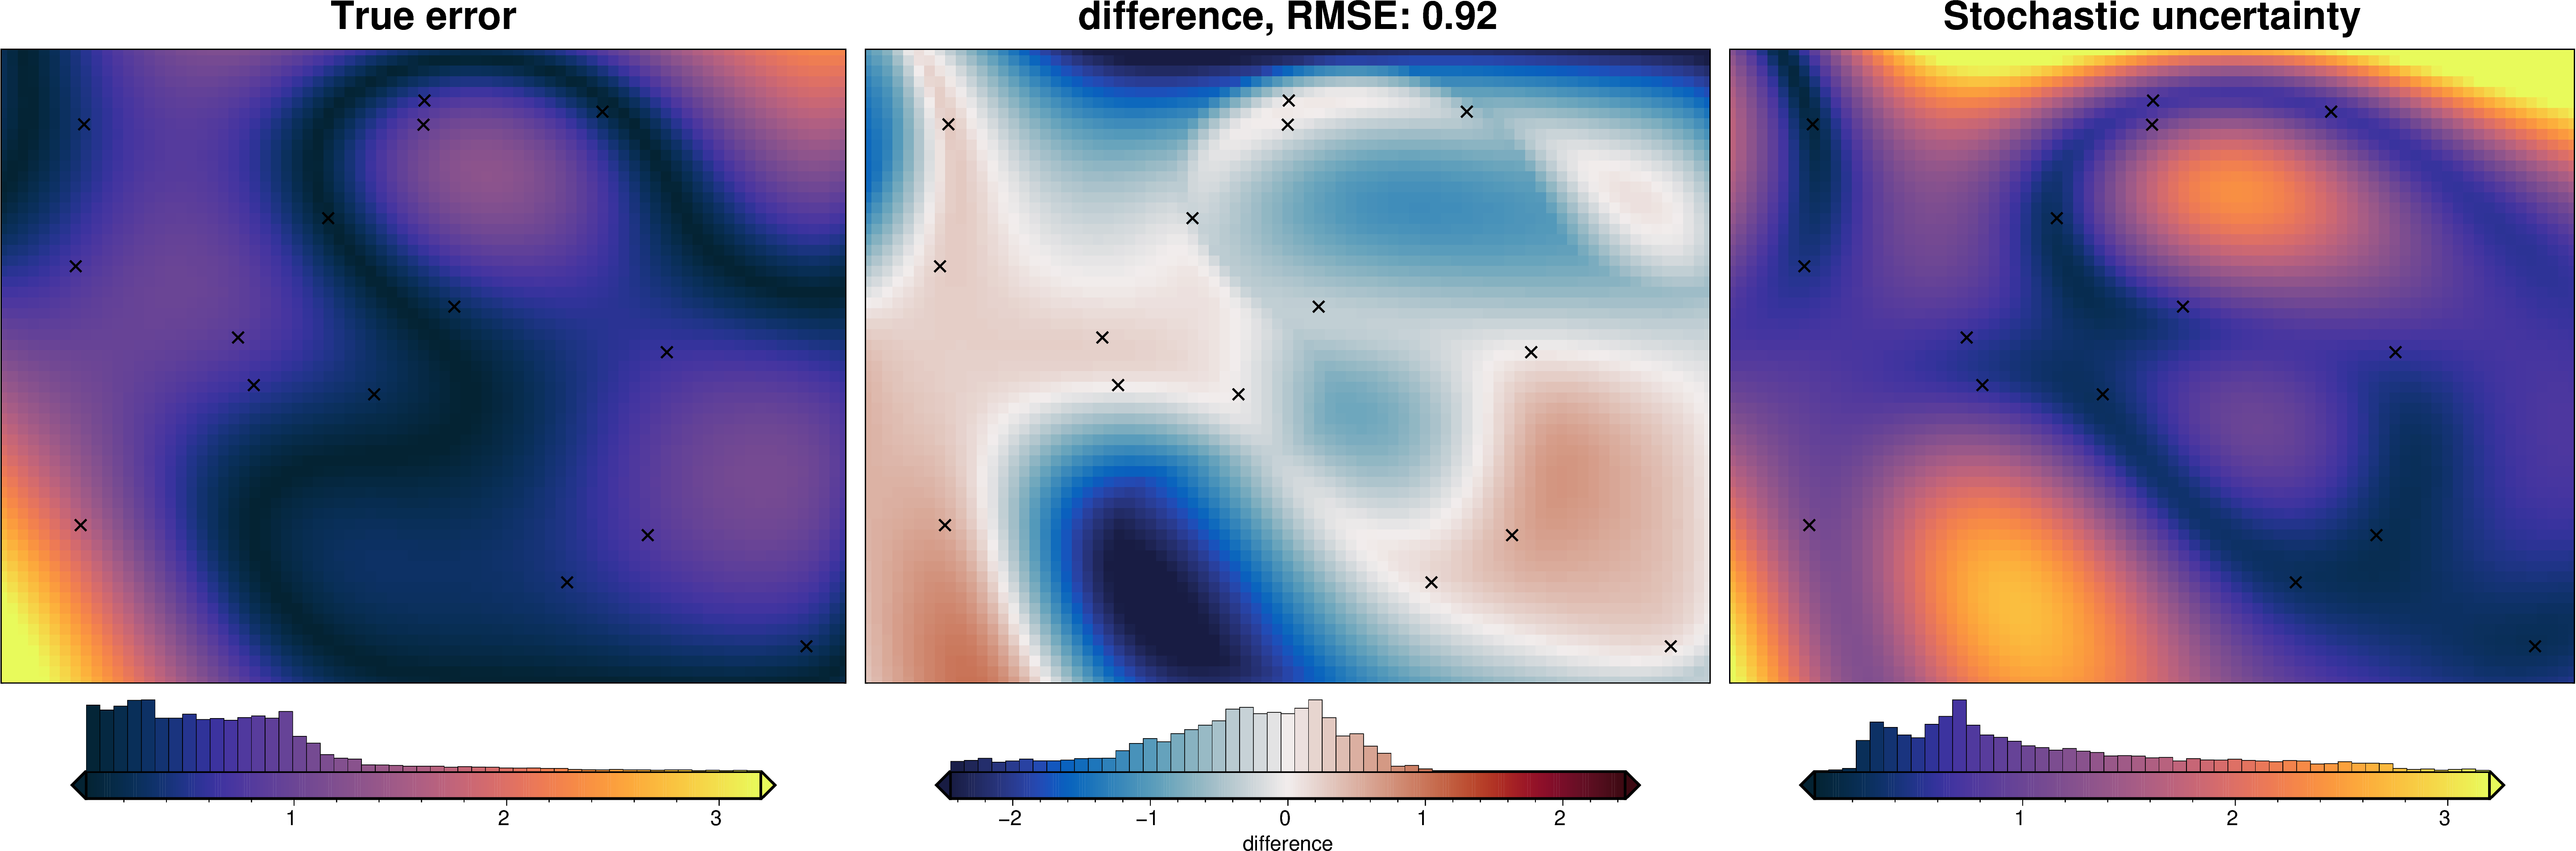

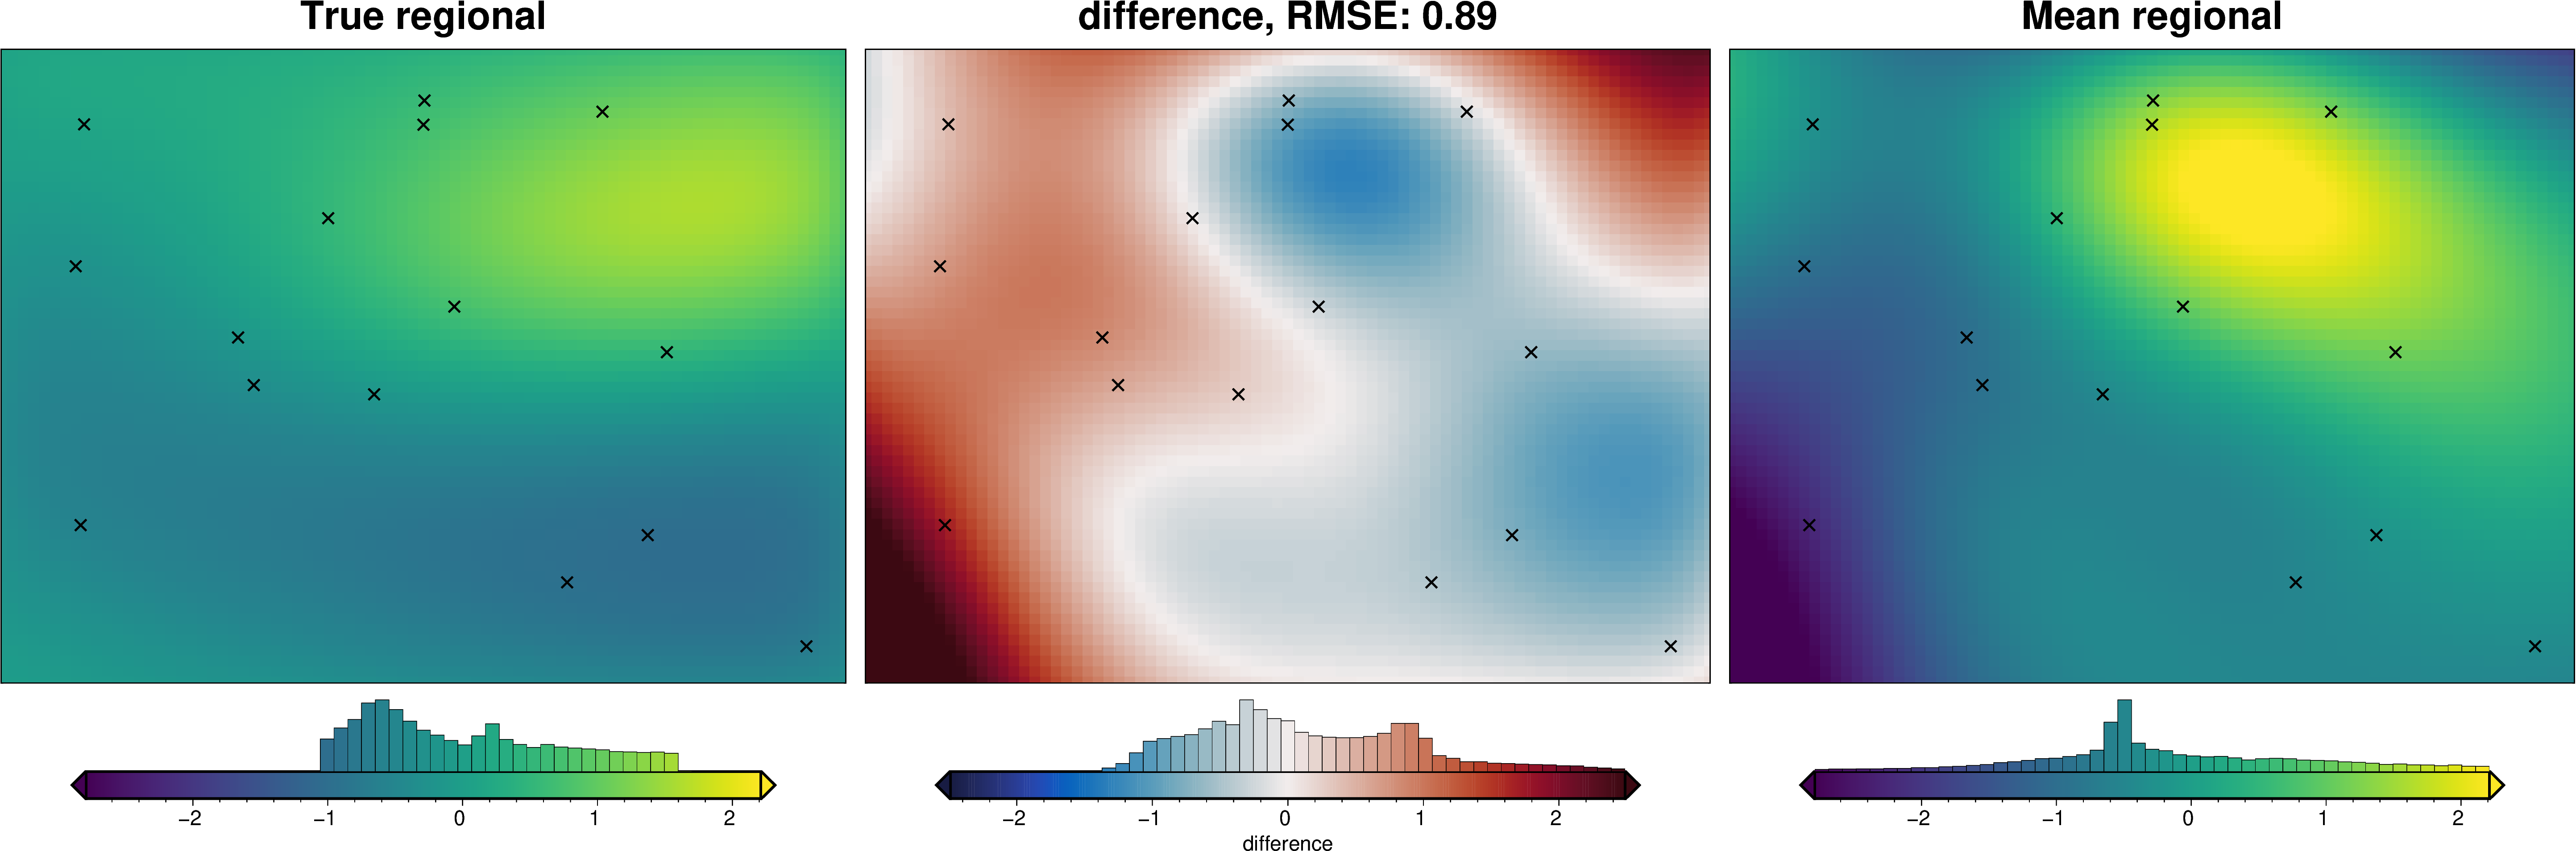

In [31]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "normal",
        "loc": reg_eq_depth,  # mean
        "scale": reg_eq_depth / 10,  # standard deviation
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(reg_eq_damping),  # mean base 10 exponent
        # "scale": np.abs(np.log10(reg_eq_damping)),  # standard deviation of exponent
        "scale": 4,
        "log": True,
    },
}

regional_misfit_stats, _ = uncertainty.regional_misfit_uncertainty(
    runs=100,
    parameter_dict=regional_misfit_parameter_dict,
    true_regional=grav_grid.lower_surface_grav,
    # weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
    grav_df=grav_df,
    **new_regional_grav_kwargs,
)

In [32]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_grid["reg_uncert"] = regional_misfit_stats.z_stdev
grav_df_new = vd.grid_to_table(grav_grid)
grav_df_new

northing  easting   test  upward  upper_surface_grav  \
0          0.0      0.0  False  1001.0            9.042402   
1          0.0    500.0   True  1001.0            9.380272   
2          0.0   1000.0  False  1001.0            9.568091   
3          0.0   1500.0   True  1001.0            9.298147   
4          0.0   2000.0  False  1001.0            8.893385   
...        ...      ...    ...     ...                 ...   
4936   30000.0  38000.0  False  1001.0            2.982330   
4937   30000.0  38500.0   True  1001.0            2.931601   
4938   30000.0  39000.0  False  1001.0            2.946999   
4939   30000.0  39500.0   True  1001.0            2.873747   
4940   30000.0  40000.0  False  1001.0            2.784613   

      lower_surface_grav  observed_grav  gravity_anomaly  uncert  \
0              -0.041223       9.001179         9.017793     0.1   
1              -0.046312       9.333959         9.331242     0.1   
2              -0.052122       9.515969         9.506800     0.1   
3              -0.059918       9.238228         9.269420     0.1   
4              -0.068787       8.824597         8.892680     0.1   
...                  ...            ...              ...     ...   
4936            0.607664       3.589994         3.623280     0.1   
4937            0.580987       3.512587         3.472411     0.1   
4938            0.545480       3.492479         3.401948     0.1   
4939            0.495910       3.369657         3.335928     0.1   
4940            0.441061       3.225674         3.282663     0.1   

      starting_gravity  true_res    misfit       reg       res  staring_res  \
0            12.100747 -2.349335 -3.082955 -2.538969 -0.543986    -0.543986   
1            13.005580 -2.531914 -3.674339 -2.539696 -1.134643    -1.134643   
2            12.913705 -2.657964 -3.406905 -2.538902 -0.868003    -0.868003   
3            12.557419 -2.625601 -3.287998 -2.536560 -0.751438    -0.751438   
4            12.086407 -2.514374 -3.193727 -2.532646 -0.661081    -0.661081   
...                ...       ...       ...       ...       ...          ...   
4936          7.491087 -4.259751 -3.867807  2.065653 -5.933460    -5.933460   
4937          7.617747 -4.529030 -4.145336  2.041997 -6.187334    -6.187334   
4938          7.676430 -4.573146 -4.274481  2.017622 -6.292103    -6.292103   
4939          7.566170 -4.249337 -4.230242  1.992601 -6.222844    -6.222844   
4940          6.873059 -3.788240 -3.590396  1.967008 -5.557404    -5.557404   

      starting_reg  reg_uncert  
0        -2.538969    3.284866  
1        -2.539696    3.096668  
2        -2.538902    2.901981  
3        -2.536560    2.702328  
4        -2.532646    2.499585  
...            ...         ...  
4936      2.065653    4.732663  
4937      2.041997    4.786413  
4938      2.017622    4.835166  
4939      1.992601    4.879032  
4940      1.967008    4.918154  

[4941 rows x 17 columns]

In [33]:
# update grav_df
uncert_kwargs["grav_df"] = grav_df_new

INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.204289908077, min: 21051.797488741522, max: 29340.611091074632
INFO:invert4geom:Sampled 'damping' parameter values; mean: 18603.286041063246, min: 1.285589859638123e-08, max: 185323.90971560893
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_regional'



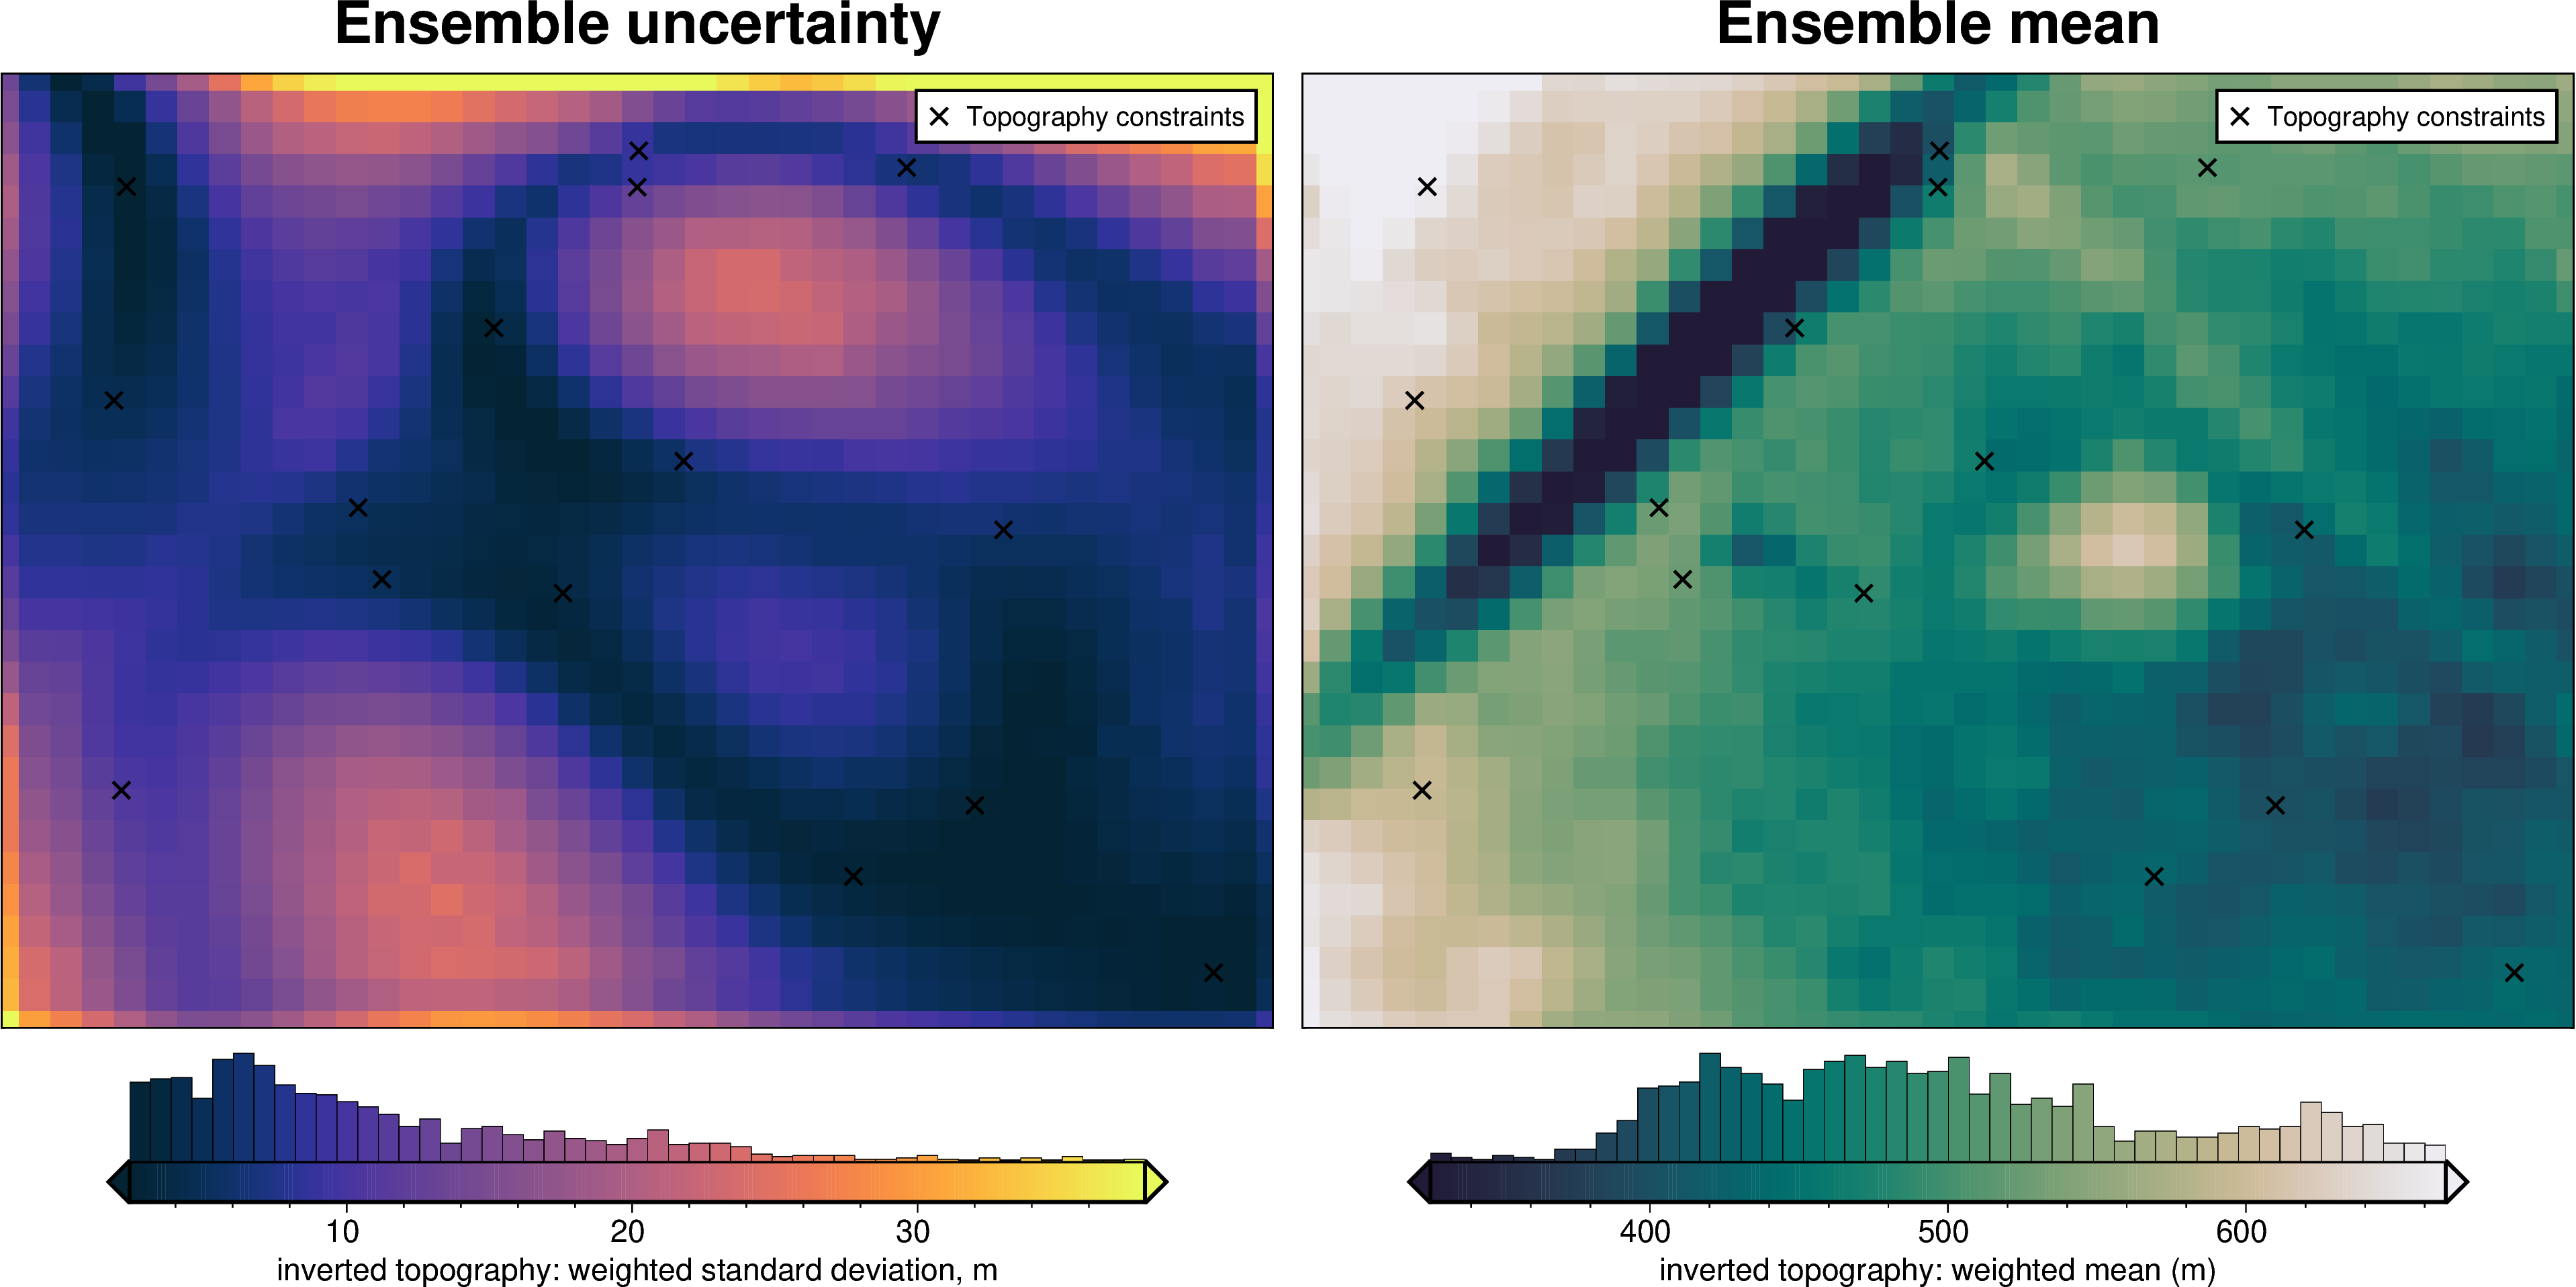

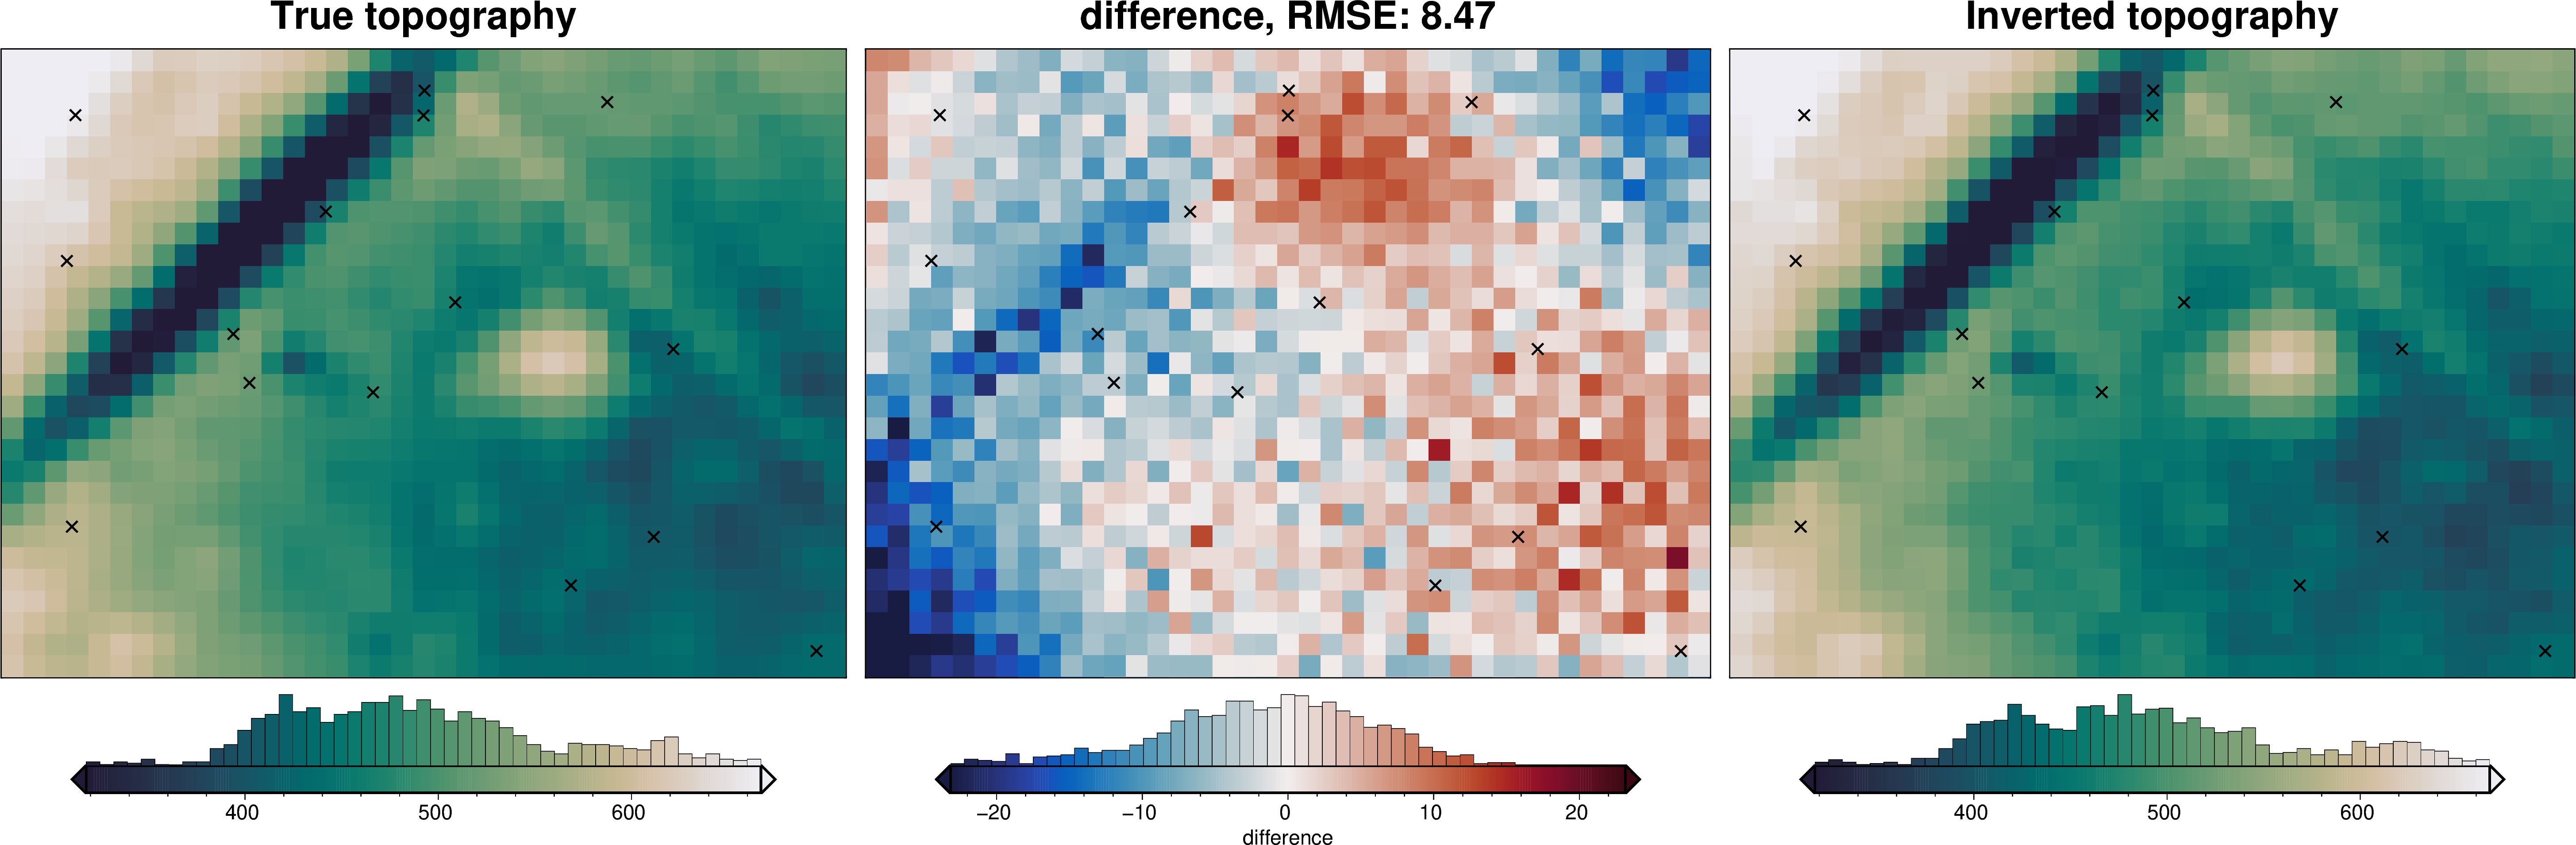

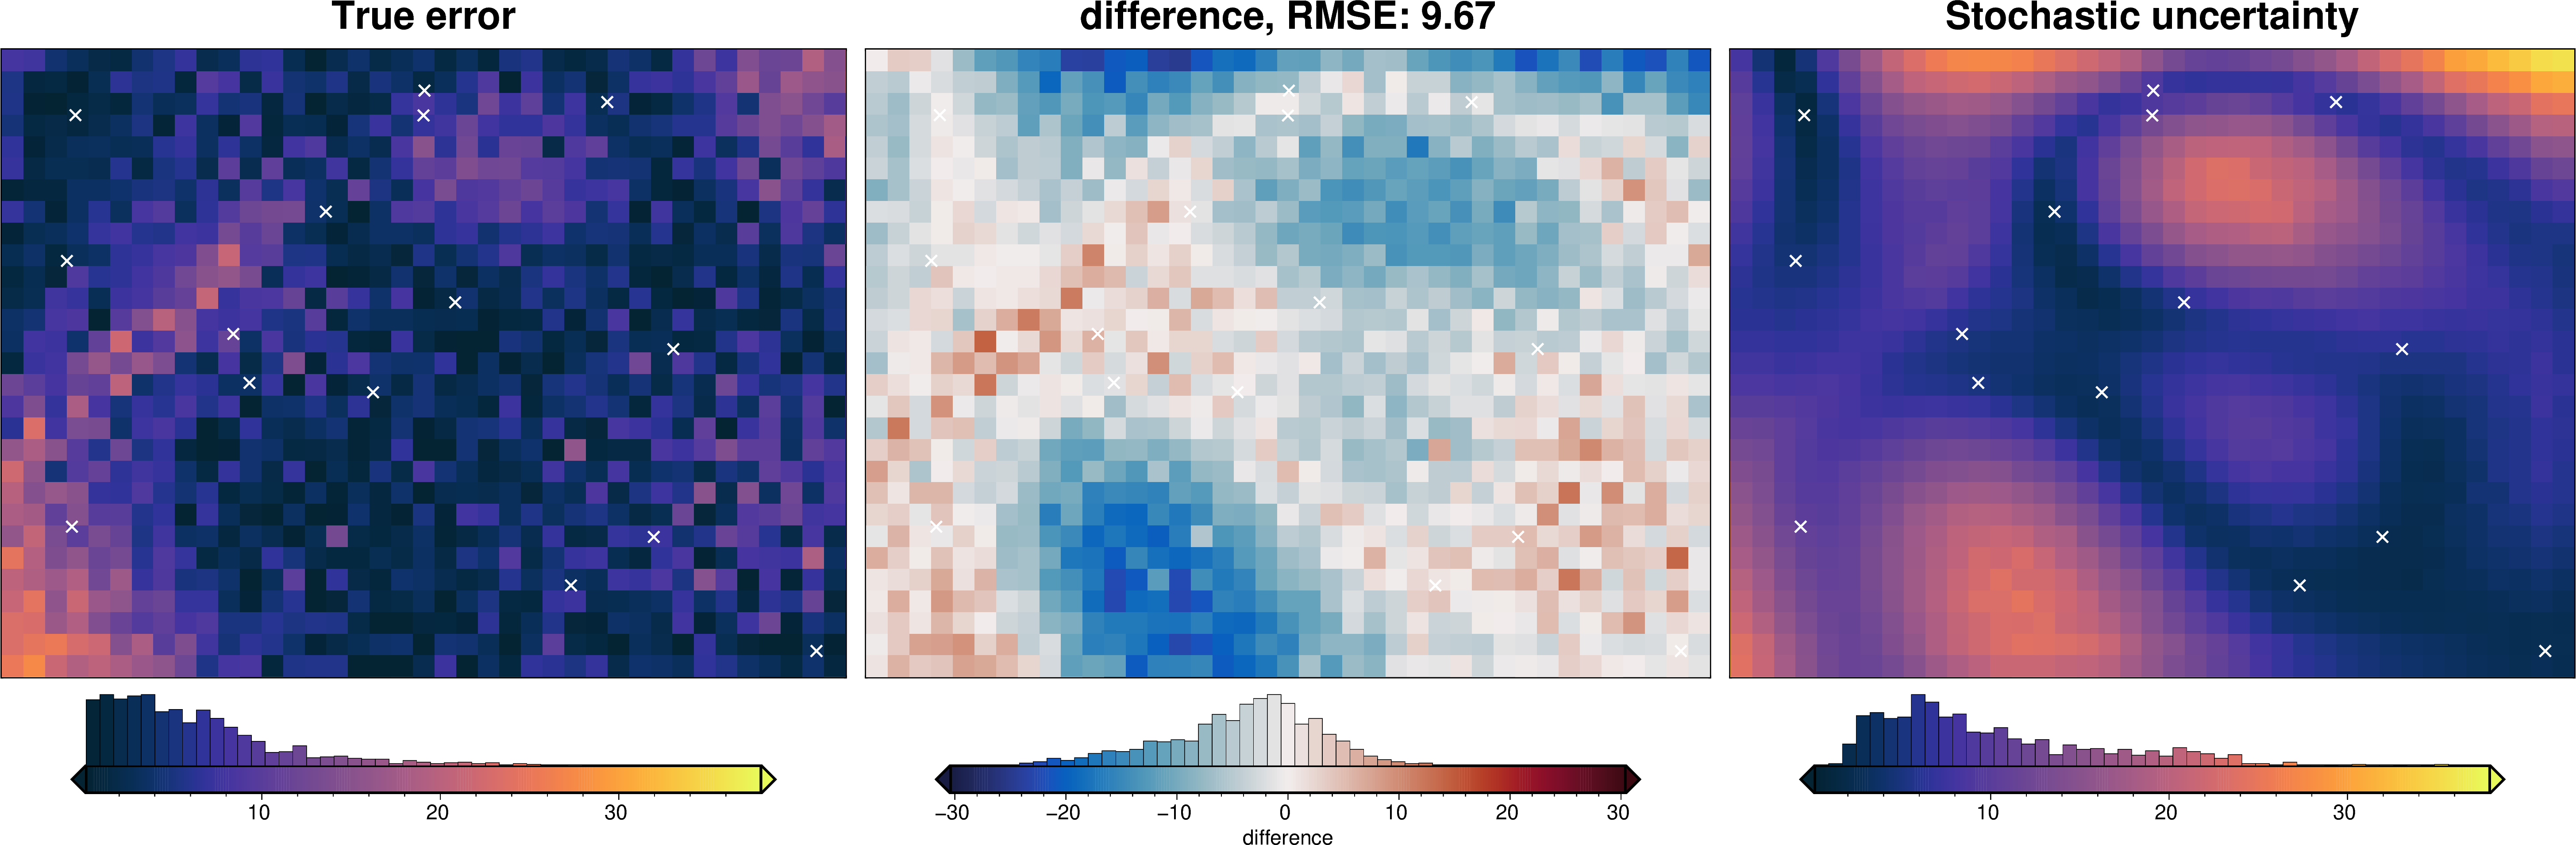

In [34]:
fname = "../tmp/uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_regional_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.06081861824860846, min: 0.001135491709342105, max: 0.4416188677057745
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2734.9999999999995, min: 2539.0036015459946, max: 2930.9963984540054
INFO:invert4geom:Sampled 'zref' parameter values; mean: 492.7923852854872, min: 394.79418605848446, max: 590.79058451249
INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.20428990808, min: 20257.83899437473, max: 30134.569585441426
INFO:invert4geom:Sampled 'damping' parameter values; mean: 170301.0793548694, min: 7.057664473265911e-10, max: 3375770.2704820298
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../tmp/uncertainty_full'



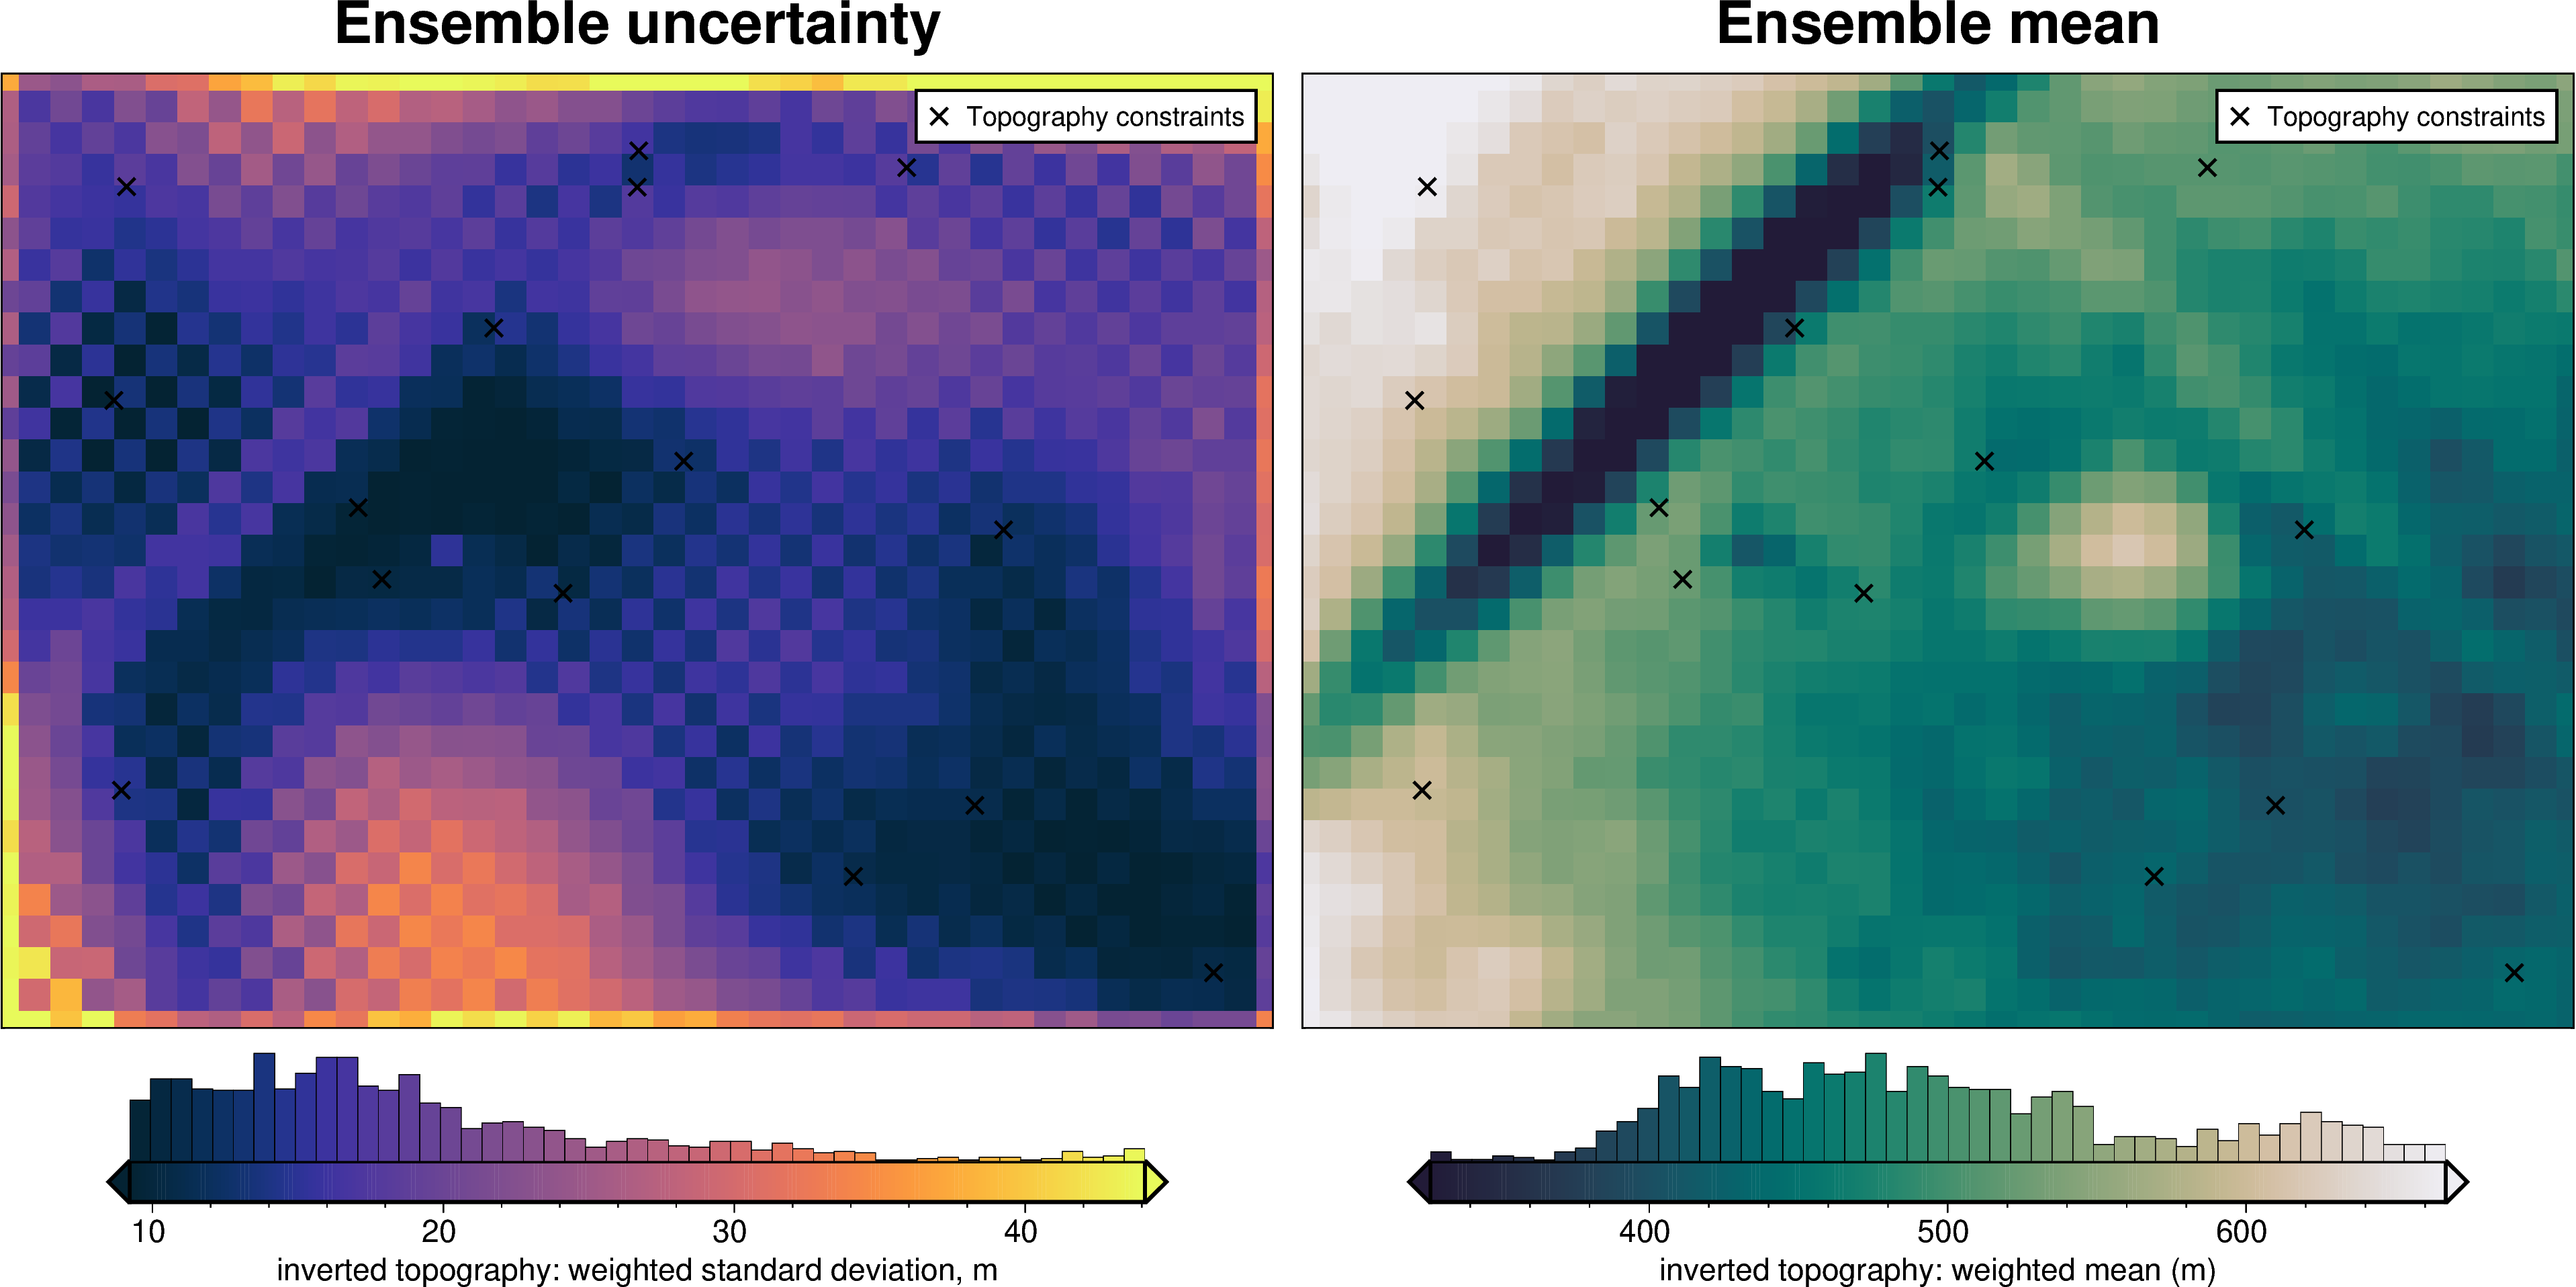

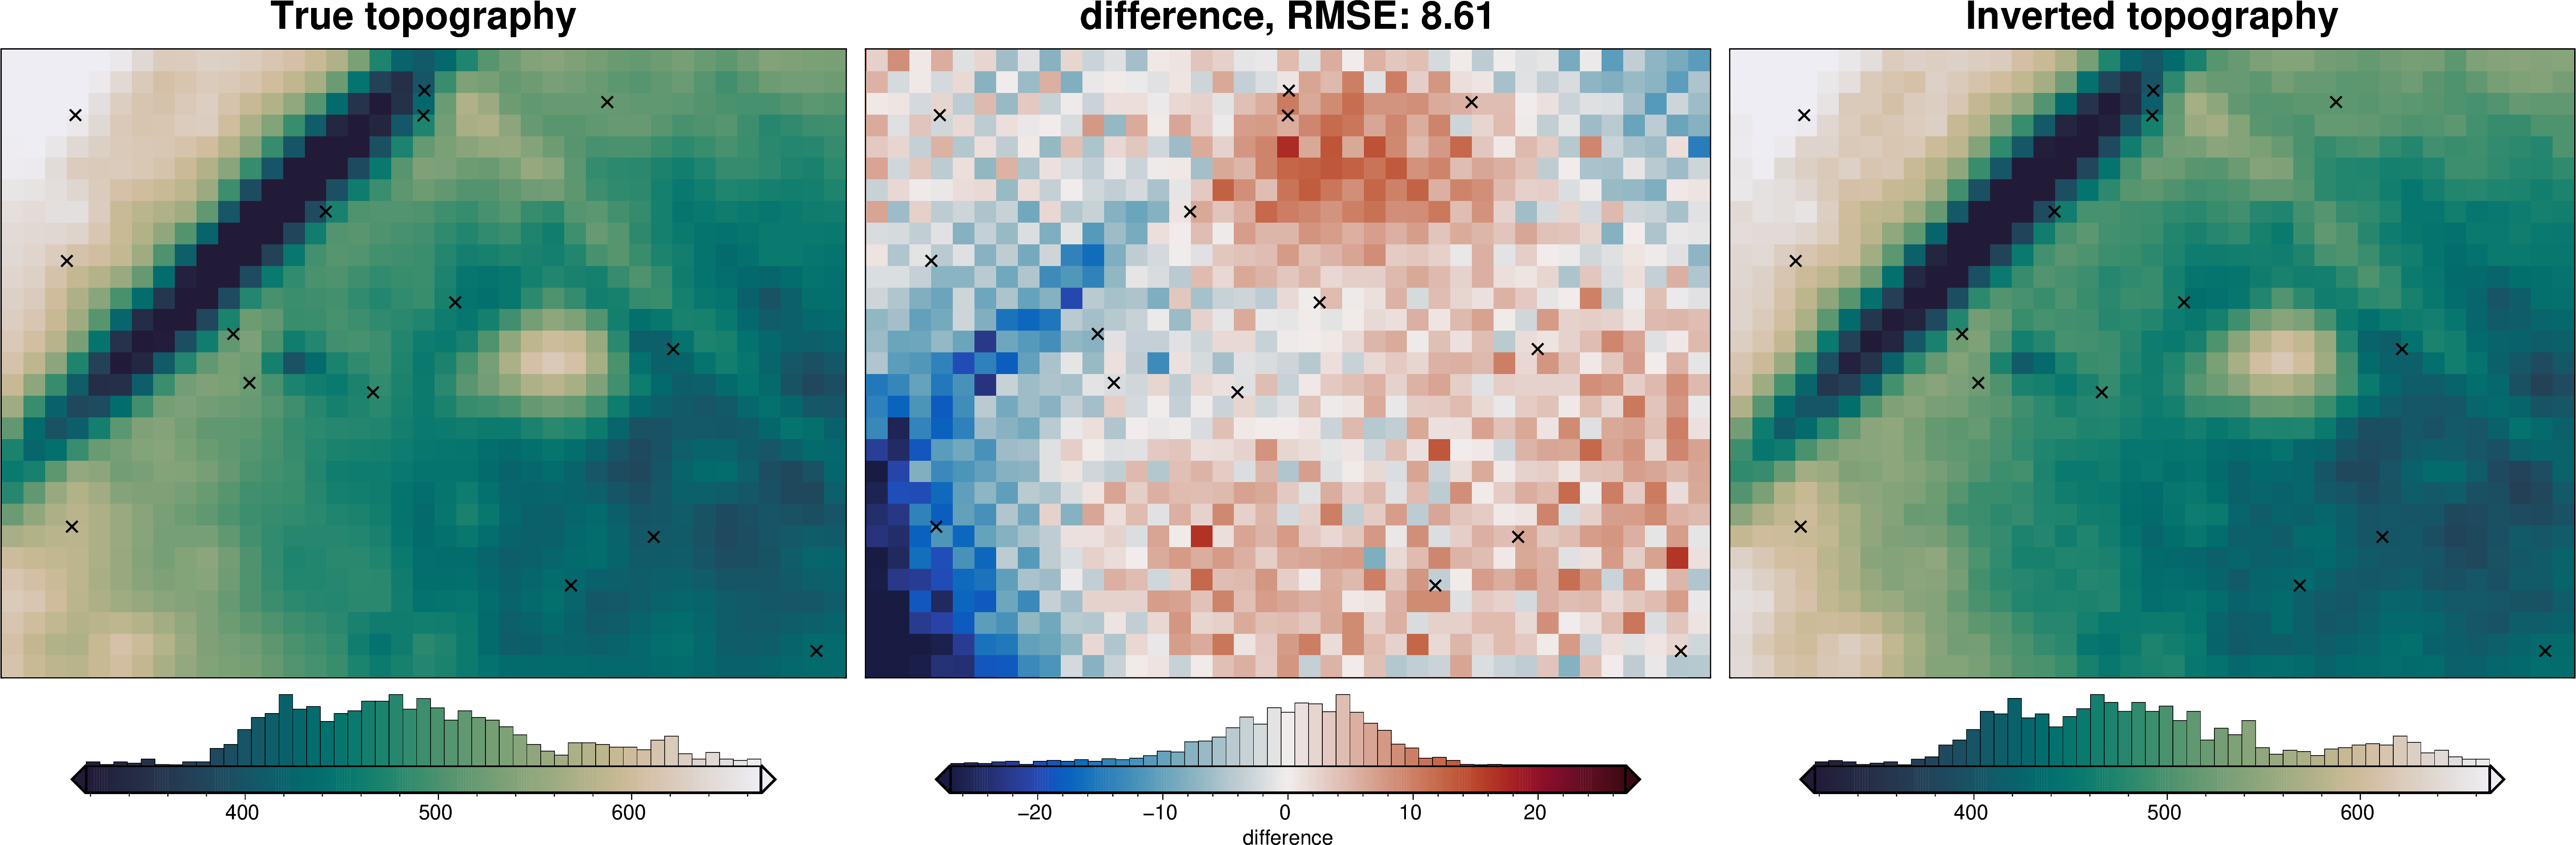

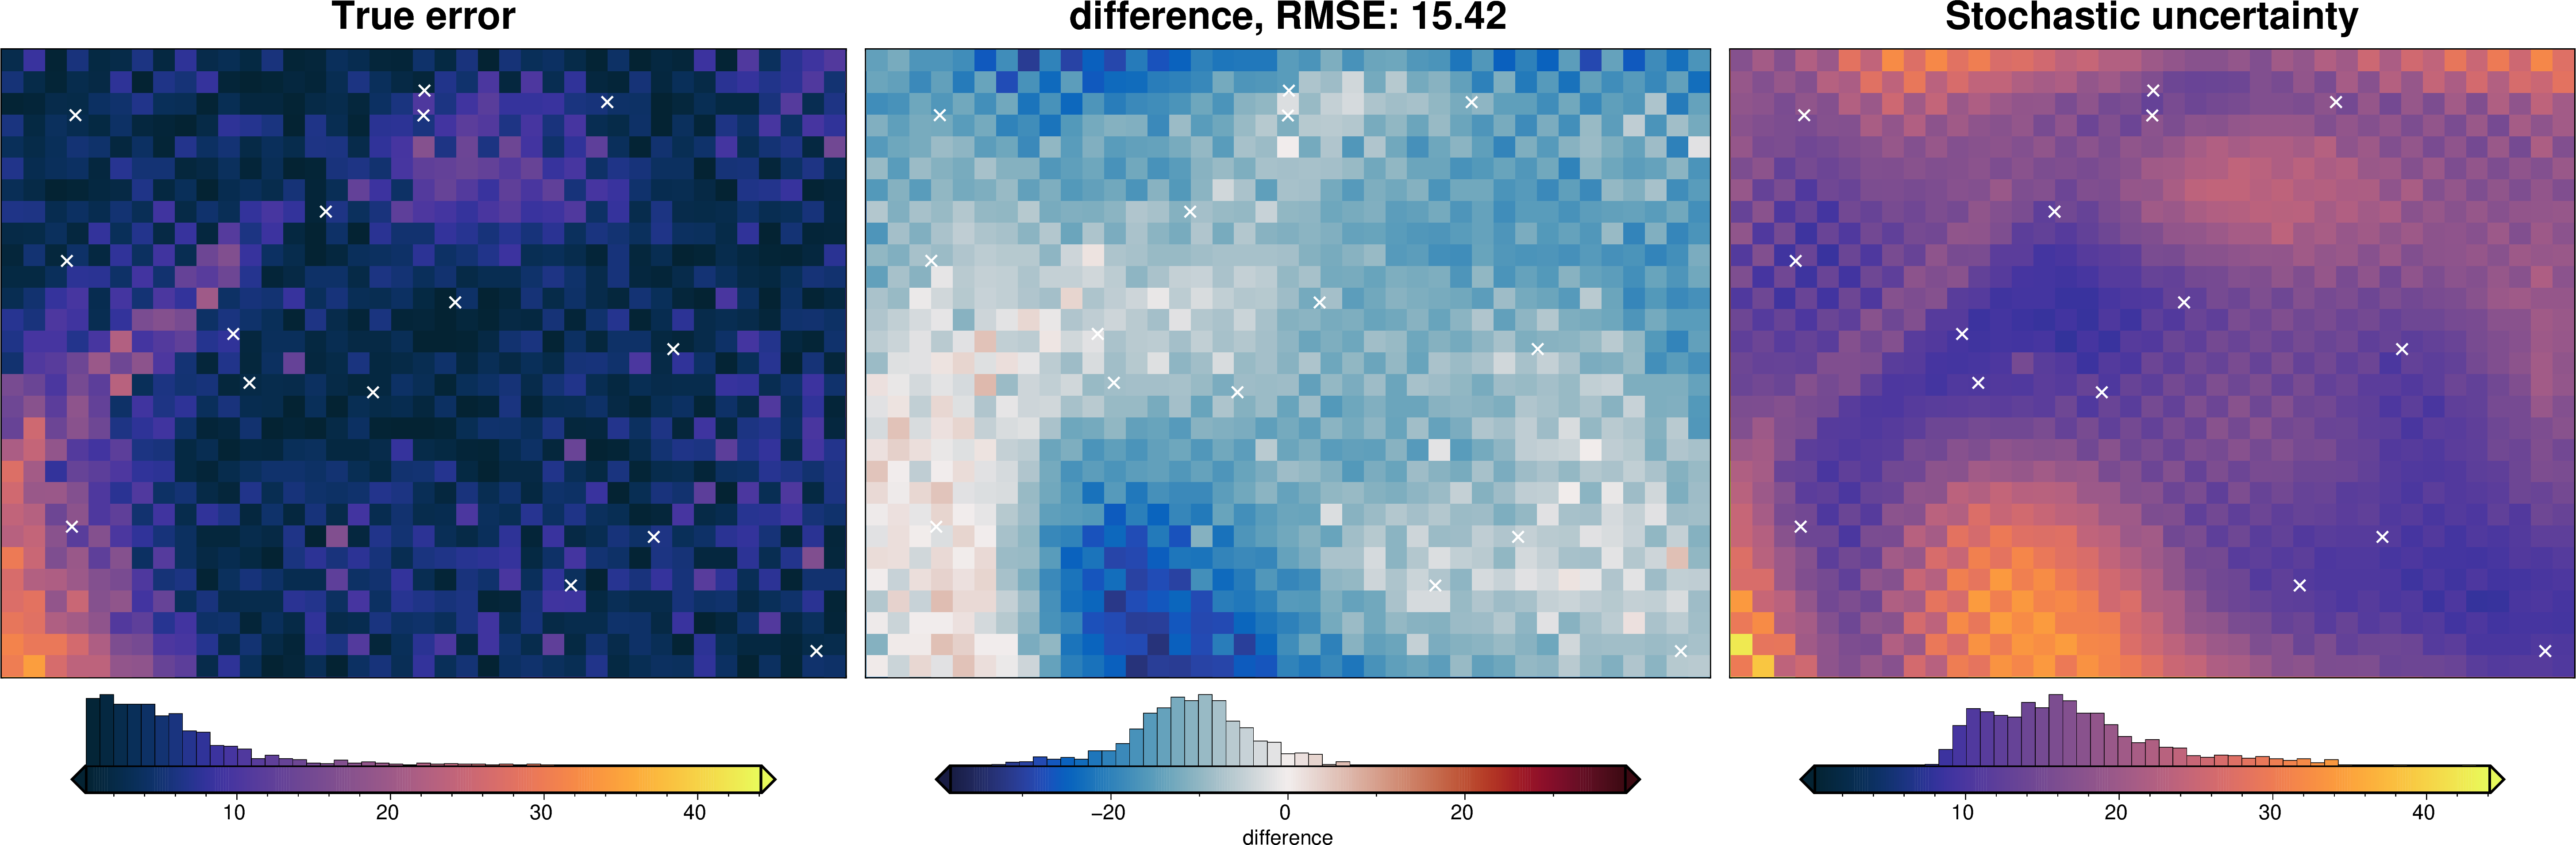

In [35]:
fname = "../tmp/uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraint_points,
    parameter_dict=solver_dict | density_dict | zref_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Comparing results

In [36]:
results = [
    uncert_results,
    uncert_regional_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
]
names = [
    "full",
    "regional",
    "grav",
    "constraints",
    "density",
    "damping",
]
# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        # region=vd.pad_region(region, -spacing),
    )
    stats.append(ds)

In [37]:
# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 62kB
Dimensions:            (northing: 31, easting: 41)
Coordinates:
  * northing           (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting            (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    full_stdev         (northing, easting) float64 10kB 51.99 58.87 ... 60.47
    regional_stdev     (northing, easting) float64 10kB 37.96 30.24 ... 62.07
    grav_stdev         (northing, easting) float64 10kB 2.295 1.828 ... 1.862
    constraints_stdev  (northing, easting) float64 10kB 11.18 9.943 ... 41.81
    density_stdev      (northing, easting) float64 10kB 0.1888 0.7488 ... 2.184
    damping_stdev      (northing, easting) float64 10kB 0.7171 1.013 ... 15.45

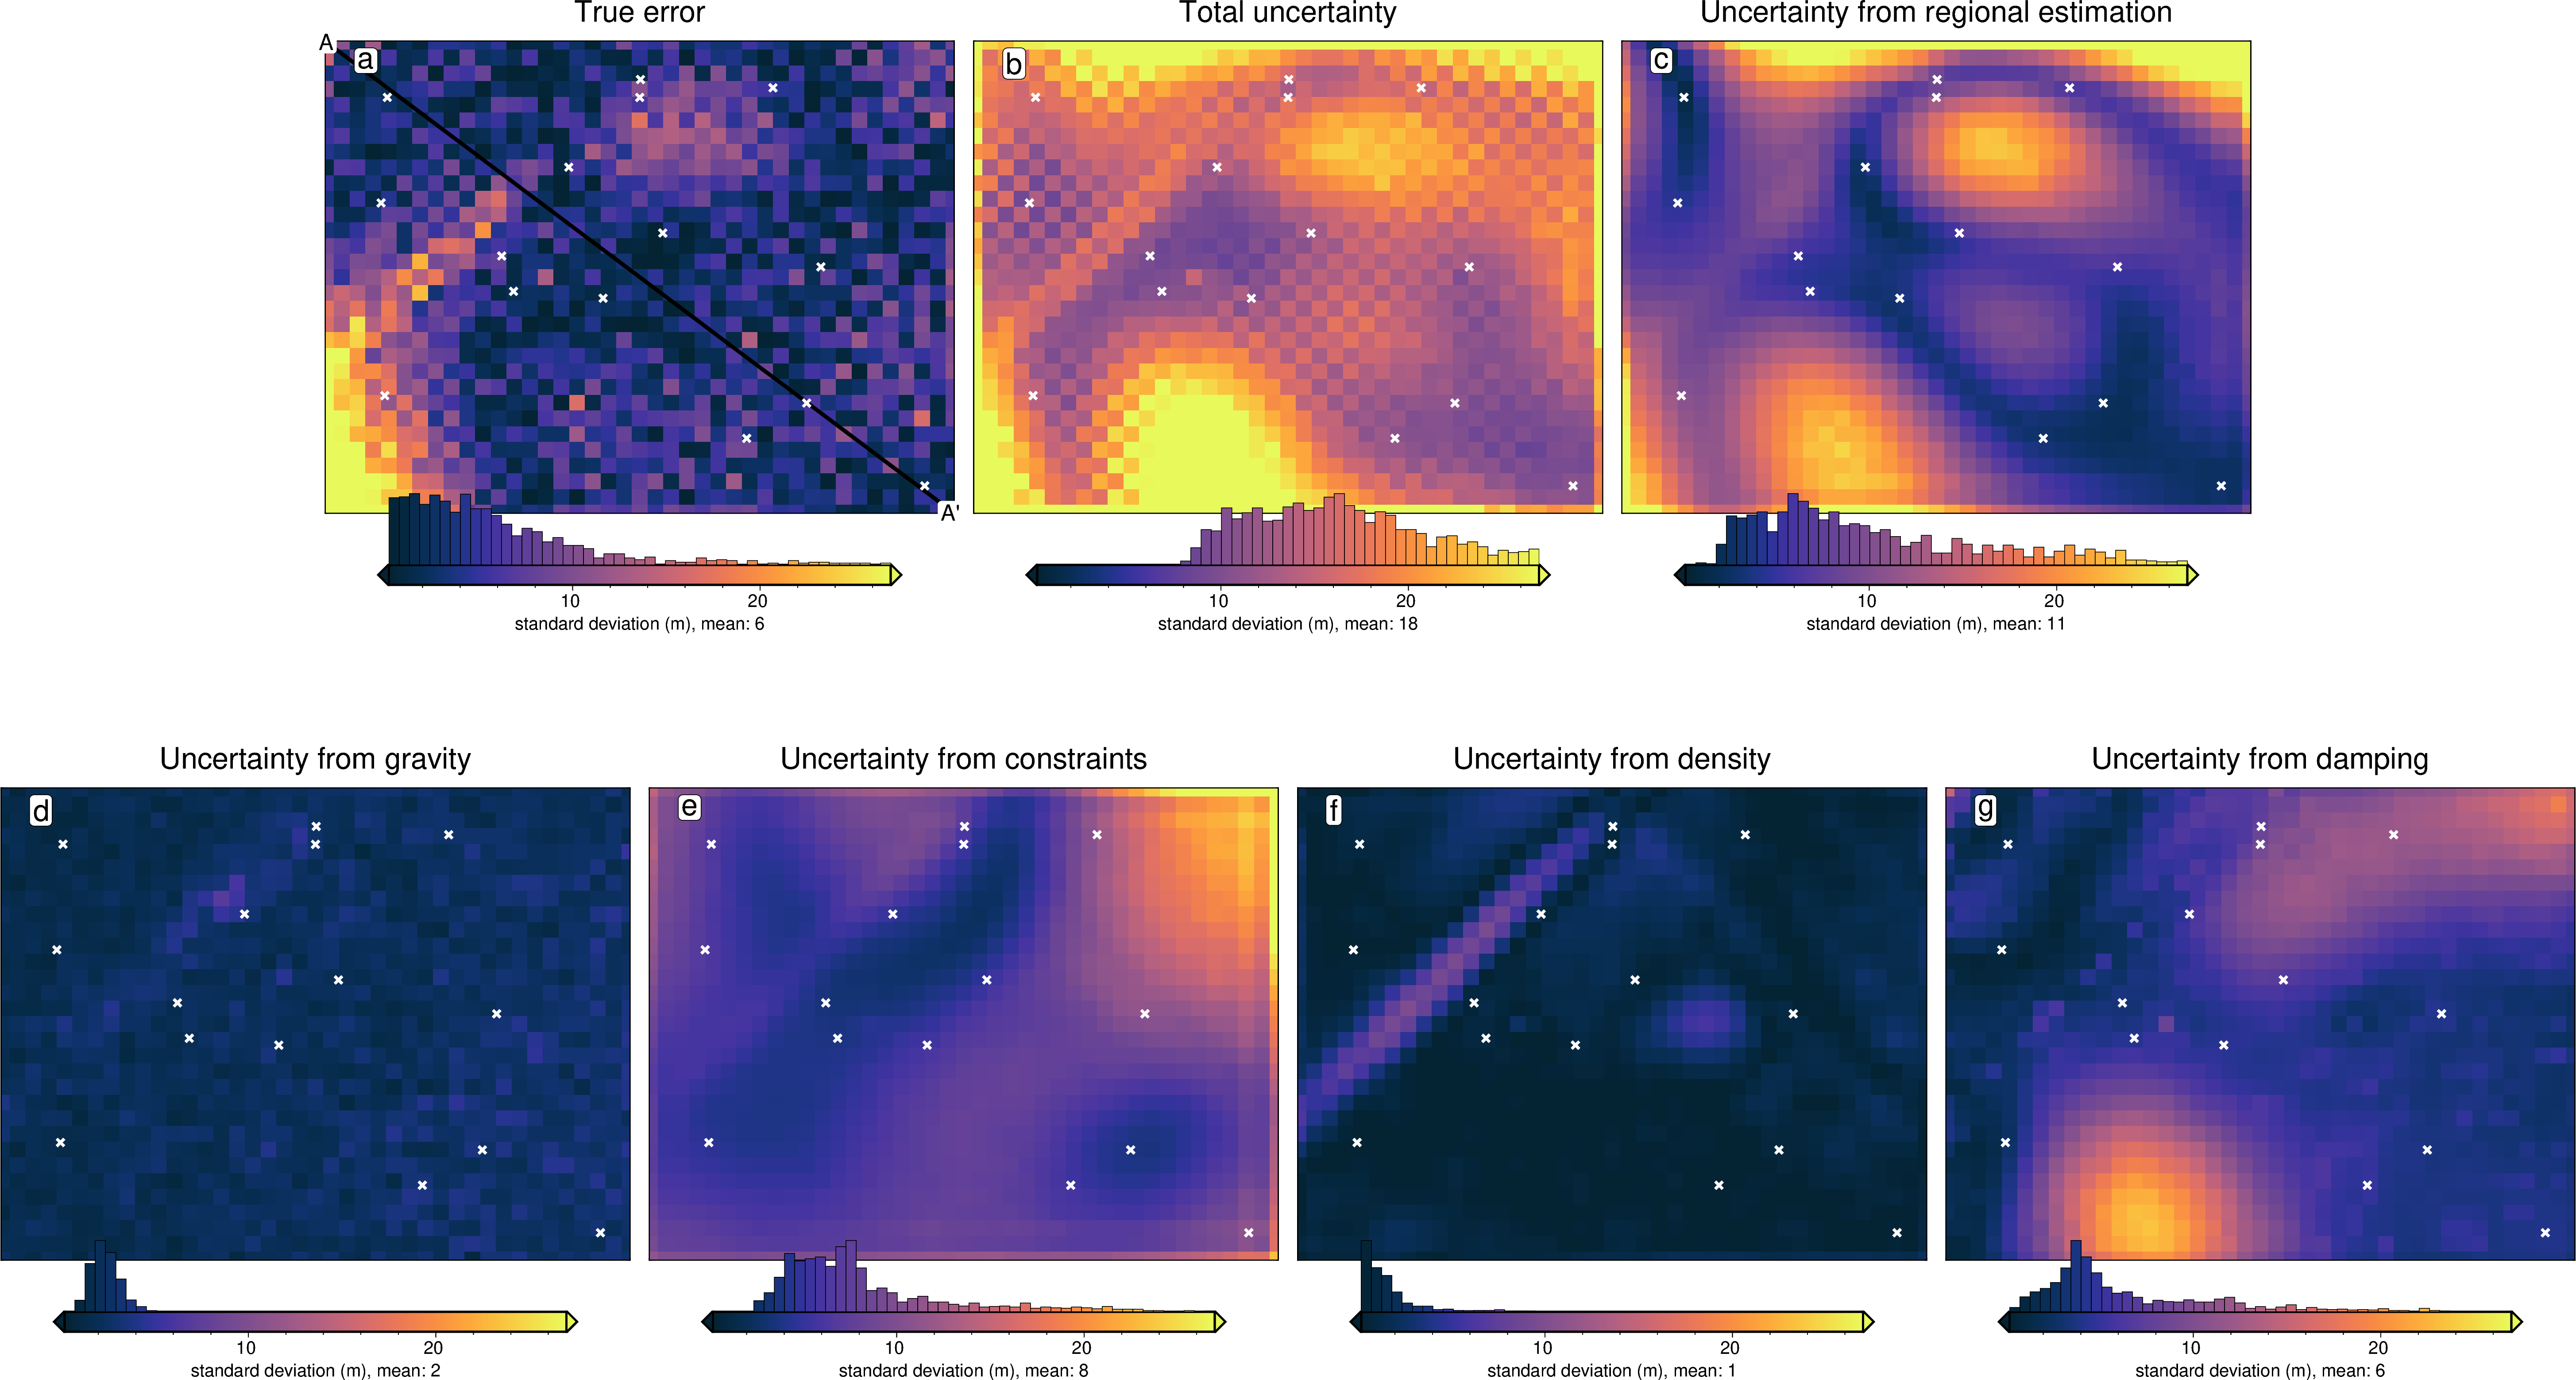

In [38]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from regional estimation",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))

cpt_lims = polar_utils.get_min_max(
    grids[0],
    robust=True,
)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both"
        xshift_amount = -2.5
    else:
        origin_shift = "x"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [region[0], region[3]]
        stop = [region[1], region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
        fill="white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
fig.show()

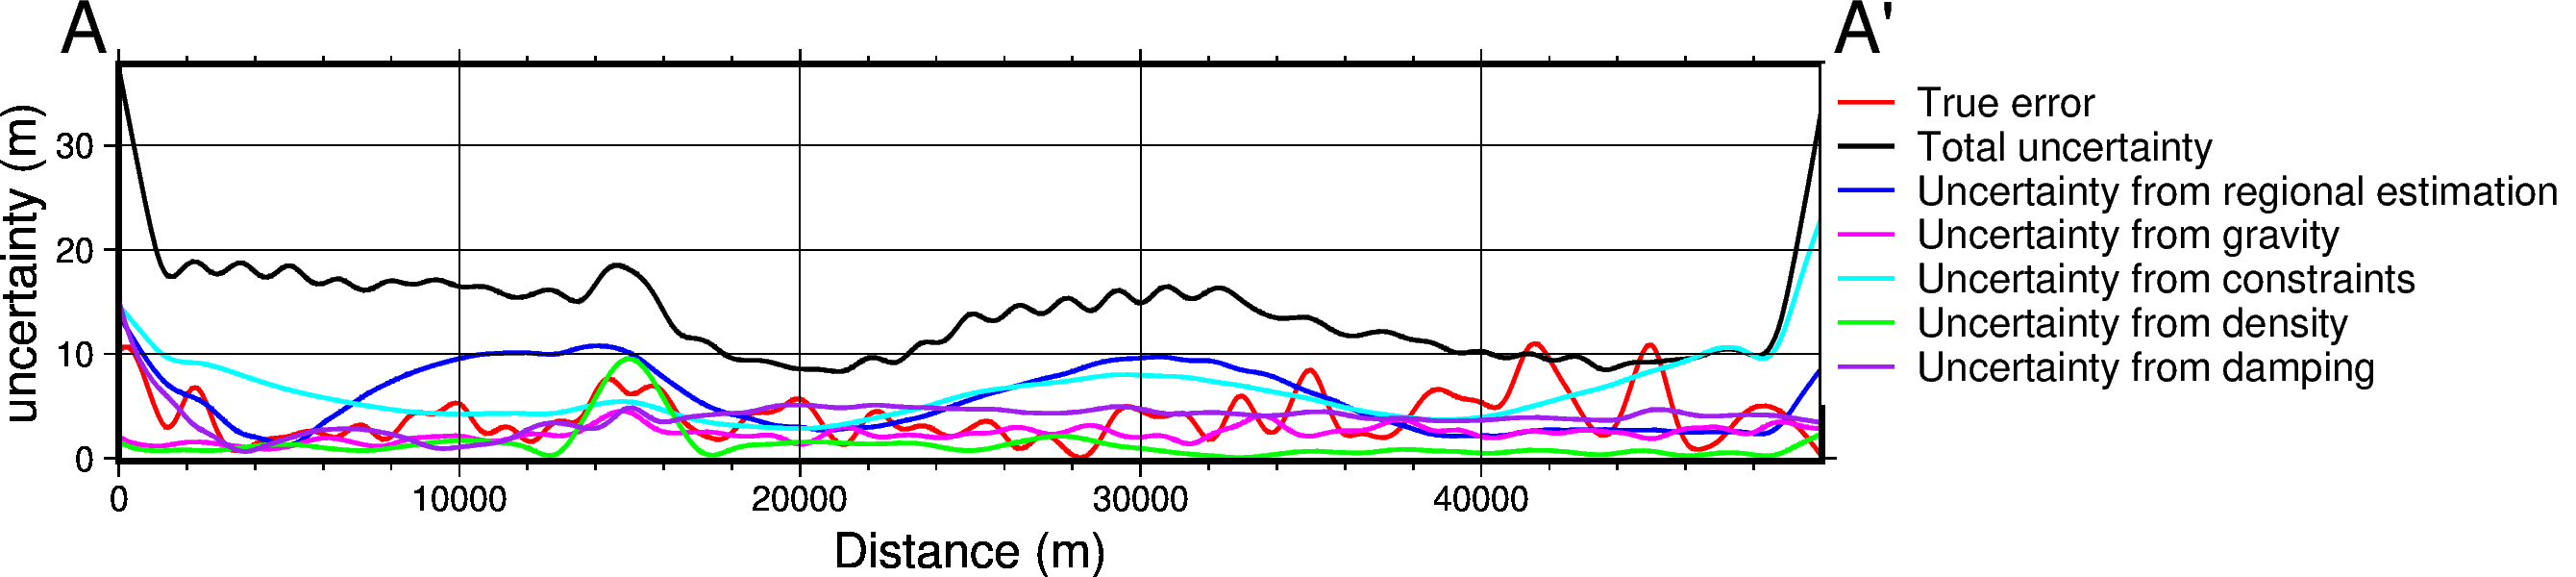

In [39]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[region[0], region[3]],
    stop=[region[1], region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()